In [1]:
%matplotlib inline
from __future__ import print_function, division
from astropy.table import Table
from itertools import product
import pandas as pd
import sys
sys.path.insert(0, '/global/common/cori/contrib/lsst/apps/anaconda/py3-envs/DESCQA/lib/python3.6/site-packages')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import h5py
from GCR import GCRQuery
import GCR 
plt.rcParams['font.size'] = 12
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0

from IPython.display import display

sys.path.insert(0, '/global/homes/j/jderose/project/gcr-catalogs-candels/')
import GCRCatalogs

sns.set(style='ticks', palette='colorblind')
sns.despine()

## Lu mock

luh5 = h5py.File('/global/homes/j/jderose/project/CANDELS-mocks/Lu mocks/lightcone_cosmos_0.h5', 'r')

## SC mock

## Universe Machine

In [52]:
from scipy.ndimage.filters import gaussian_filter
class DistributionND:

    def __init__(self, quantities, plot_axes, operations=None, 
                 labels=None, Nbins=25, lo=8., hi=12.,
                 norm_by=None, logbins=False, weight_quantity=None,
                 **kwargs):

        #catalog quantities
        self.quantities    = quantities
        self.Nd            = len(quantities)
        self.needs_derived = [isinstance(q, (list, tuple)) for q in quantities]
        self.norm_by       = norm_by
        
        if labels is None:
            labels = [None] * self.Nd
            
        if operations is None:
            operations = [None] * self.Nd
            
        for i, l in enumerate(labels):
            if (not l) & self.needs_derived[i]:
                raise(ValueError("Must provide names of derived quantities"))
            elif (not operations[i]) & self.needs_derived[i]:
                #default to subtraction, by far most common
                print('Waring: no operation supplied for quantity {}. Defaulting to subtraction'.format(l))
                operations[i] = lambda x, y: x - y
            elif (not l)& (not self.needs_derived[i]):
                labels[i] = quantities[i]
            
        self.labels    = labels
        self.operations = operations

        self.weight_quantity = weight_quantity
        if self.weight_quantity:
            self.labels.append(self.weight_quantity)
        
        #setup binning
        if not hasattr(Nbins, '__iter__'):
            Nbins = [Nbins] * self.Nd
        if not hasattr(lo, '__iter__'):
            lo    = [lo] * self.Nd
        if not hasattr(hi, '__iter__'):
            hi    = [hi] * self.Nd
        if not hasattr(logbins, '__iter__'):
            logbins    = [logbins] * self.Nd
            
        self.Nbins   = np.array(Nbins)
        self.lo      = np.array(lo)
        self.hi      = np.array(hi)
        self.logbins = np.array(logbins)
        self.bins    = []
        self.dx      = []

        for i in range(self.Nd):
            if self.logbins[i]:
                blo = np.log10(self.lo[i])
                bhi = np.log10(self.hi[i])
                b   = np.logspace(blo, bhi, self.Nbins[i]+1)
            else:
                blo = self.lo[i]
                bhi = self.hi[i]
                b   = np.linspace(blo, bhi, self.Nbins[i]+1)
                
            self.bins.append(b)
            self.dx.append((bhi - blo) / self.Nbins[i])
            
        self.dx   = np.array(self.dx)
        
        #self.filters = [(lambda z: (z > zmin) & (z < zmax), self.zlabel)]
        self.filters = None
        
        #setup subplot configuration
        self.plot_axes = plot_axes
        self.bin_axes  = np.array([i for i in range(self.Nd) 
                                   if i not in self.plot_axes])
        
        self.figure, self.axes = plt.subplots(*self.Nbins[self.bin_axes],
                                              sharex=True, sharey=True)
        self.axes              = np.array(self.axes).reshape(self.Nbins[self.bin_axes])

        self.figure.set_figheight(10)
        self.figure.set_figwidth(10)
        
        self.plot_Nd   = len(self.bin_axes)
        
        self.colors     = sns.color_palette('colorblind')
        self.color_maps = [cm.Blues, cm.Greens]

        self.catalog_count = 0
        self.lines = []
        self.catalog_names = []
        
        
    def new_quantities(self, quantities, labels=None, operations=None):

        self.quantities    = quantities
        self.Nd            = len(quantities)
        self.needs_derived = [isinstance(q, (list, tuple)) 
                              for q in quantities]
        
        if labels is None:
            labels = [None] * self.Nd
            
        if operations is None:
            operations = [None] * self.Nd
            
        for i, l in enumerate(labels):
            if (not l) & self.needs_derived[i]:
                raise(ValueError("Must provide names of derived quantities"))
            elif (not operations[i]) & self.needs_derived[i]:
                #default to subtraction, by far most common
                print('Waring: no operation supplied for quantity {}. Defaulting to subtraction'.format(l))
                operations[i] = lambda x, y: x - y
            elif (not l)& (not self.needs_derived[i]):
                labels[i] = quantities[i]
            
        self.labels    = labels
        self.operations = operations
       
        if self.weight_quantity:
            self.labels.append(self.weight_quantity)



    def run_on_single_catalog(self, catalog_instance, catalog_name,
                              output_dir, mean=False, useweights=False,
                              newfields=None):
        
        if newfields:
            self.new_quantities(*newfields)

        #setup quantities to bin on
        for i in range(self.Nd):
            if self.needs_derived[i]:
                try:
                    catalog_instance.add_modifier_on_derived_quantities(self.labels[i], 
                                                                        self.operations[i], 
                                                                        *self.quantities[i])
                except ValueError as e:
                    pass
            elif self.quantities[i] != self.labels[i]:
                try:
                    catalog_instance.add_modifier_on_derived_quantities(self.labels[i], 
                                                                        lambda x : x, self.quantities[i])
                except ValueError as e:
                    pass
                    

        counts = np.zeros(self.Nbins)
        
        if not useweights:
            labels     = [l for l in self.labels if l 
                          is not self.weight_quantity]
        else:
            labels = self.labels
        
        #calculate counts
        for catalog_data in catalog_instance.get_quantities(labels, return_iterator=True):
            catalog_data = pd.DataFrame(GCRQuery(*((np.isfinite, col) 
                                                   for col in catalog_data)).filter(catalog_data))
            
            if useweights:
                labels     = [l for l in self.labels if 
                              l is not self.weight_quantity]
                

            if (not self.weight_quantity) | (not useweights):
                c, e  = np.histogramdd(catalog_data[labels].values, 
                                       bins=self.bins)
            else:

                c, e  = np.histogramdd(catalog_data[labels].values, 
                                       bins=self.bins, weights=catalog_data[self.weight_quantity].values)
                
            counts += c
            
        #normalize counts here
        counts   = self.normalize_distribution(catalog_instance, counts)
        
        if (counts==0).all():
            print("Warning: counts are all equal to zero. Try changing binning")
        
        #make the plot
        axes_idx = [np.arange(n) for n in self.Nbins[self.bin_axes]]
        print(axes_idx)
        for idx in product(*axes_idx):
            count_idx                = np.array([slice(0,self.Nbins[i],1)
                                                 for i in range(self.Nd)])
            count_idx[self.bin_axes] = idx

            self.plot_distribution(self.axes[idx], 
                                   counts[count_idx.tolist()],
                                   catalog_name, mean=mean)
            
        l1 = plt.Rectangle((0,0),1,1,fc = self.colors[self.catalog_count])
        self.lines.append(l1)
        self.catalog_names.append(catalog_name)

            
        self.catalog_count += 1
        return counts
    
    def normalize_distribution(self, catalog_instance, counts):
        
        if self.norm_by is not None:
            dx = [np.log10(self.bins[i][1:]) - np.log10(self.bins[i][:-1]) 
                  if self.logbins[i] else self.bins[i][1:] - self.bins[i][:-1] 
                  for i in self.norm_by[0]]
            if len(dx)>1:
                dx = np.outer(dx[0], dx[1])
            else:
                dx = dx[0]

            if self.norm_by[1]=='prob':
                
                shape  = np.array([i for i in counts.shape])
                shape[self.norm_by[0]] = 1
                
                counts /= np.sum(counts, axis=self.norm_by[0]).reshape(shape)
                
                shape  = np.array([counts.shape[i] if i in self.norm_by[0] else 1 for i in range(self.Nd)])
                dx     = dx.reshape(shape)
                
                return counts / dx
            
            elif self.norm_by[1]=='volume':
                zidx    = self.norm_by[0]
                shape   = np.ones(self.Nd, dtype=int)
                shape[zidx] = self.Nbins[zidx]
                
                d_comv  = catalog_instance.cosmology.comoving_distance(self.bins[zidx[0]]).value 
                vol     = (4 * np.pi / 3 * (d_comv[1:]**3 - d_comv[:-1]**3)
                               * catalog_instance.area / 41253.)
                
                counts /= vol.reshape(shape)
                return counts

            elif self.norm_by[1]=='area':
                
                counts /= catalog_instance.area
                return counts
            
        else:
            return counts

        
    def plot_distribution(self, axis, normed_counts, catalog_name, mean=False):
        
        if (normed_counts==0).all():
            print("Bin all zero")
            return
        
        plot_Nd = len(normed_counts.shape)
        
        
        if plot_Nd==1:
            assert len(self.plot_axes)==1

            x_edges = self.bins[self.plot_axes[0]]
            if self.logbins[self.plot_axes[0]]:
                x  = (np.log10(x_edges[1:] * x_edges[:-1])) / 2 
            else:
                x  = (x_edges[1:] + x_edges[:-1]) / 2

            axis.plot(x, normed_counts)
            
        else:
            assert len(self.plot_axes) == 2
            
            x_edges = [self.bins[i] for i in self.plot_axes]
            x       = []

            for i in range(2):
                if self.logbins[self.plot_axes[i]]:
                    x.append((np.log10(x_edges[i][1:] * x_edges[i][:-1])) / 2 )
                else:
                    x.append((x_edges[i][1:] + x_edges[i][:-1]) / 2)
                    
            Y, X = np.meshgrid(x[0], x[1])
            
            sorted_counts = gaussian_filter(normed_counts, 
                                            sigma=1.5).flatten()
            sorted_counts.sort()
            norm = np.sum(sorted_counts)
            p = sorted_counts.flatten()/norm
            p = p.cumsum()
            levels = sorted_counts[p.searchsorted([0.14, 0.61, 0.999])]
            
            if not mean:
                l1 = axis.contourf(X, Y, 
                                   gaussian_filter(normed_counts.T, sigma=1.5), 
                                   levels, cmap=self.color_maps[self.catalog_count], 
                                   alpha=0.75)
                l1 = axis.contour(X, Y,
                                  gaussian_filter(normed_counts.T, sigma=1.5),
                                  levels, cmap=self.color_maps[self.catalog_count],
                                  alpha=0.75)

            else:
                dY = x_edges[1][1:] - x_edges[1][:-1]
                ymean = (np.sum(Y * normed_counts.T * dY.reshape(-1,1), axis=1) 
                         / np.sum(normed_counts.T * dY.reshape(-1,1), axis=1))
                ystd  = (np.sum(Y**2 * normed_counts.T * dY.reshape(-1,1), axis=1) 
                         / np.sum(normed_counts.T * dY.reshape(-1,1), axis=1))
                axis.errorbar(x[1], ymean, ystd, color=self.colors[self.catalog_count])
            

    def finalize_plot(self, ylabel=None, yscale='linear', xscale='linear'):
        
        sax = self.figure.add_subplot(111)
        plt.setp(sax.get_xticklines(), visible=False)
        plt.setp(sax.get_yticklines(), visible=False)
        plt.setp(sax.get_xticklabels(), visible=False)
        plt.setp(sax.get_yticklabels(), visible=False)
        sax.patch.set_alpha(0.0)
        sax.patch.set_facecolor('none')
        sax.spines['top'].set_color('none')
        sax.spines['bottom'].set_color('none')
        sax.spines['left'].set_color('none')
        sax.spines['right'].set_color('none')
        sax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
        
        if len(self.plot_axes)==2:
            sax.set_xlabel(self.labels[self.plot_axes[1]], 
                           labelpad=40, fontsize=20)
            sax.set_ylabel(self.labels[self.plot_axes[0]],
                           labelpad=40, fontsize=20)
        else:
            sax.set_xlabel(self.labels[self.plot_axes[0]],
                           labelpad=40, fontsize=20)
            sax.set_ylabel(ylabel, labelpad=40, fontsize=20)
            
        
        if len(self.axes.shape)>1:
            self.axes[0][0].legend(self.lines, self.catalog_names)
            self.axes[0][0].set_yscale(yscale)
            self.axes[0][0].set_xscale(xscale)
        else:
            self.axes[0].legend(self.lines, self.catalog_names)
            self.axes[0].set_yscale(yscale)
            self.axes[0].set_xscale(xscale)
        plt.tight_layout()


In [32]:
lu_gc = GCRCatalogs.load_catalog('lu')
sc_gc = GCRCatalogs.load_catalog('sc')
scc_gc = GCRCatalogs.load_catalog('sc_candelized')
um_gc = GCRCatalogs.load_catalog('universemachine')

## Model-model comparisons

[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


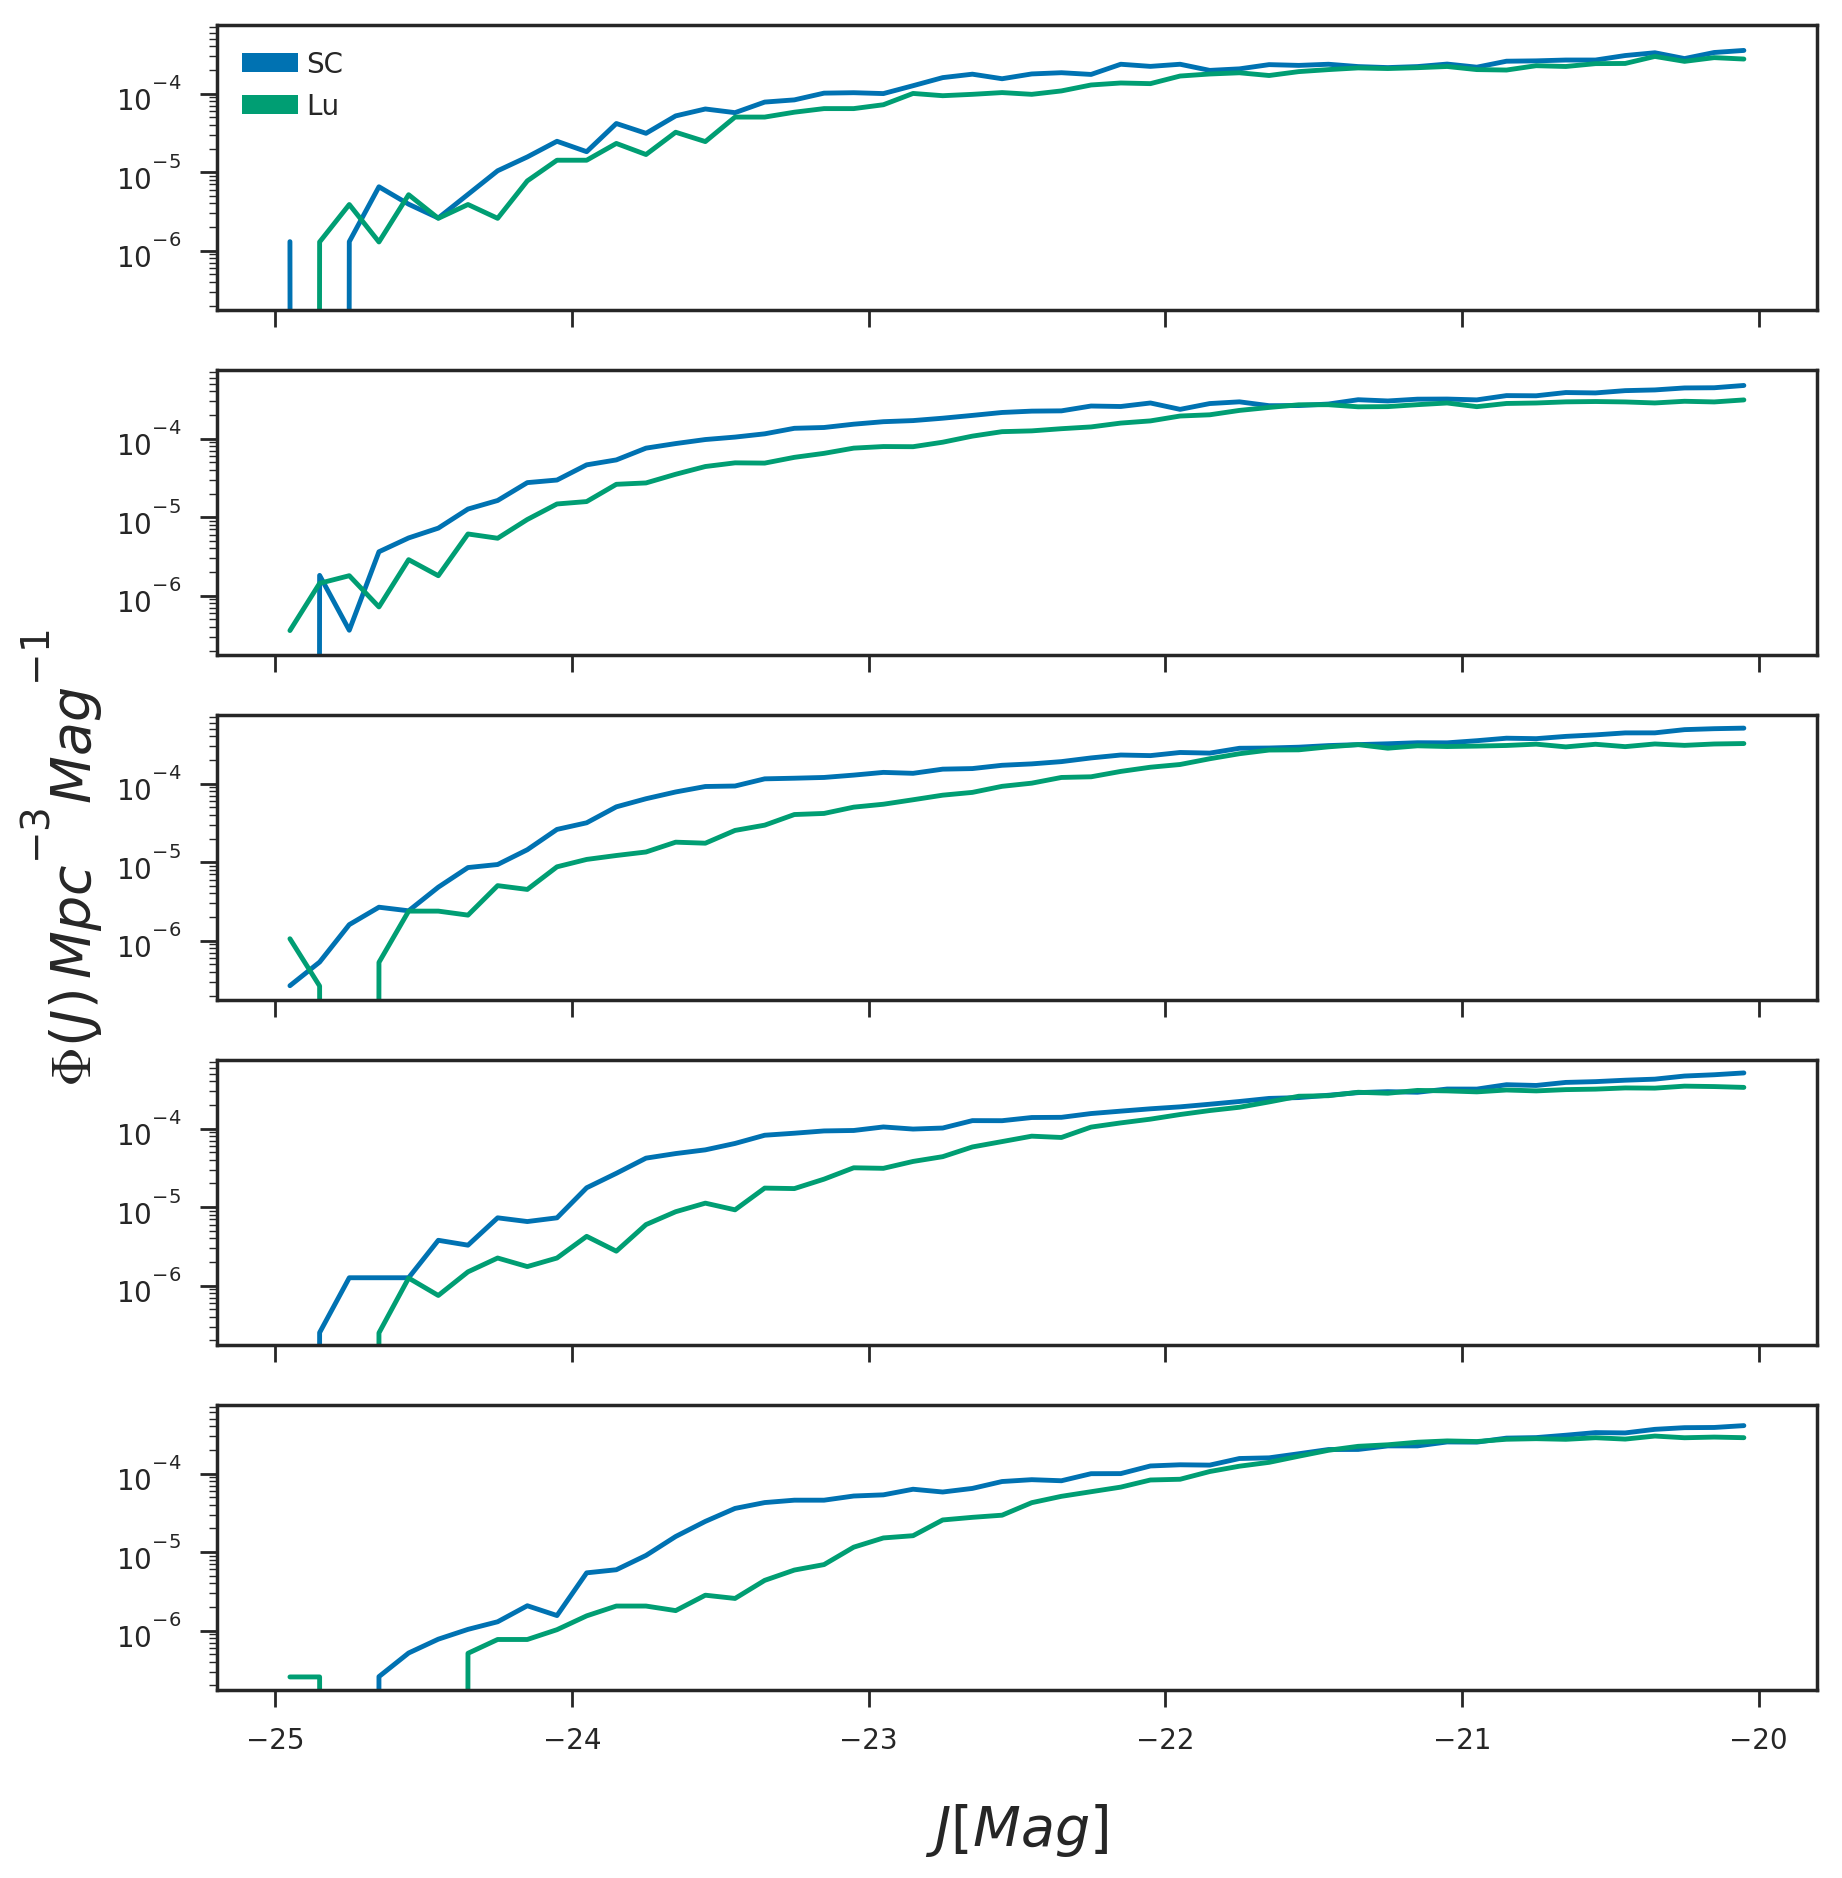

In [23]:
variables = ['redshift_true', 'Mag_true_dust_J_z0']
labels    = ['redshift_true', r'$J [Mag]$']
operations = [None, None]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.0, -25]
bin_hi   = [3.5, -20]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi,
                      logbins=logbins, norm_by=([0], 'volume'))

c = test.run_on_single_catalog(sc_gc, 'SC', './')
c = test.run_on_single_catalog(lu_gc, 'Lu', './')

test.finalize_plot(r'$\Phi(J)\/ Mpc^{-3} Mag^{-1}$', yscale='log')


[array([0, 1, 2, 3, 4, 5])]
[array([0, 1, 2, 3, 4, 5])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


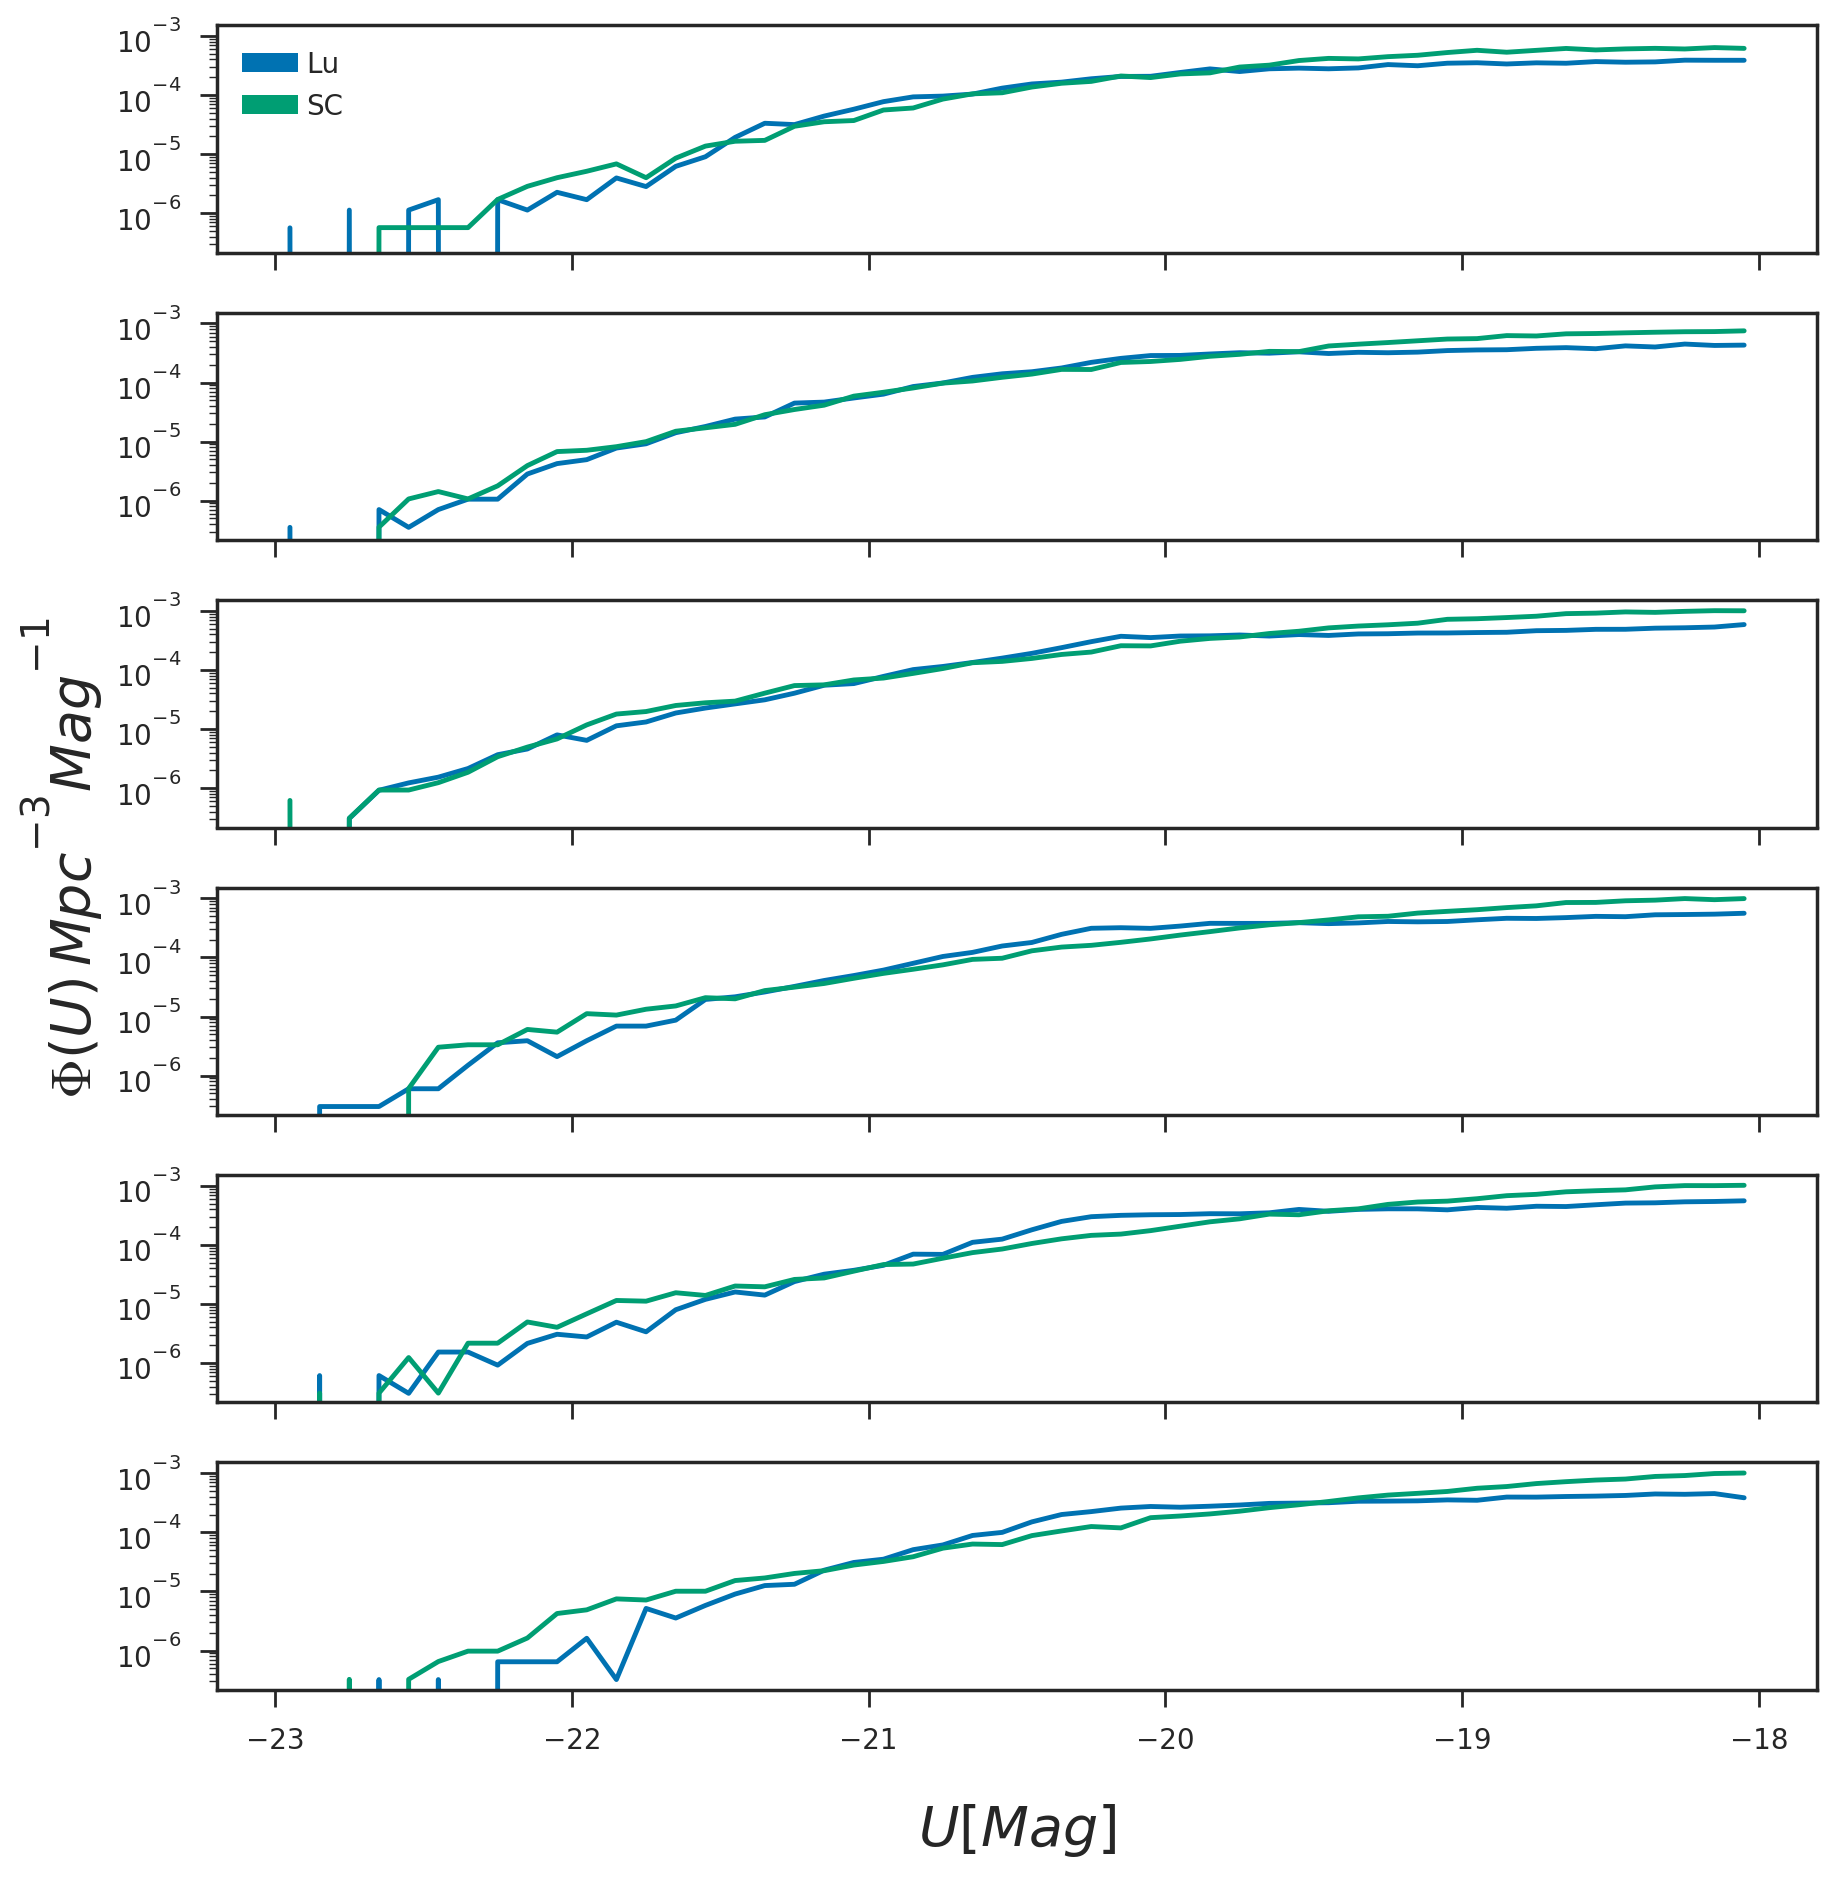

In [24]:
variables = ['redshift_true', 'Mag_true_dust_U_z0']
labels    = ['redshift_true', r'$U [Mag]$']
operations = [None, lambda x, y: x-y, lambda x, y: x-y]
plot_axes = [1]

Nbins    = [6, 50]
bin_lo   = [0.5, -23]
bin_hi   = [4.0, -18]
logbins  = [False, False]

test = DistributionND(variables, plot_axes, operations=operations, 
                      labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi,
                      logbins=logbins, norm_by=([0], 'volume'))

c = test.run_on_single_catalog(lu_gc, 'Lu', './')
c = test.run_on_single_catalog(sc_gc, 'SC', './')

test.finalize_plot(r'$\Phi(U)\/ Mpc^{-3} Mag^{-1}$', yscale='log')


[array([0, 1])]
[array([0, 1])]
[array([0, 1])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


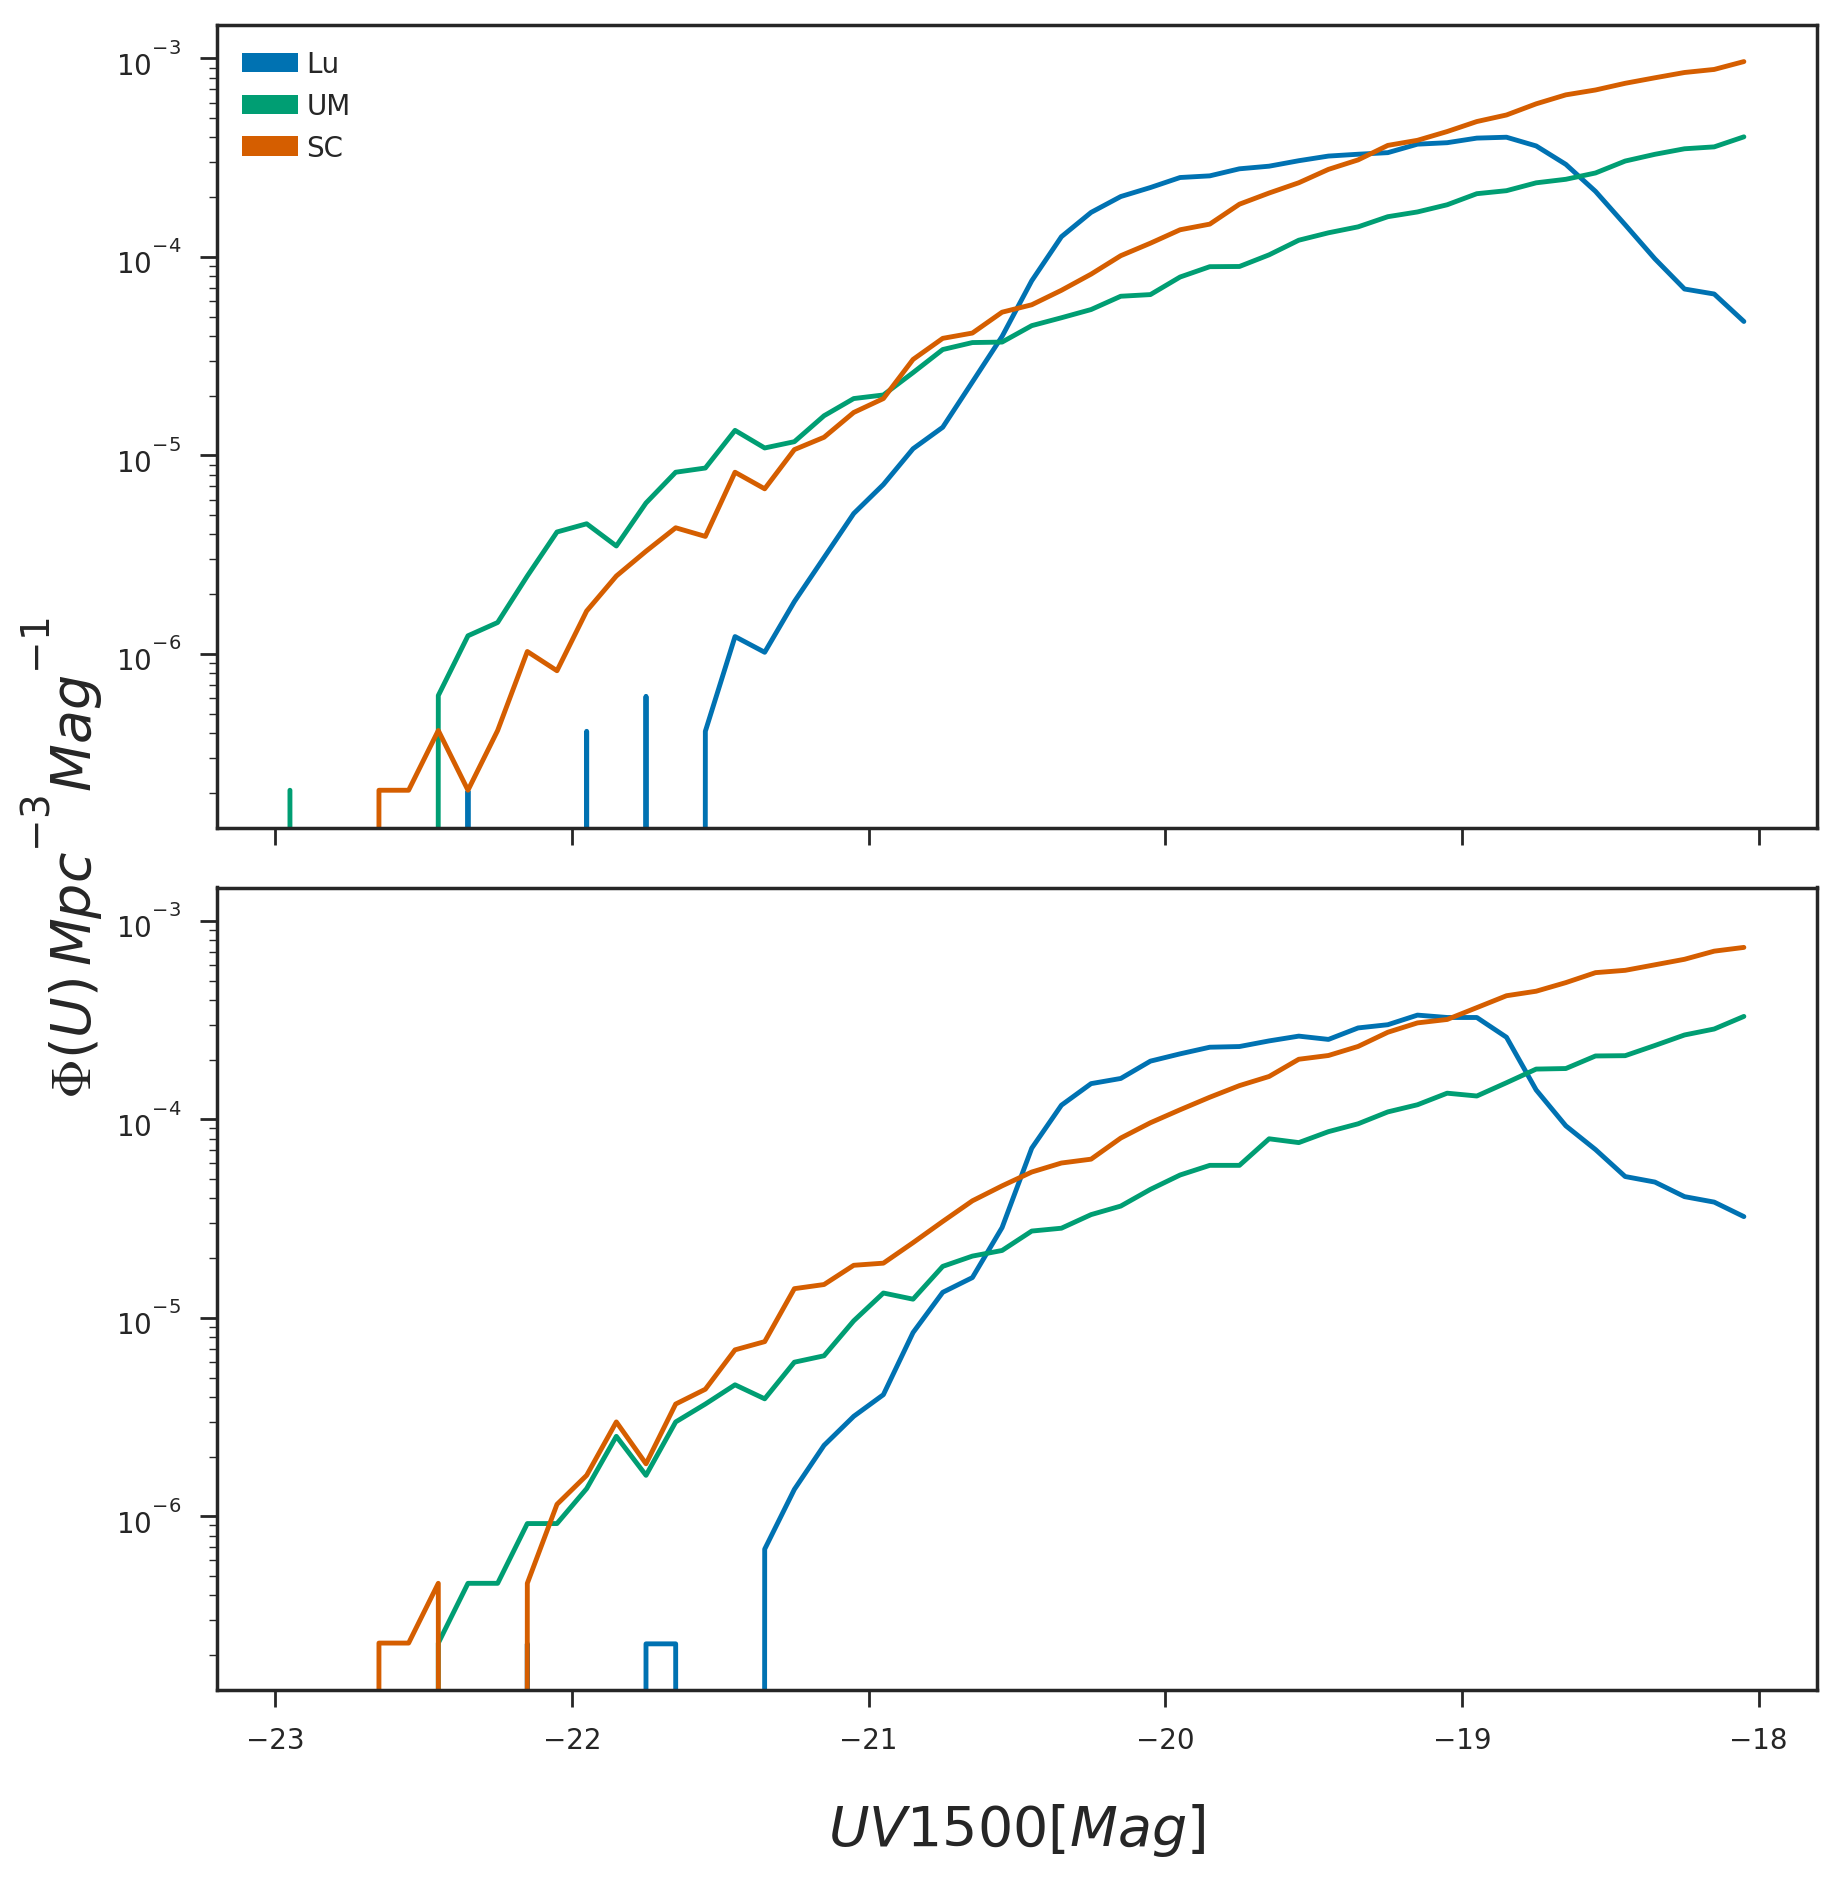

In [26]:
variables = ['redshift_true', 'Mag_true_dust_UV1500_z0']
labels    = ['redshift_true', r'$UV1500 [Mag]$']
operations = [None, lambda x, y: x-y, lambda x, y: x-y]
plot_axes = [1]

Nbins    = [2, 50]
bin_lo   = [4.0, -23]
bin_hi   = [6.0, -18]
logbins  = [False, False]

test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi,
                      logbins=logbins, norm_by=([0], 'volume'))

c = test.run_on_single_catalog(lu_gc, 'Lu', './')
c = test.run_on_single_catalog(um_gc, 'UM', './')
c = test.run_on_single_catalog(sc_gc, 'SC', './')

test.finalize_plot(r'$\Phi(U)\/ Mpc^{-3} Mag^{-1}$', yscale='log')


[array([0, 1, 2, 3, 4, 5])]
[array([0, 1, 2, 3, 4, 5])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


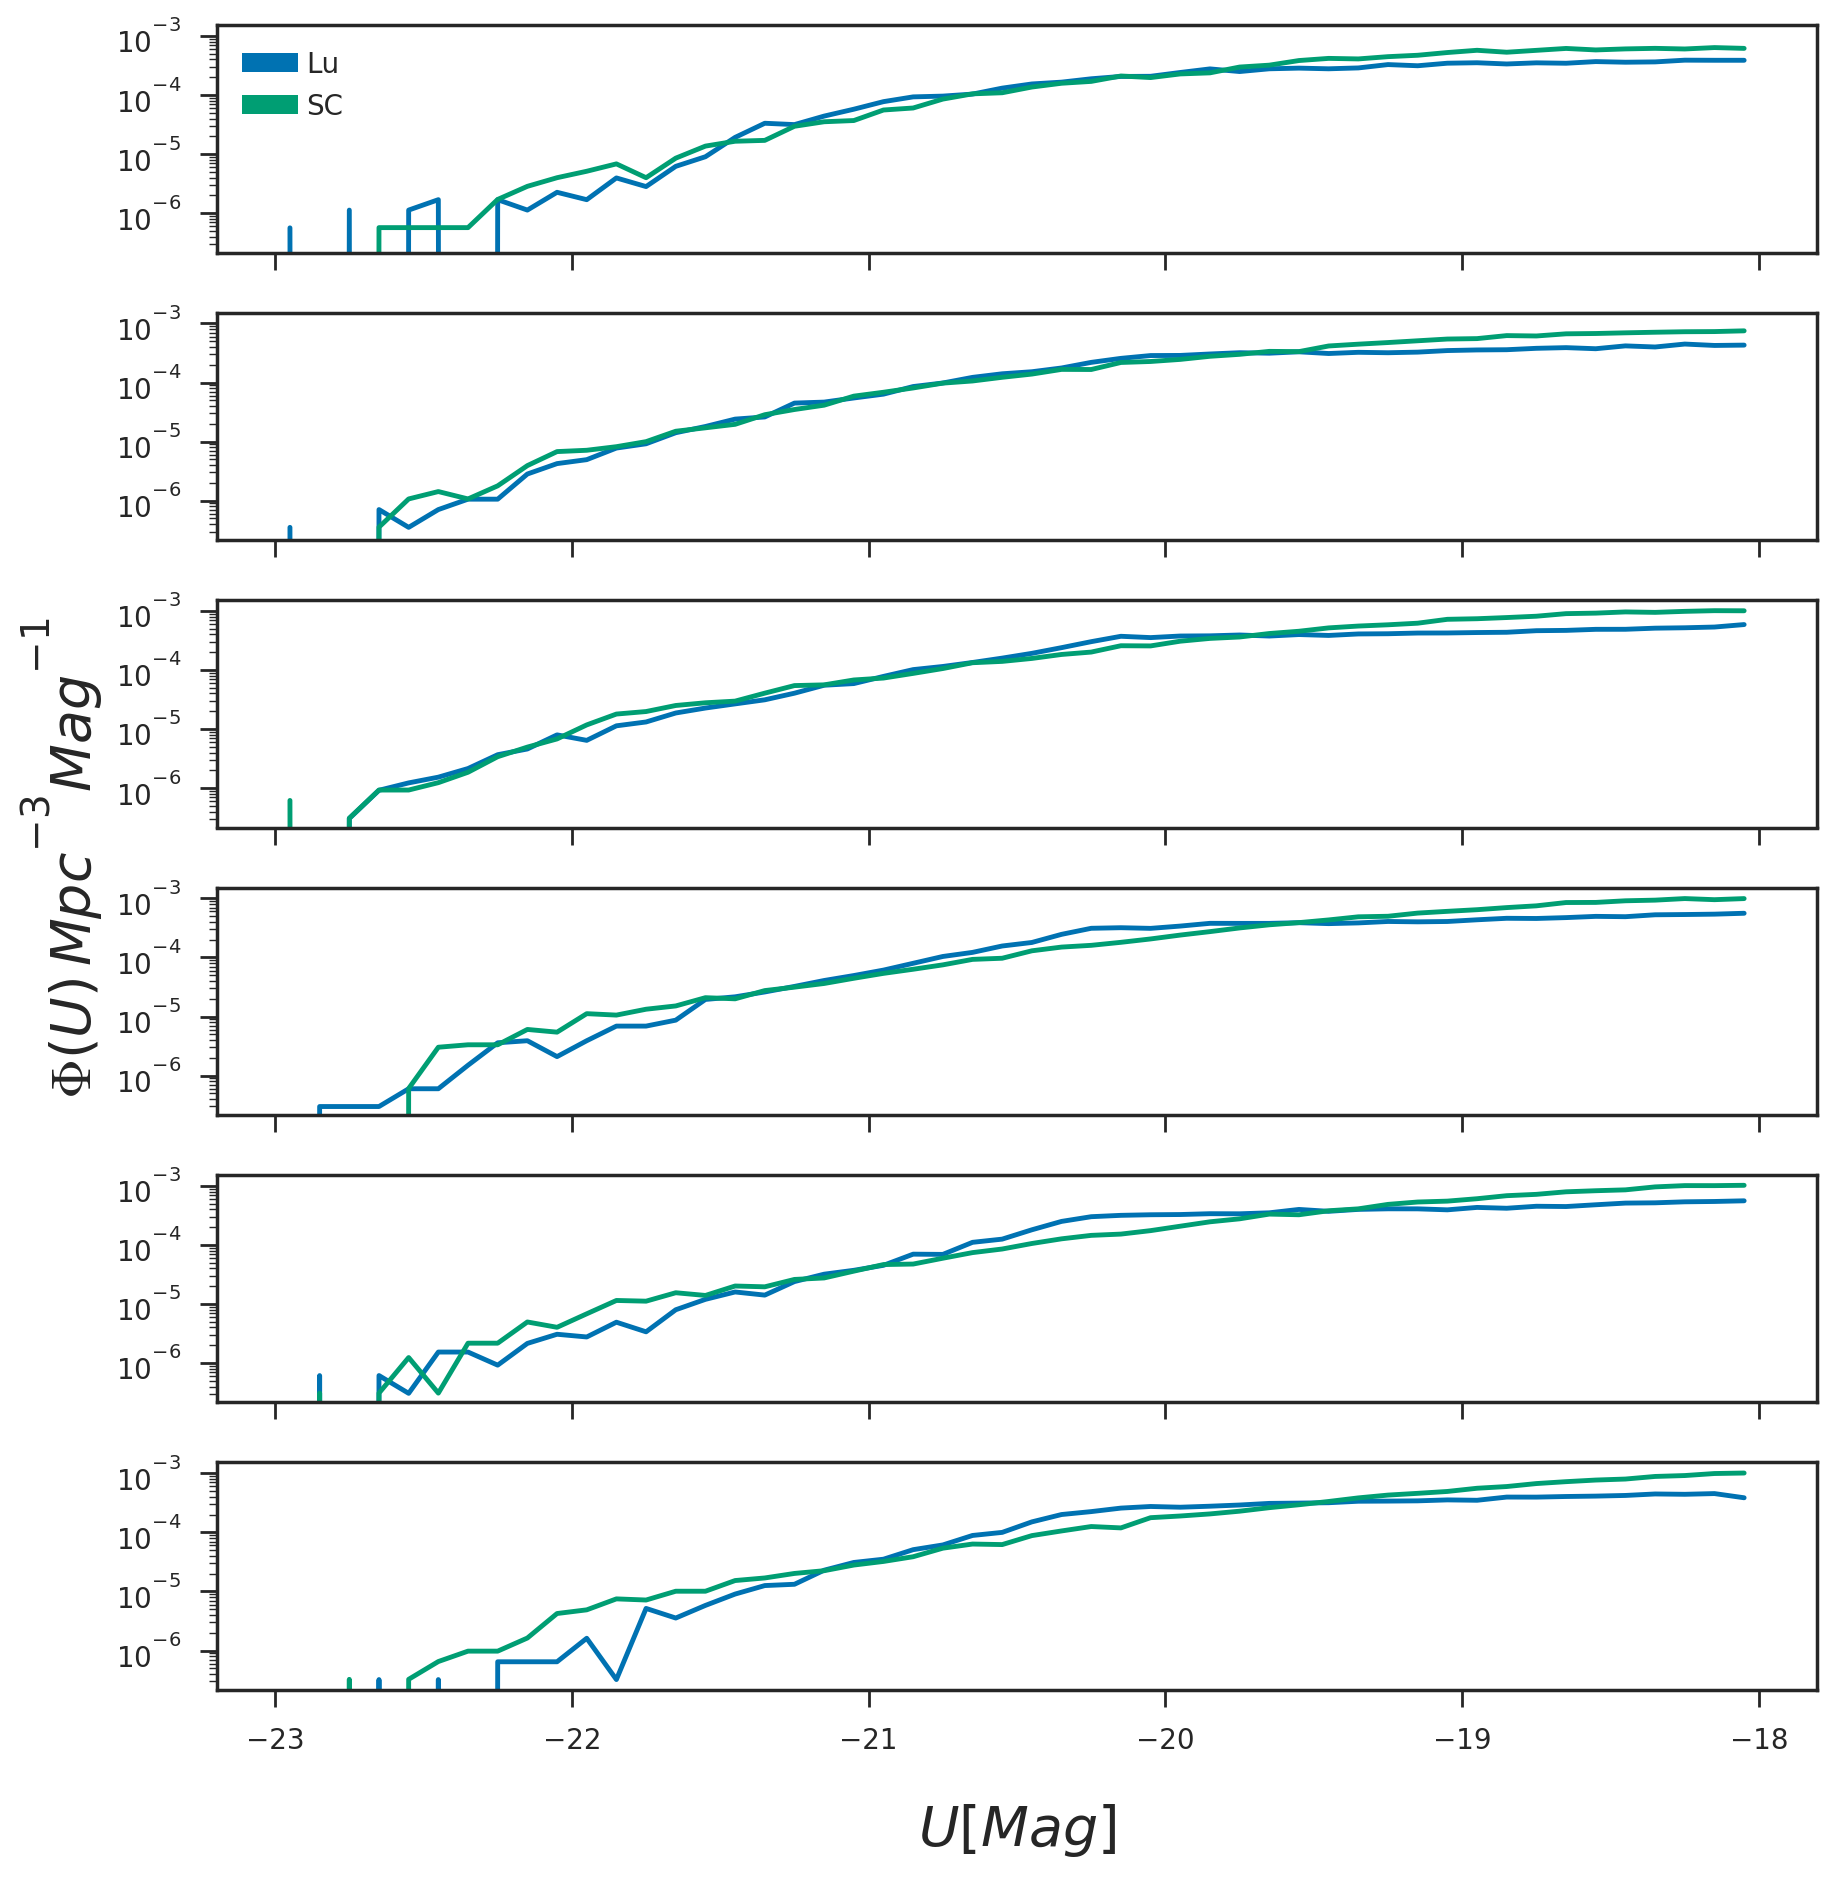

In [25]:
variables = ['redshift_true', 'Mag_true_dust_U_z0']
labels    = ['redshift_true', r'$U [Mag]$']
operations = [None, lambda x, y: x-y, lambda x, y: x-y]
plot_axes = [1]

Nbins    = [6, 50]
bin_lo   = [0.5, -23]
bin_hi   = [4.0, -18]
logbins  = [False, False]

test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi,
                      logbins=logbins, norm_by=([0], 'volume'))

c = test.run_on_single_catalog(lu_gc, 'Lu', './')
c = test.run_on_single_catalog(sc_gc, 'SC', './')

test.finalize_plot(r'$\Phi(U)\/ Mpc^{-3} Mag^{-1}$', yscale='log')


[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


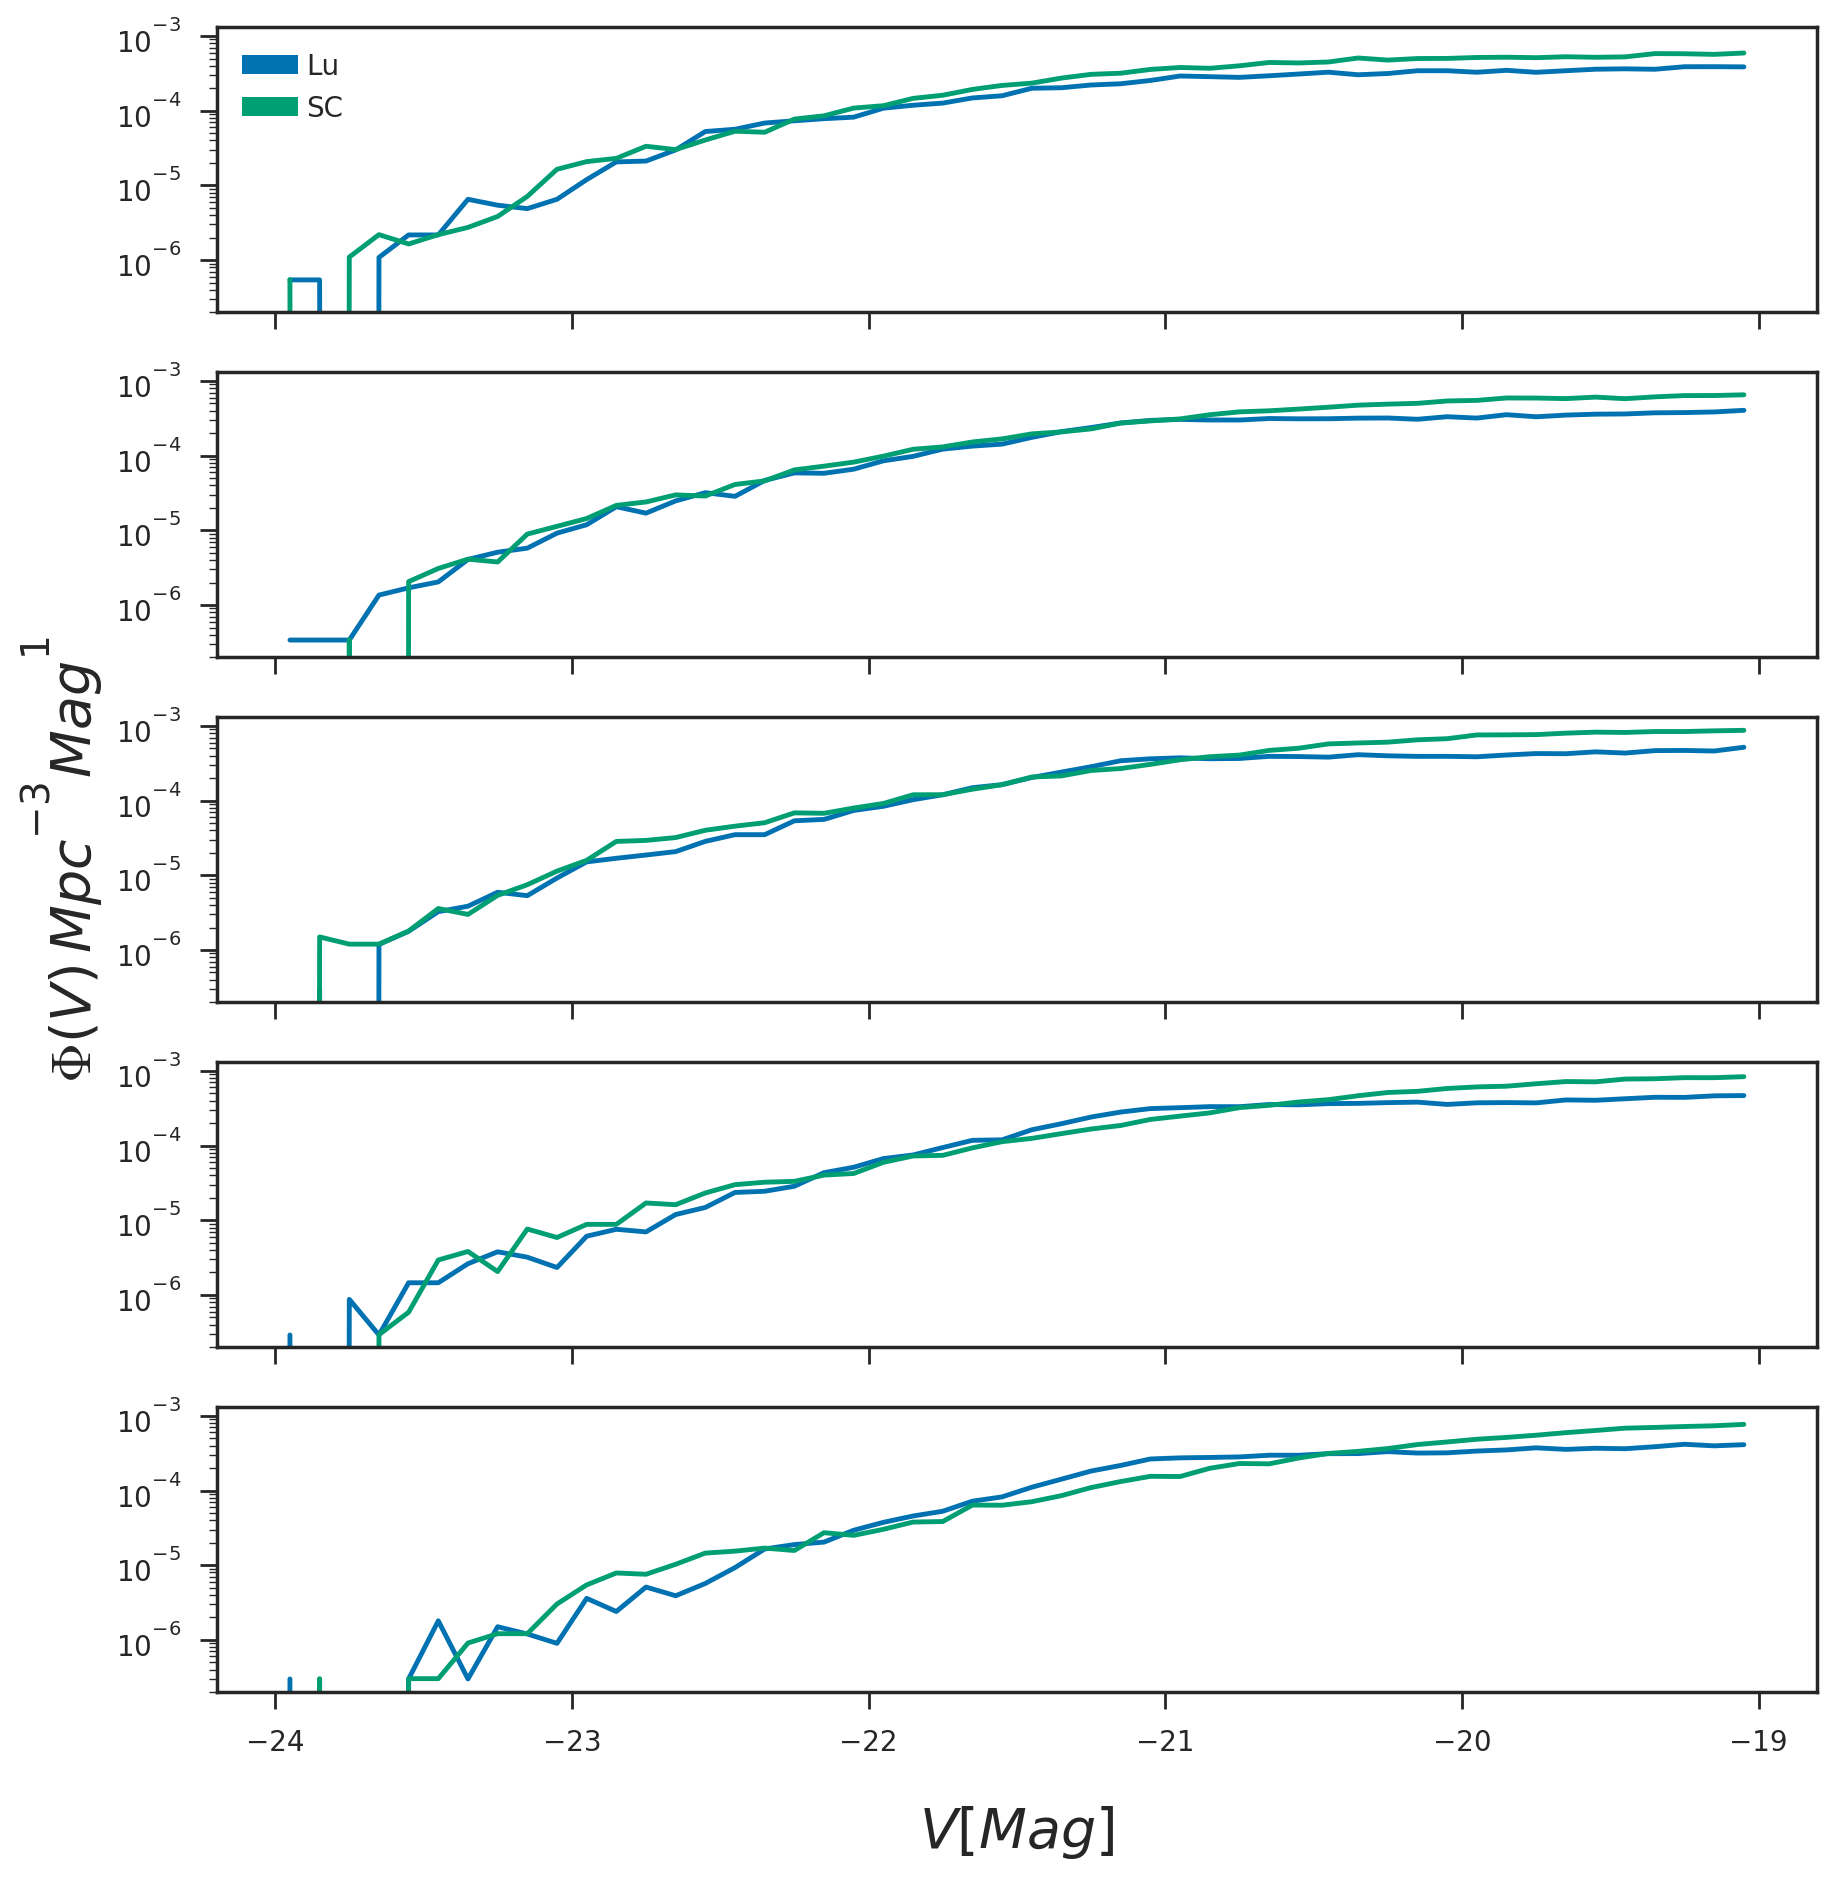

In [30]:
variables = ['redshift_true', 'Mag_true_dust_V_z0']
labels    = ['redshift_true', r'$V [Mag]$']
operations = [None, lambda x, y: x-y, lambda x, y: x-y]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.5, -24]
bin_hi   = [3.5, -19]
logbins  = [False, False]

test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo, 
                      hi=bin_hi, logbins=logbins, norm_by=([0], 'volume'))

c = test.run_on_single_catalog(lu_gc, 'Lu', './')
c = test.run_on_single_catalog(sc_gc, 'SC', './')

test.finalize_plot(r'$\Phi(V)\/ Mpc^{-3} Mag^{1}$', yscale='log')


[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


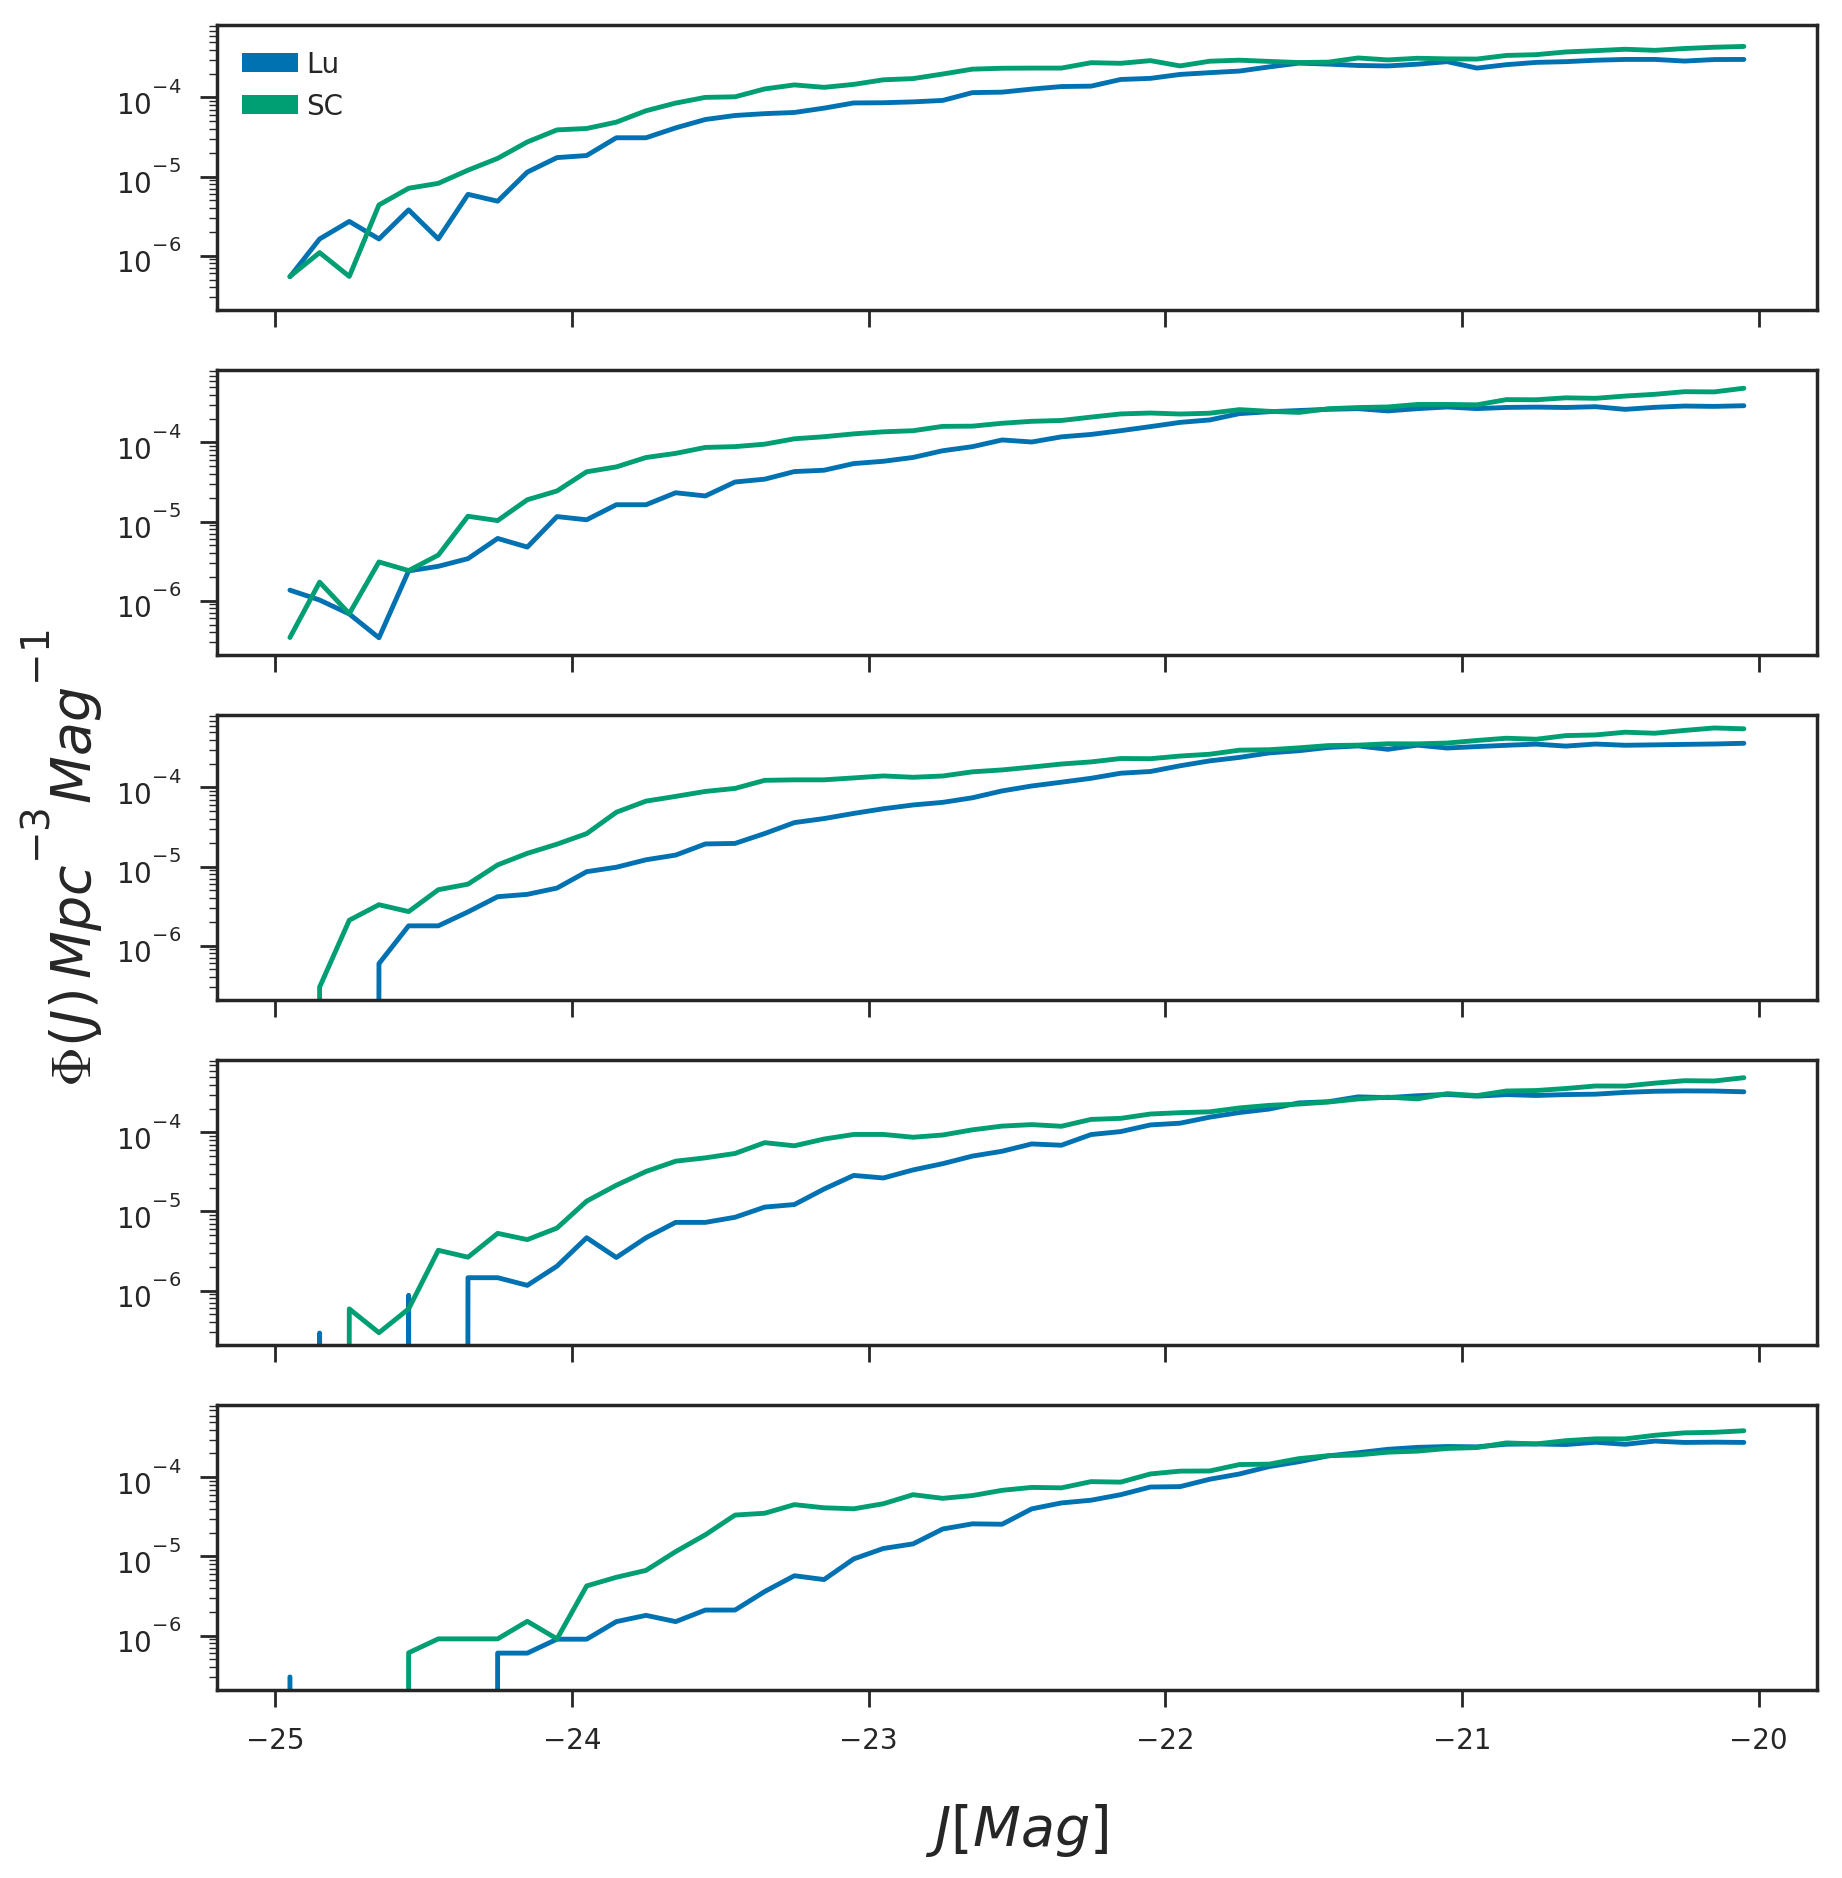

In [33]:
variables = ['redshift_true', 'Mag_true_dust_J_z0']
labels    = ['redshift_true', r'$J [Mag]$']
operations = [None, lambda x, y: x-y, lambda x, y: x-y]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.5, -25]
bin_hi   = [3.5, -20]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi,
                      logbins=logbins, norm_by=([0], 'volume'))

c = test.run_on_single_catalog(lu_gc, 'Lu', './')
c = test.run_on_single_catalog(sc_gc, 'SC', './')

test.finalize_plot(r'$\Phi(J)\/ Mpc^{-3} Mag^{-1}$', yscale='log')


[array([0, 1]), array([0])]
[array([0, 1]), array([0])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


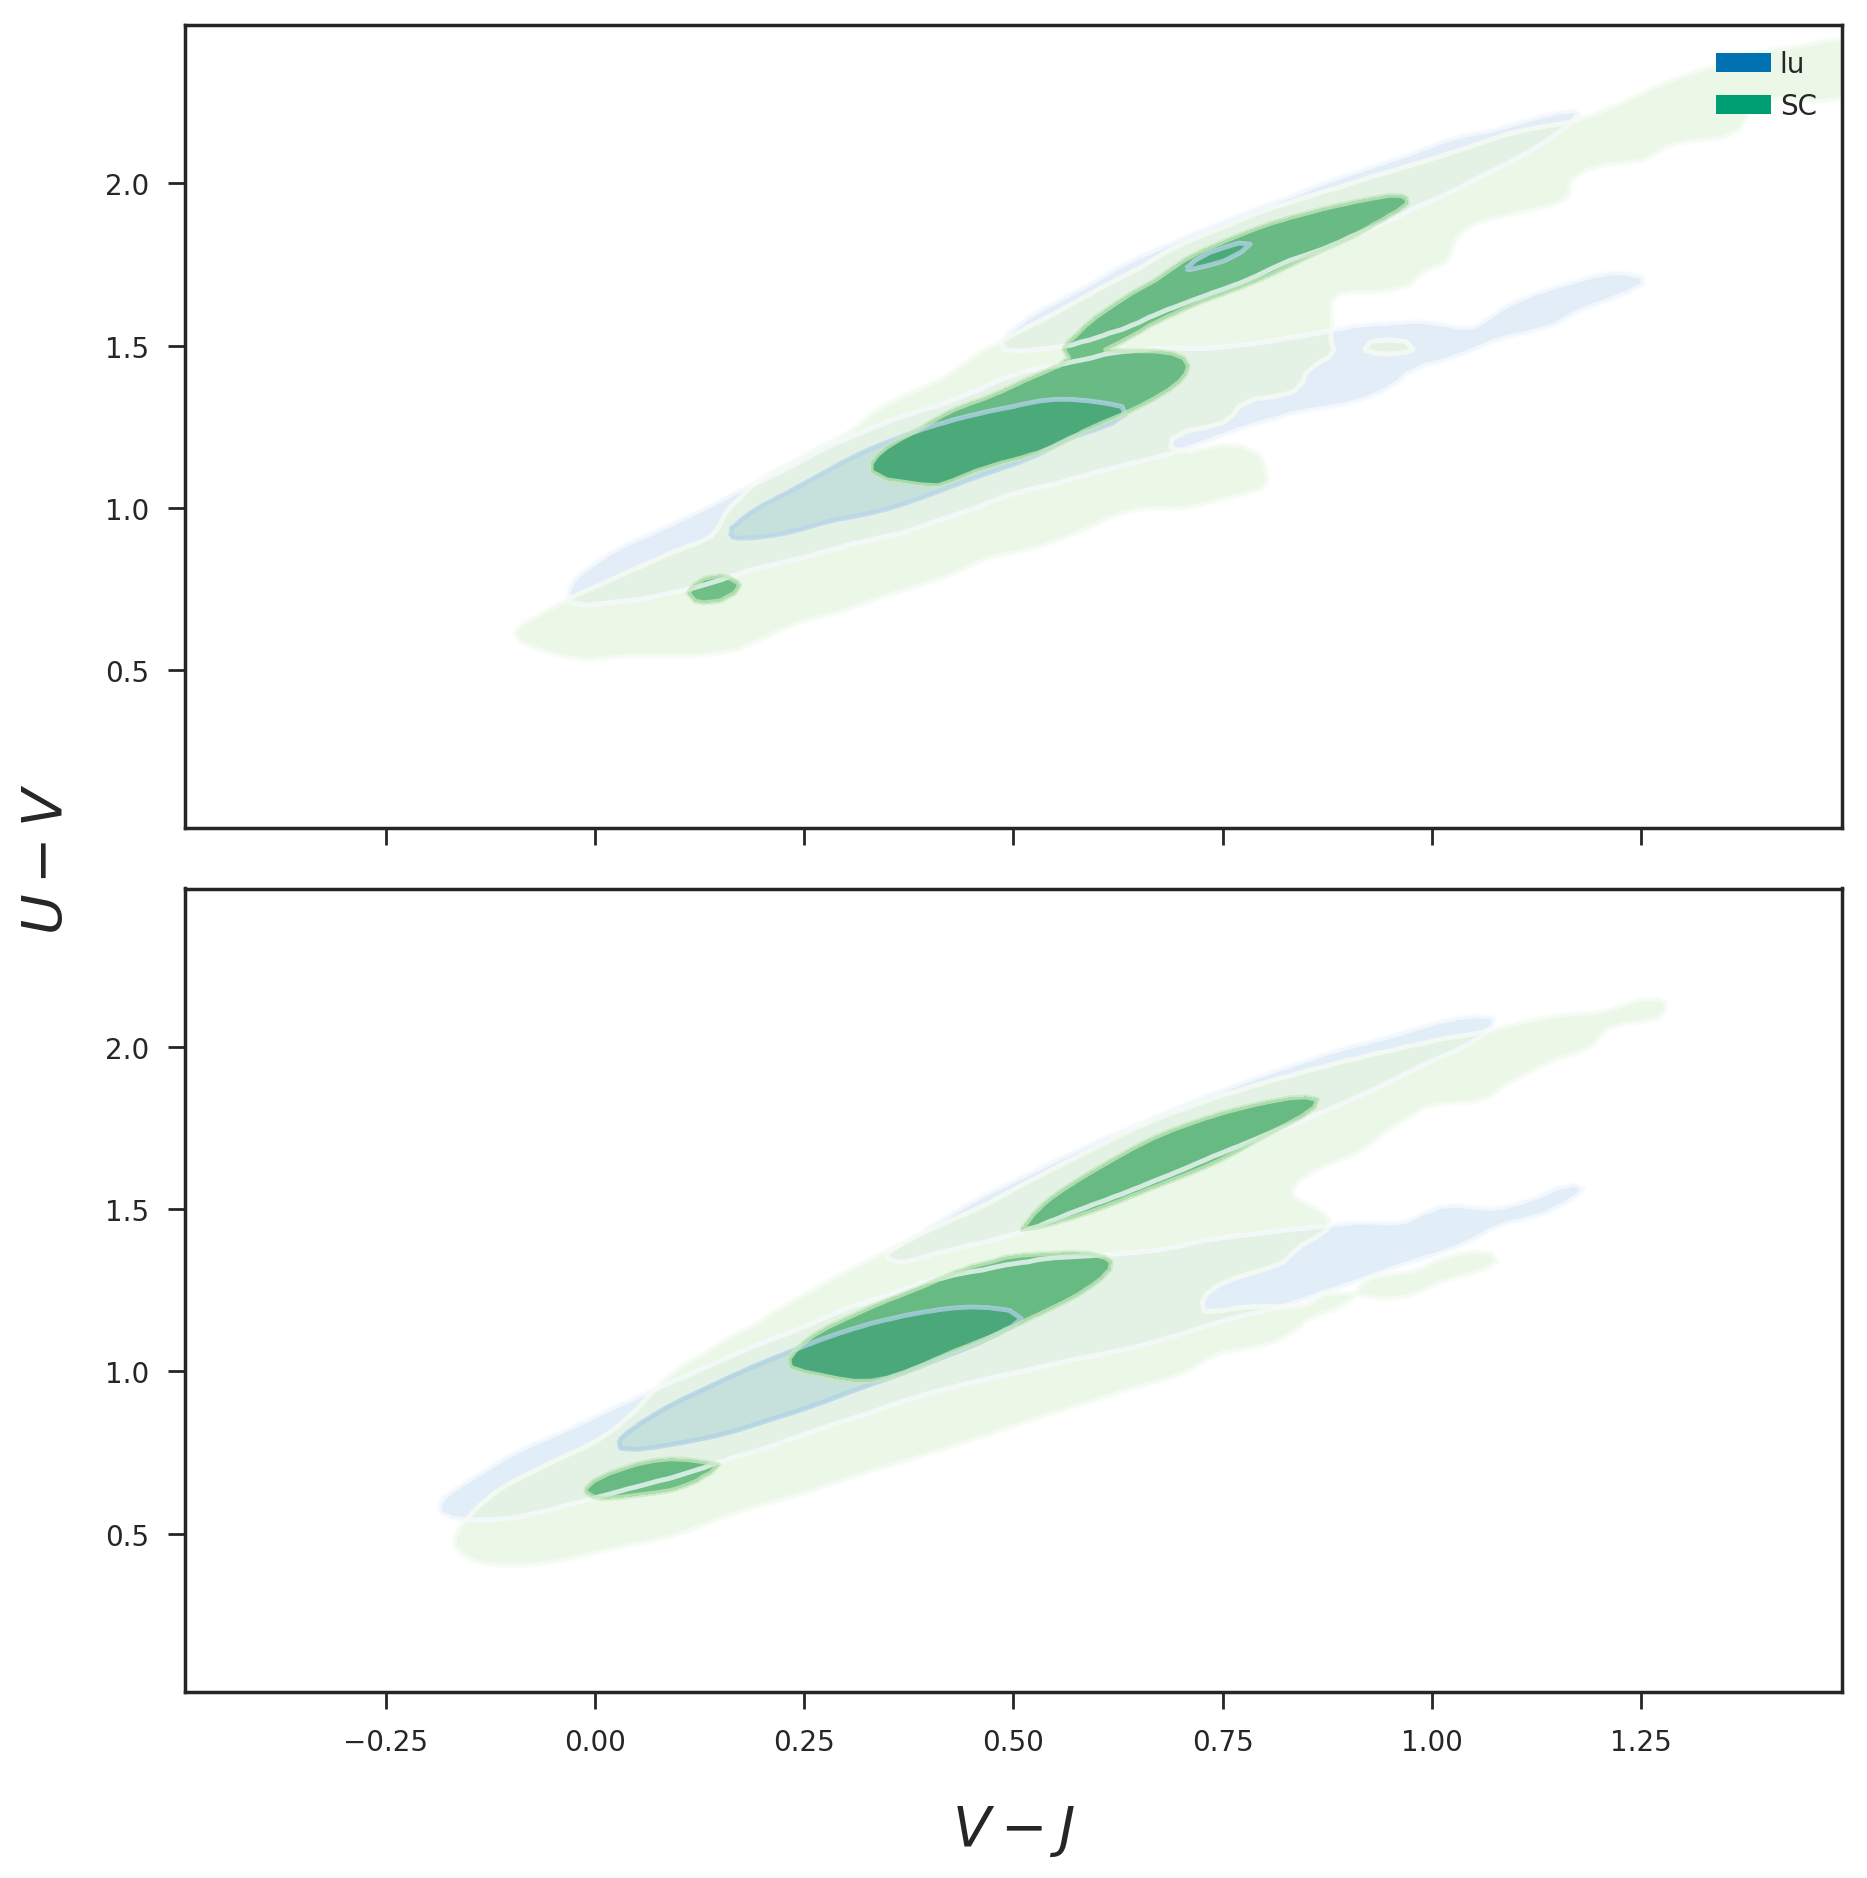

In [34]:
variables = ['redshift_true', 'Mag_true_dust_V_z0', ['Mag_true_dust_U_z0', 'Mag_true_dust_V_z0'], ['Mag_true_dust_V_z0', 'Mag_true_dust_J_z0']]
labels    = ['redshift_true', 'Mag_true_dust_V_z0', r'$U-V$', r'$V-J$' ]
operations = [None, None, lambda x, y: x-y, lambda x, y: x-y]
plot_axes = [2,3]

Nbins    = [2, 1, 100, 100]
bin_lo   = [0.0, -25, 0, -0.5]
bin_hi   = [1.0, -17, 2.5, 1.5]
logbins  = [False, False, False, False]


test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi,
                      logbins=logbins, norm_by=([0], 'volume'))

c = test.run_on_single_catalog(lu_gc, 'lu', './')
#c = test.run_on_single_catalog(sage_gc, 'sage', './')
c = test.run_on_single_catalog(sc_gc, 'SC', './')

test.finalize_plot()


[array([0, 1])]
[array([0, 1])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


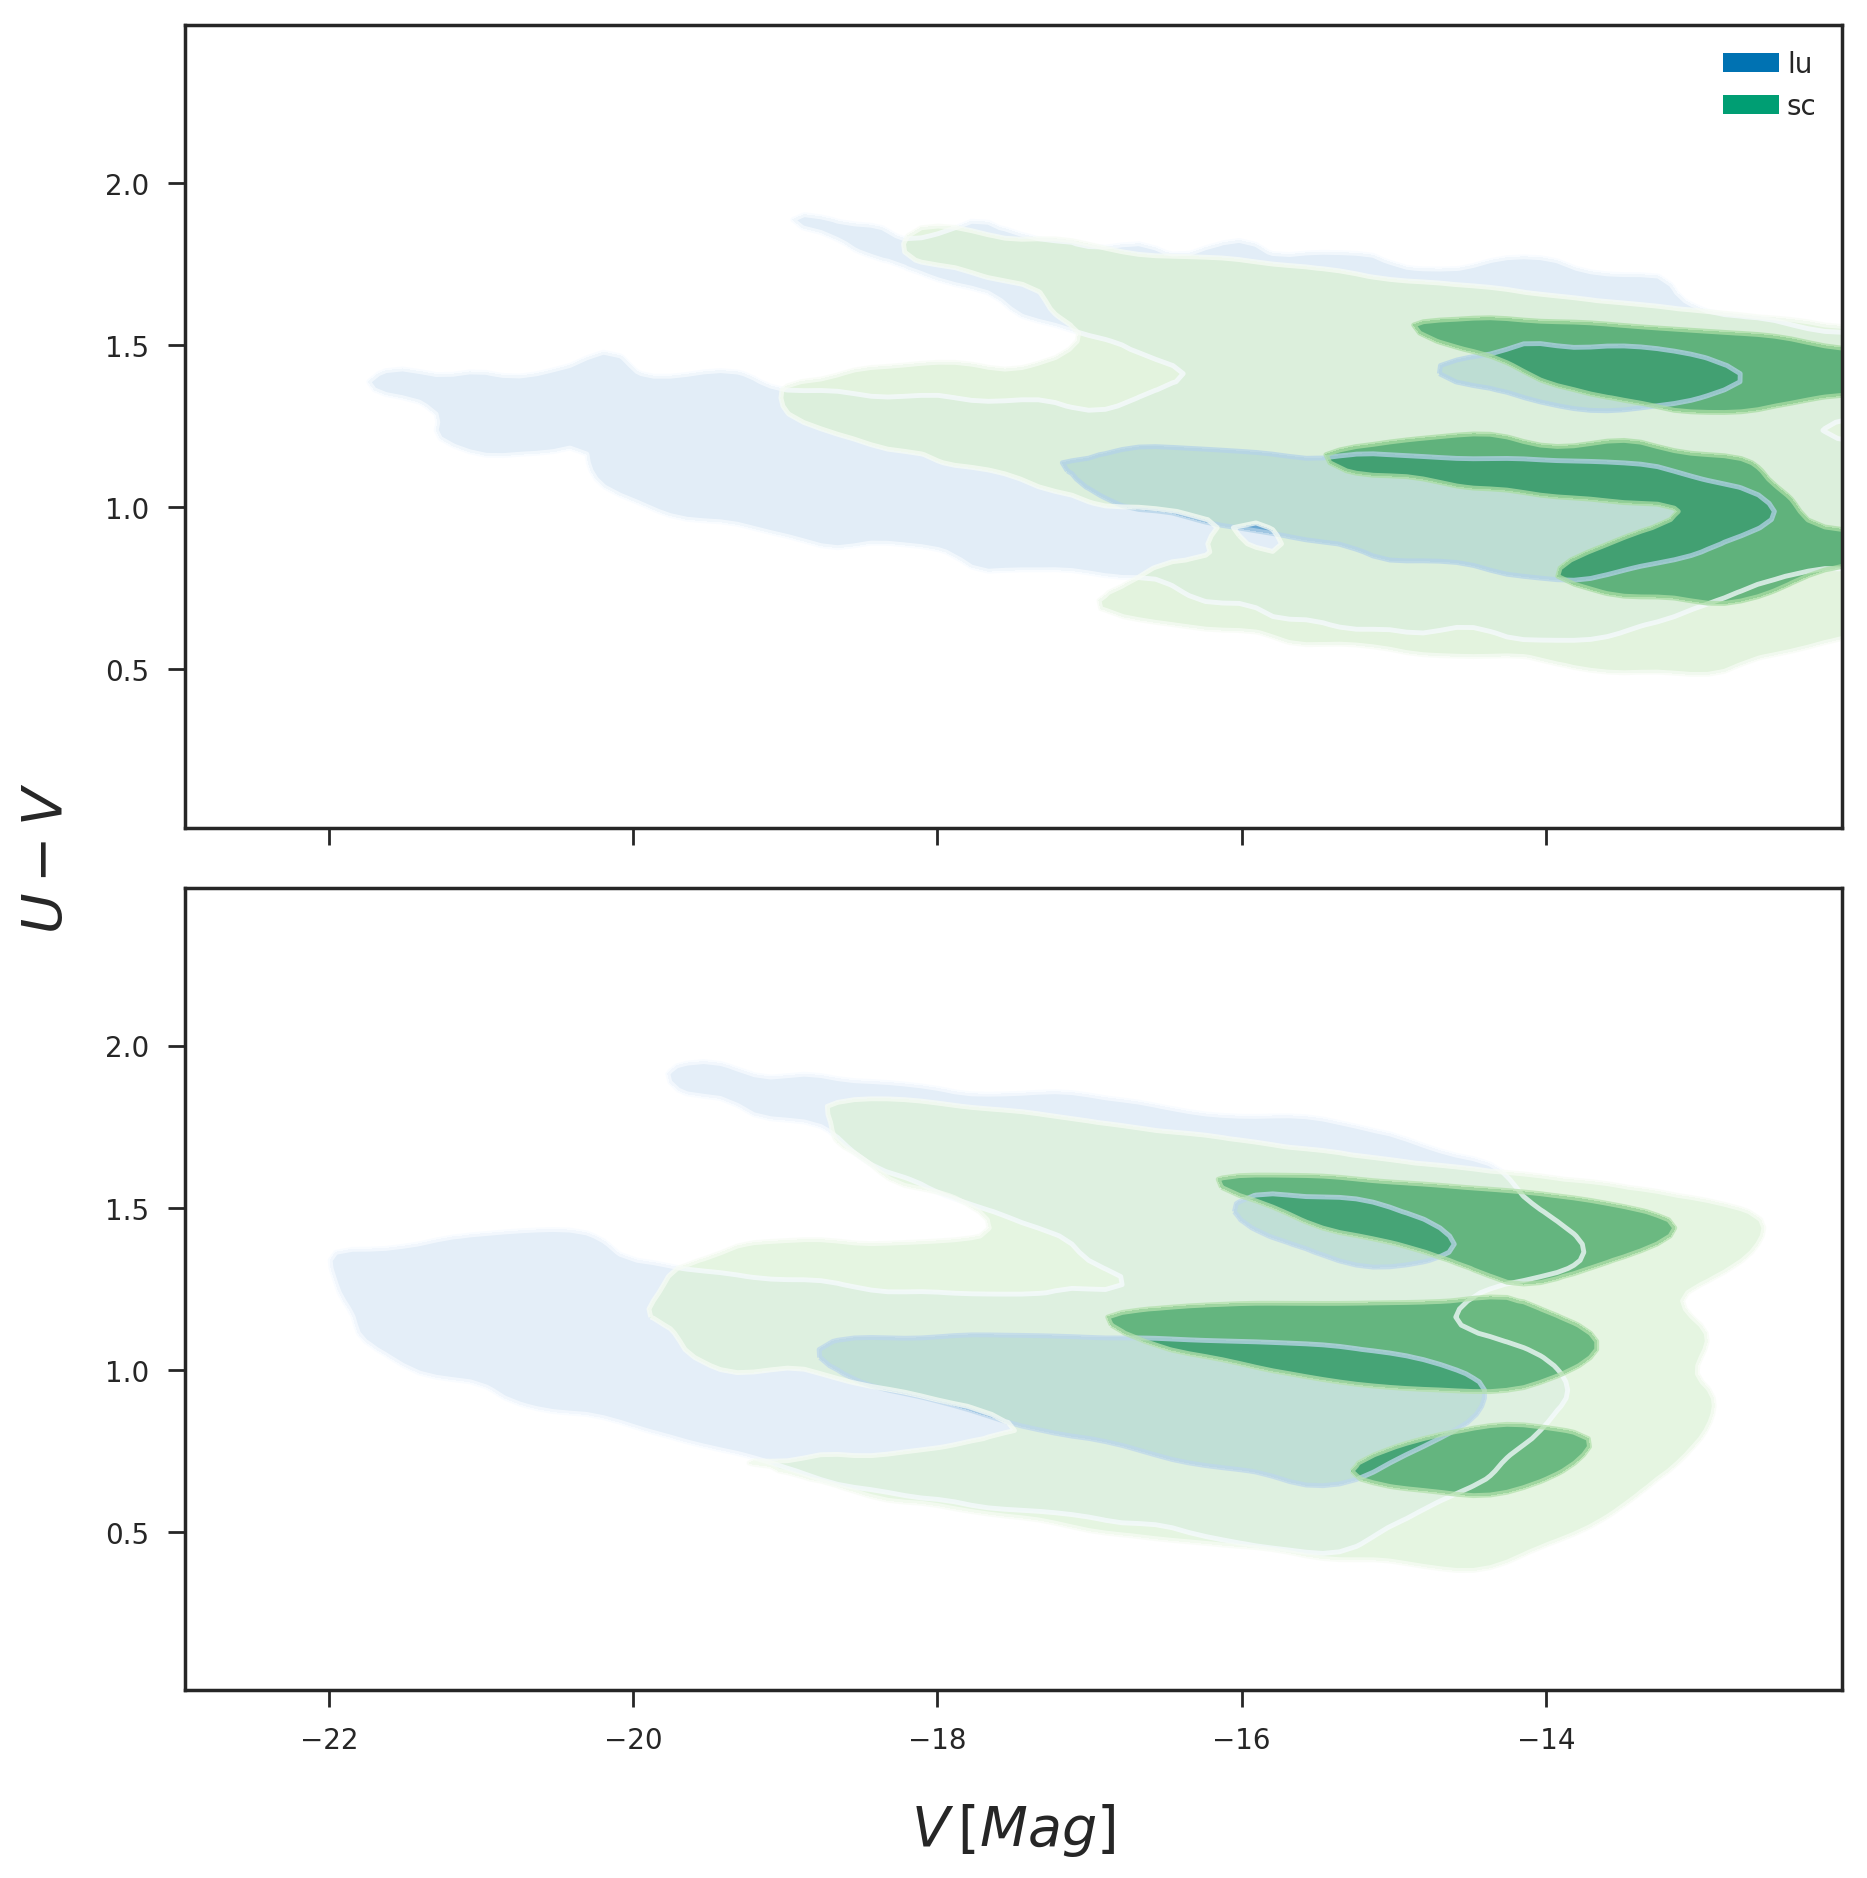

In [35]:
variables = ['redshift_true', ['Mag_true_dust_U_z0', 'Mag_true_dust_V_z0'], 'Mag_true_dust_V_z0']
labels    = ['redshift_true', r'$U-V$', r'$V\/[Mag]$' ]
operations = [None, lambda x, y: x-y, None]
plot_axes = [1,2]

Nbins    = [2, 100, 100]
bin_lo   = [0.0, 0, -23]
bin_hi   = [1.0, 2.5, -12]
logbins  = [False, False, False]


test = DistributionND(variables, plot_axes, operations=operations, labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi, logbins=logbins)

c = test.run_on_single_catalog(lu_gc, 'lu', './')
c = test.run_on_single_catalog(sc_gc, 'sc', './')

test.finalize_plot()


[  4.44745578  19.71687796  64.08483176]
[  9.5186522   33.58626683  97.11553712]
[  11.9199803    61.95063233  155.86926026]
[  27.54042176  118.92093163  244.98264334]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


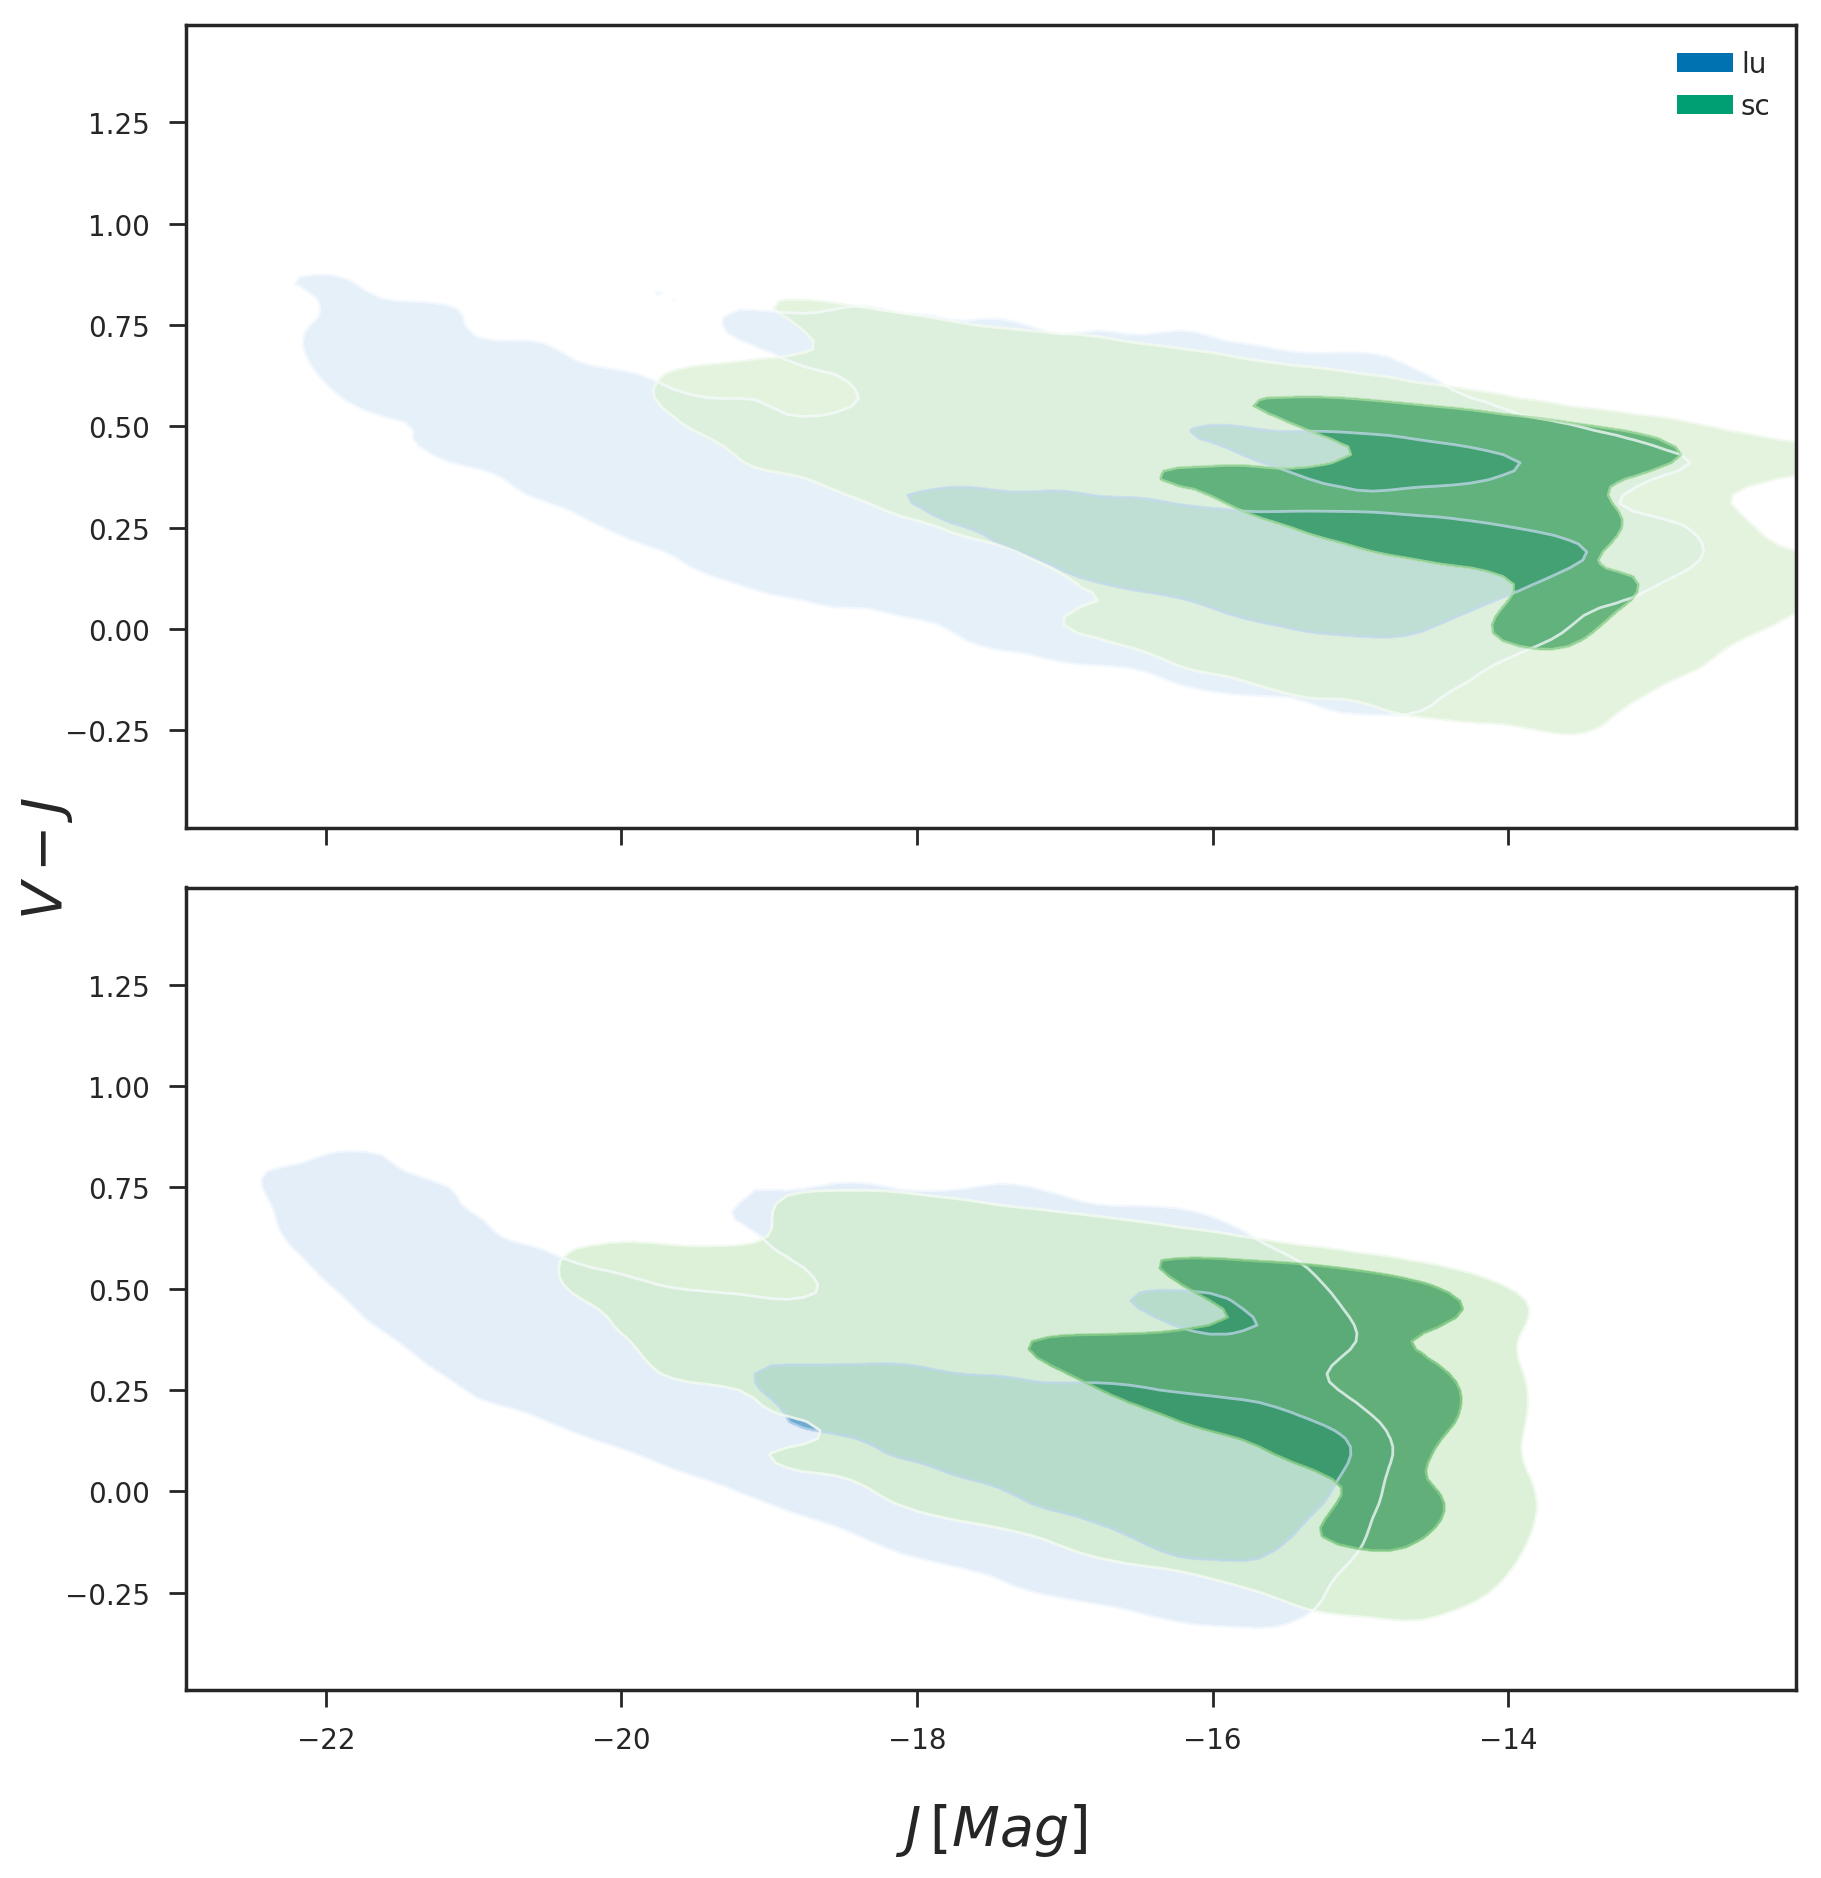

In [31]:
variables = ['redshift_true', ['Mag_true_dust_V_z0', 'Mag_true_dust_J_z0'], 'Mag_true_dust_J_z0']
labels    = ['redshift_true', r'$V-J$', r'$J\/[Mag]$' ]
operations = [None, lambda x, y: x-y, None]
plot_axes = [1,2]

Nbins    = [2,100,100]
bin_lo   = [0.25, -0.5, -23]
bin_hi   = [1.25, 1.5, -12]
logbins  = [False, False, False]


test = DistributionND(variables, plot_axes, operations=operations, labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi, logbins=logbins)

c = test.run_on_single_catalog(lu_gc, 'lu', './')
c = test.run_on_single_catalog(sc_gc, 'sc', './')

test.finalize_plot()


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


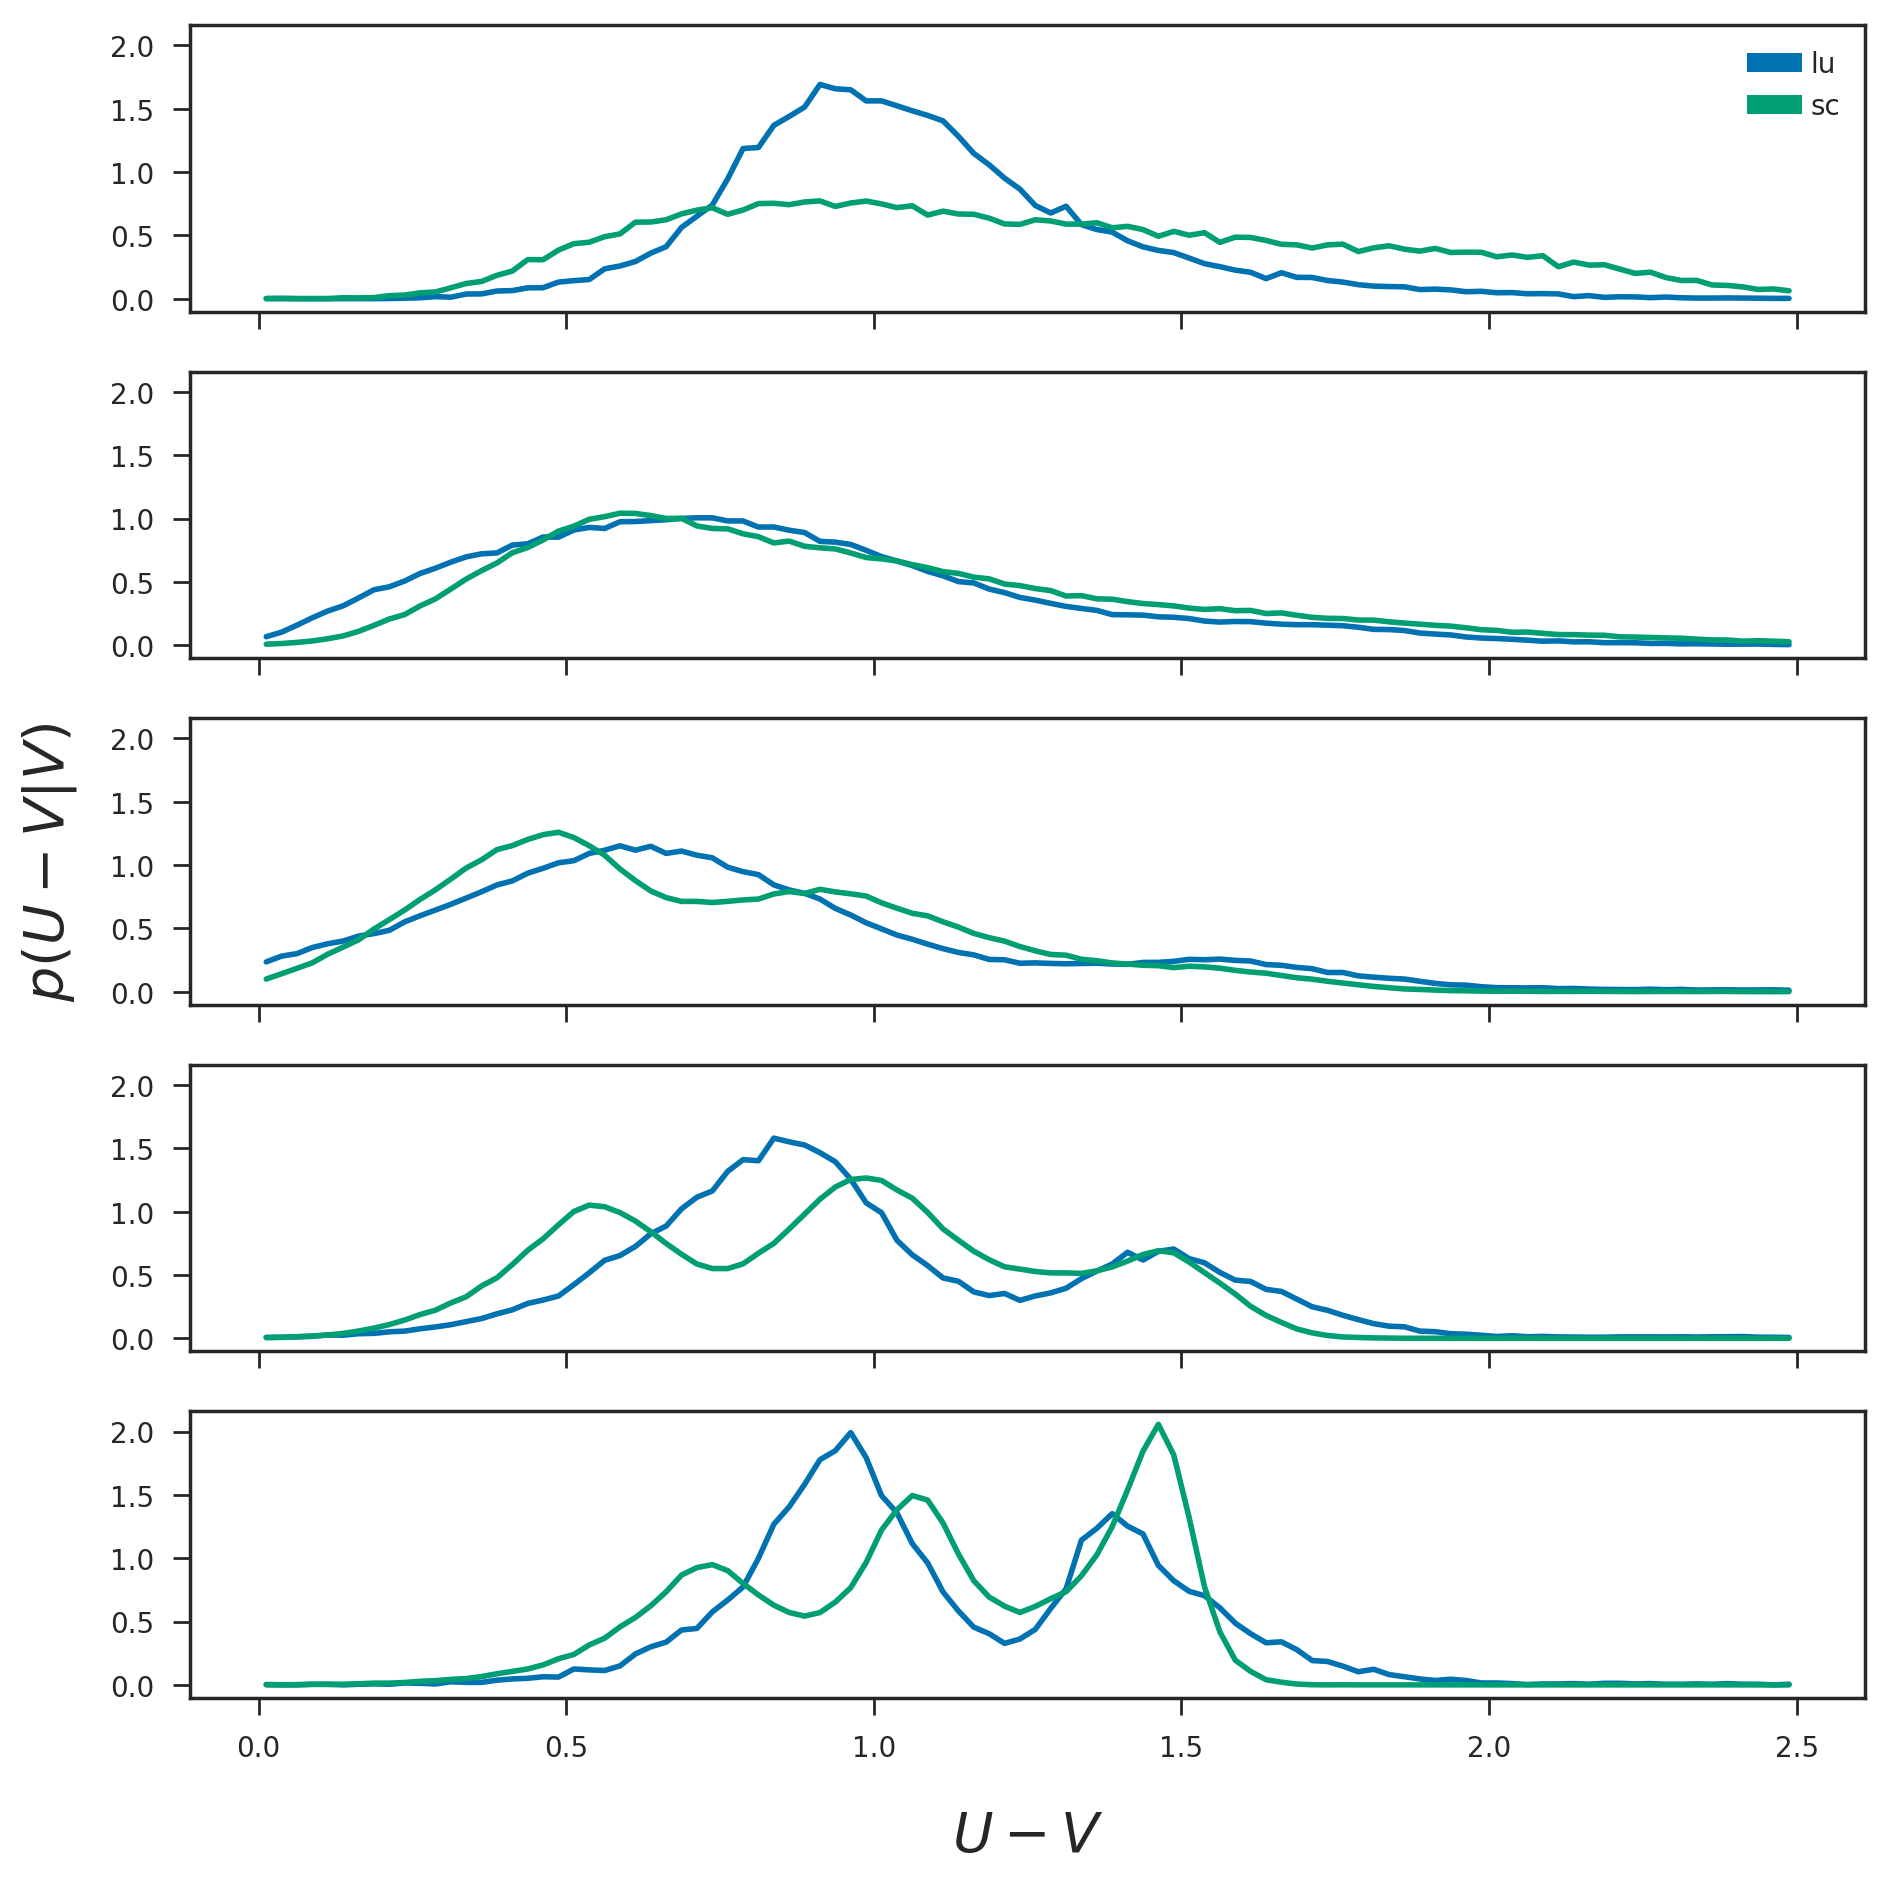

In [80]:
variables = ['Mag_V_z0', ['Mag_true_dust_U_z0', 'Mag_true_dust_V_z0']]
labels    = ['V', r'$U-V$']
operations = [None, lambda x, y: x-y]
plot_axes = [1]

Nbins    = [5,100]
bin_lo   = [-23, 0.]
bin_hi   = [-13, 2.5]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations, labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi, logbins=logbins, norm_by=[(1,), 'prob'])

c = test.run_on_single_catalog(lu_gc, 'lu', './')
#c = test.run_on_single_catalog(sage_gc, 'sage', './')
c = test.run_on_single_catalog(sc_gc, 'sc', './')

test.finalize_plot(ylabel=r'$p(U-V|V)$')


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


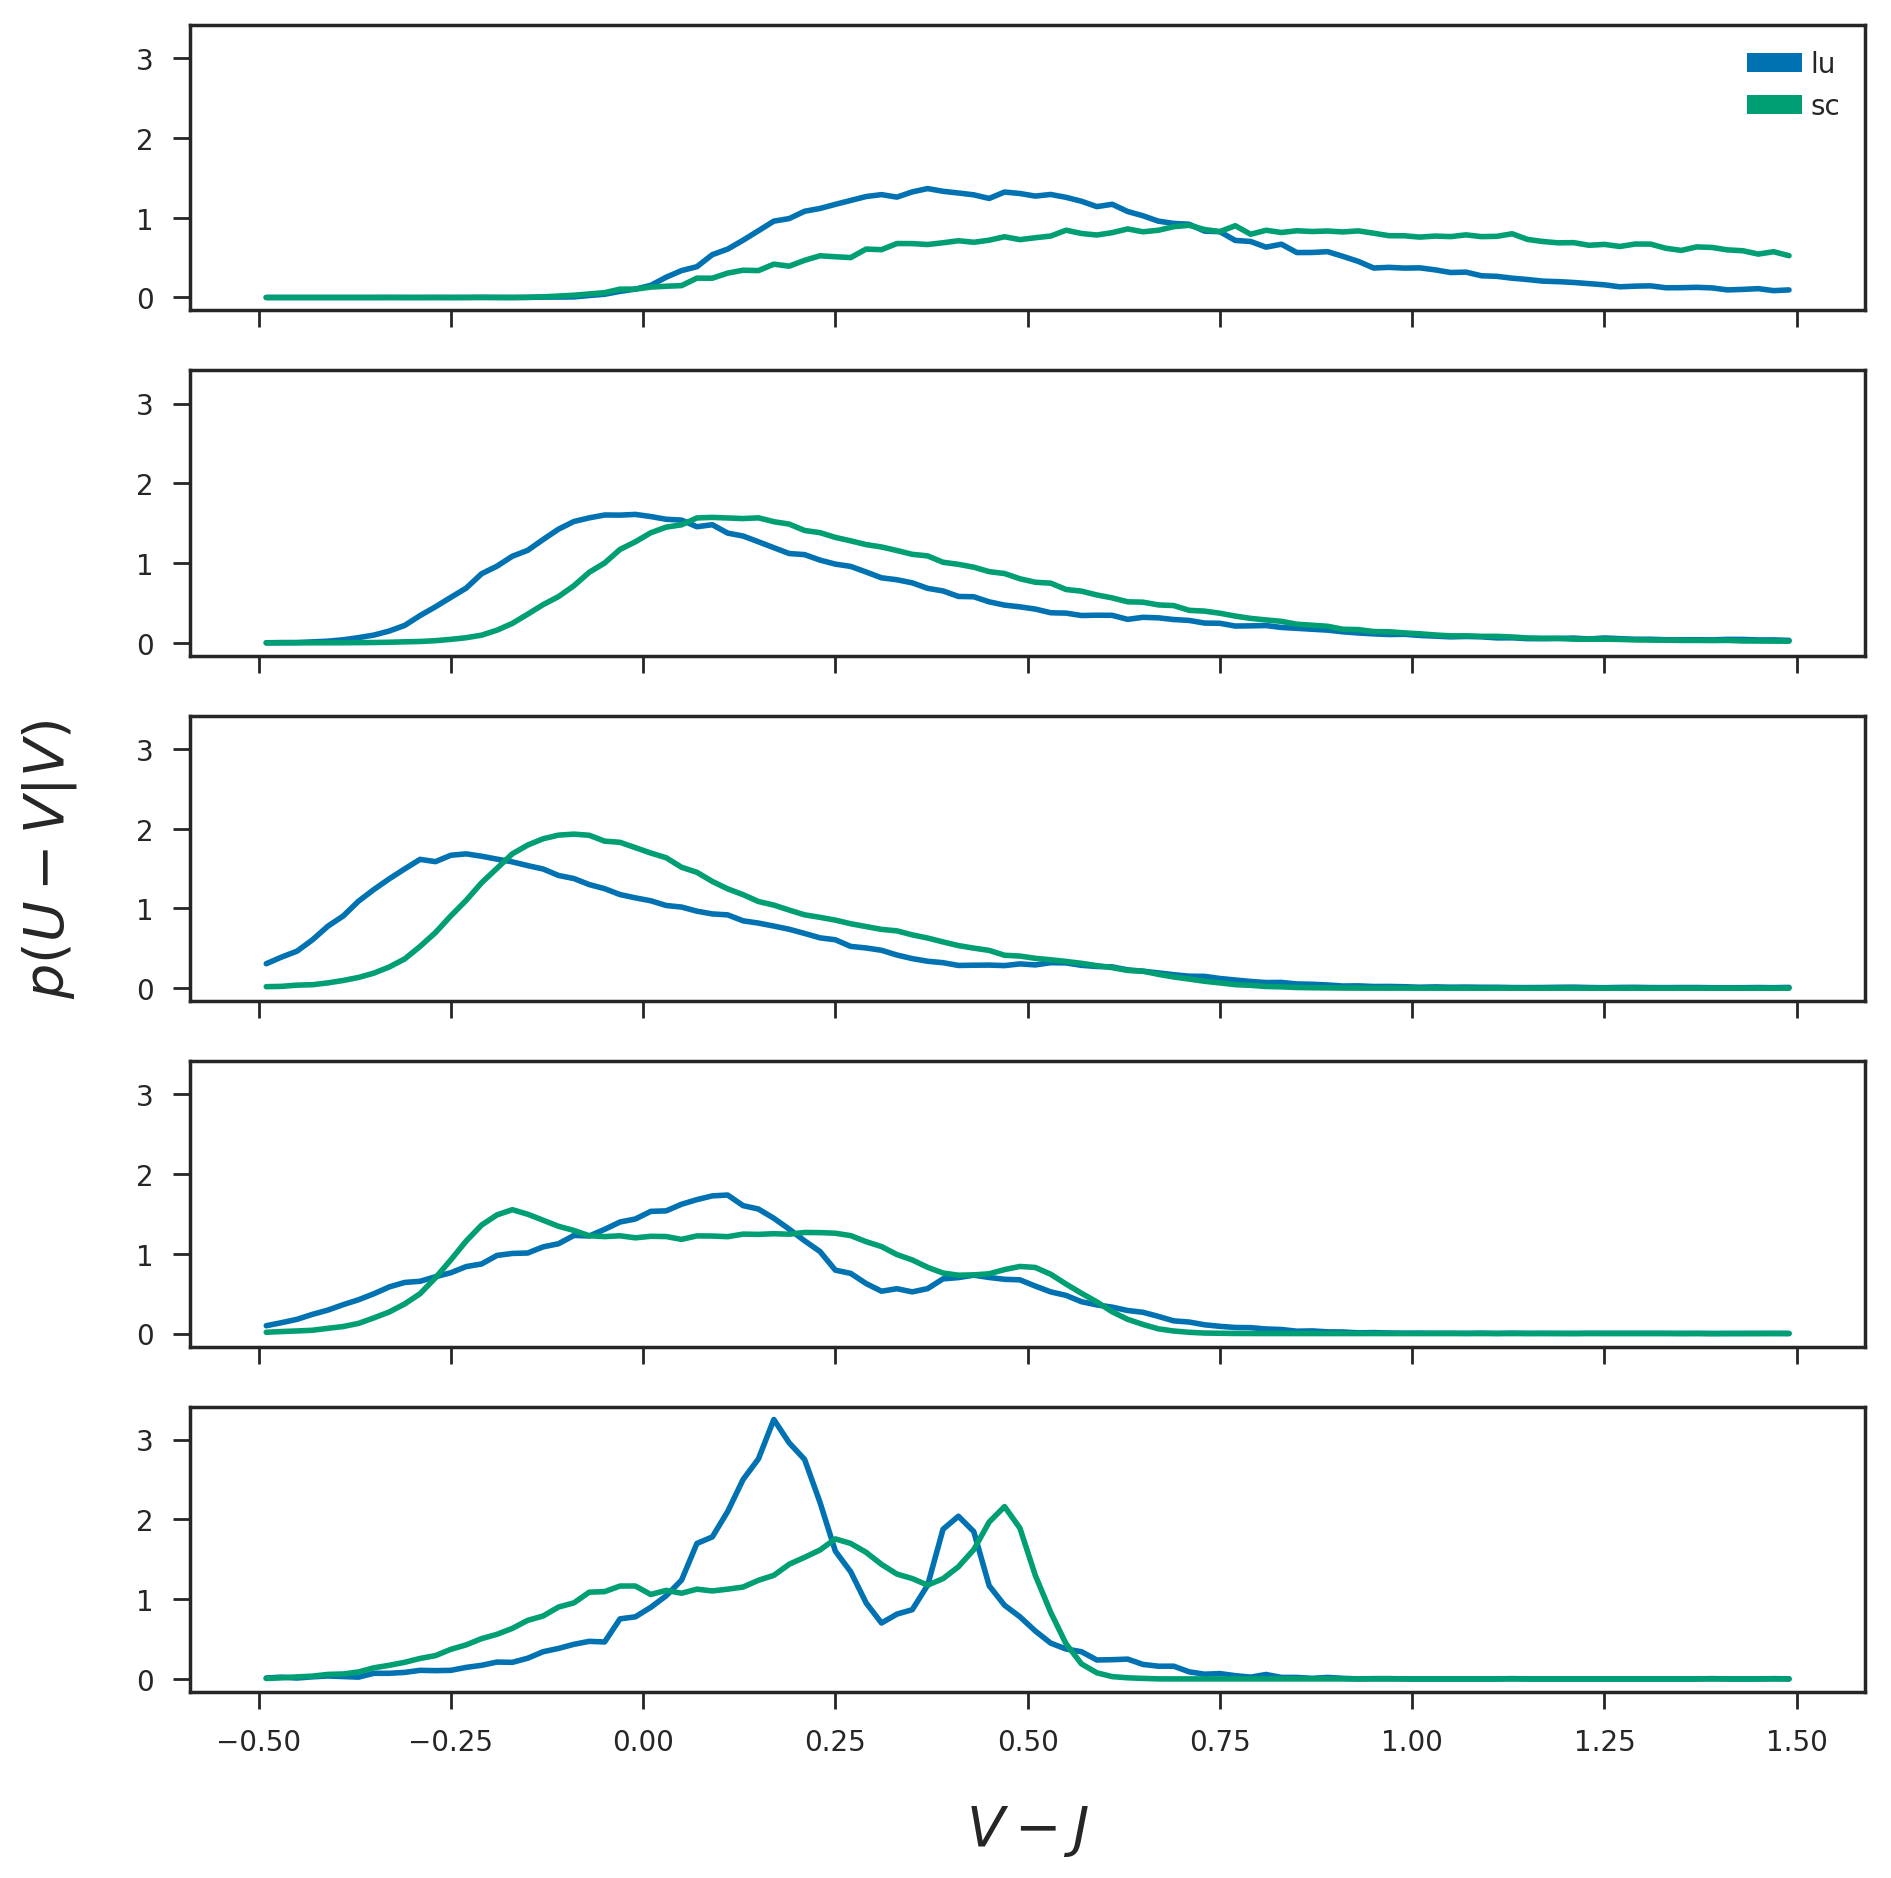

In [79]:
variables = ['Mag_J_z0', ['Mag_true_dust_V_z0', 'Mag_true_dust_J_z0']]
labels    = ['J', r'$V-J$']
operations = [None, lambda x, y: x-y]
plot_axes = [1]

Nbins    = [5,100]
bin_lo   = [-23, -0.5]
bin_hi   = [-13, 1.5]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations, labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi, logbins=logbins, norm_by=[(1,), 'prob'])

c = test.run_on_single_catalog(lu_gc, 'lu', './')
#c = test.run_on_single_catalog(sage_gc, 'sage', './')
c = test.run_on_single_catalog(sc_gc, 'sc', './')

test.finalize_plot(ylabel=r'$p(U-V|V)$')


[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


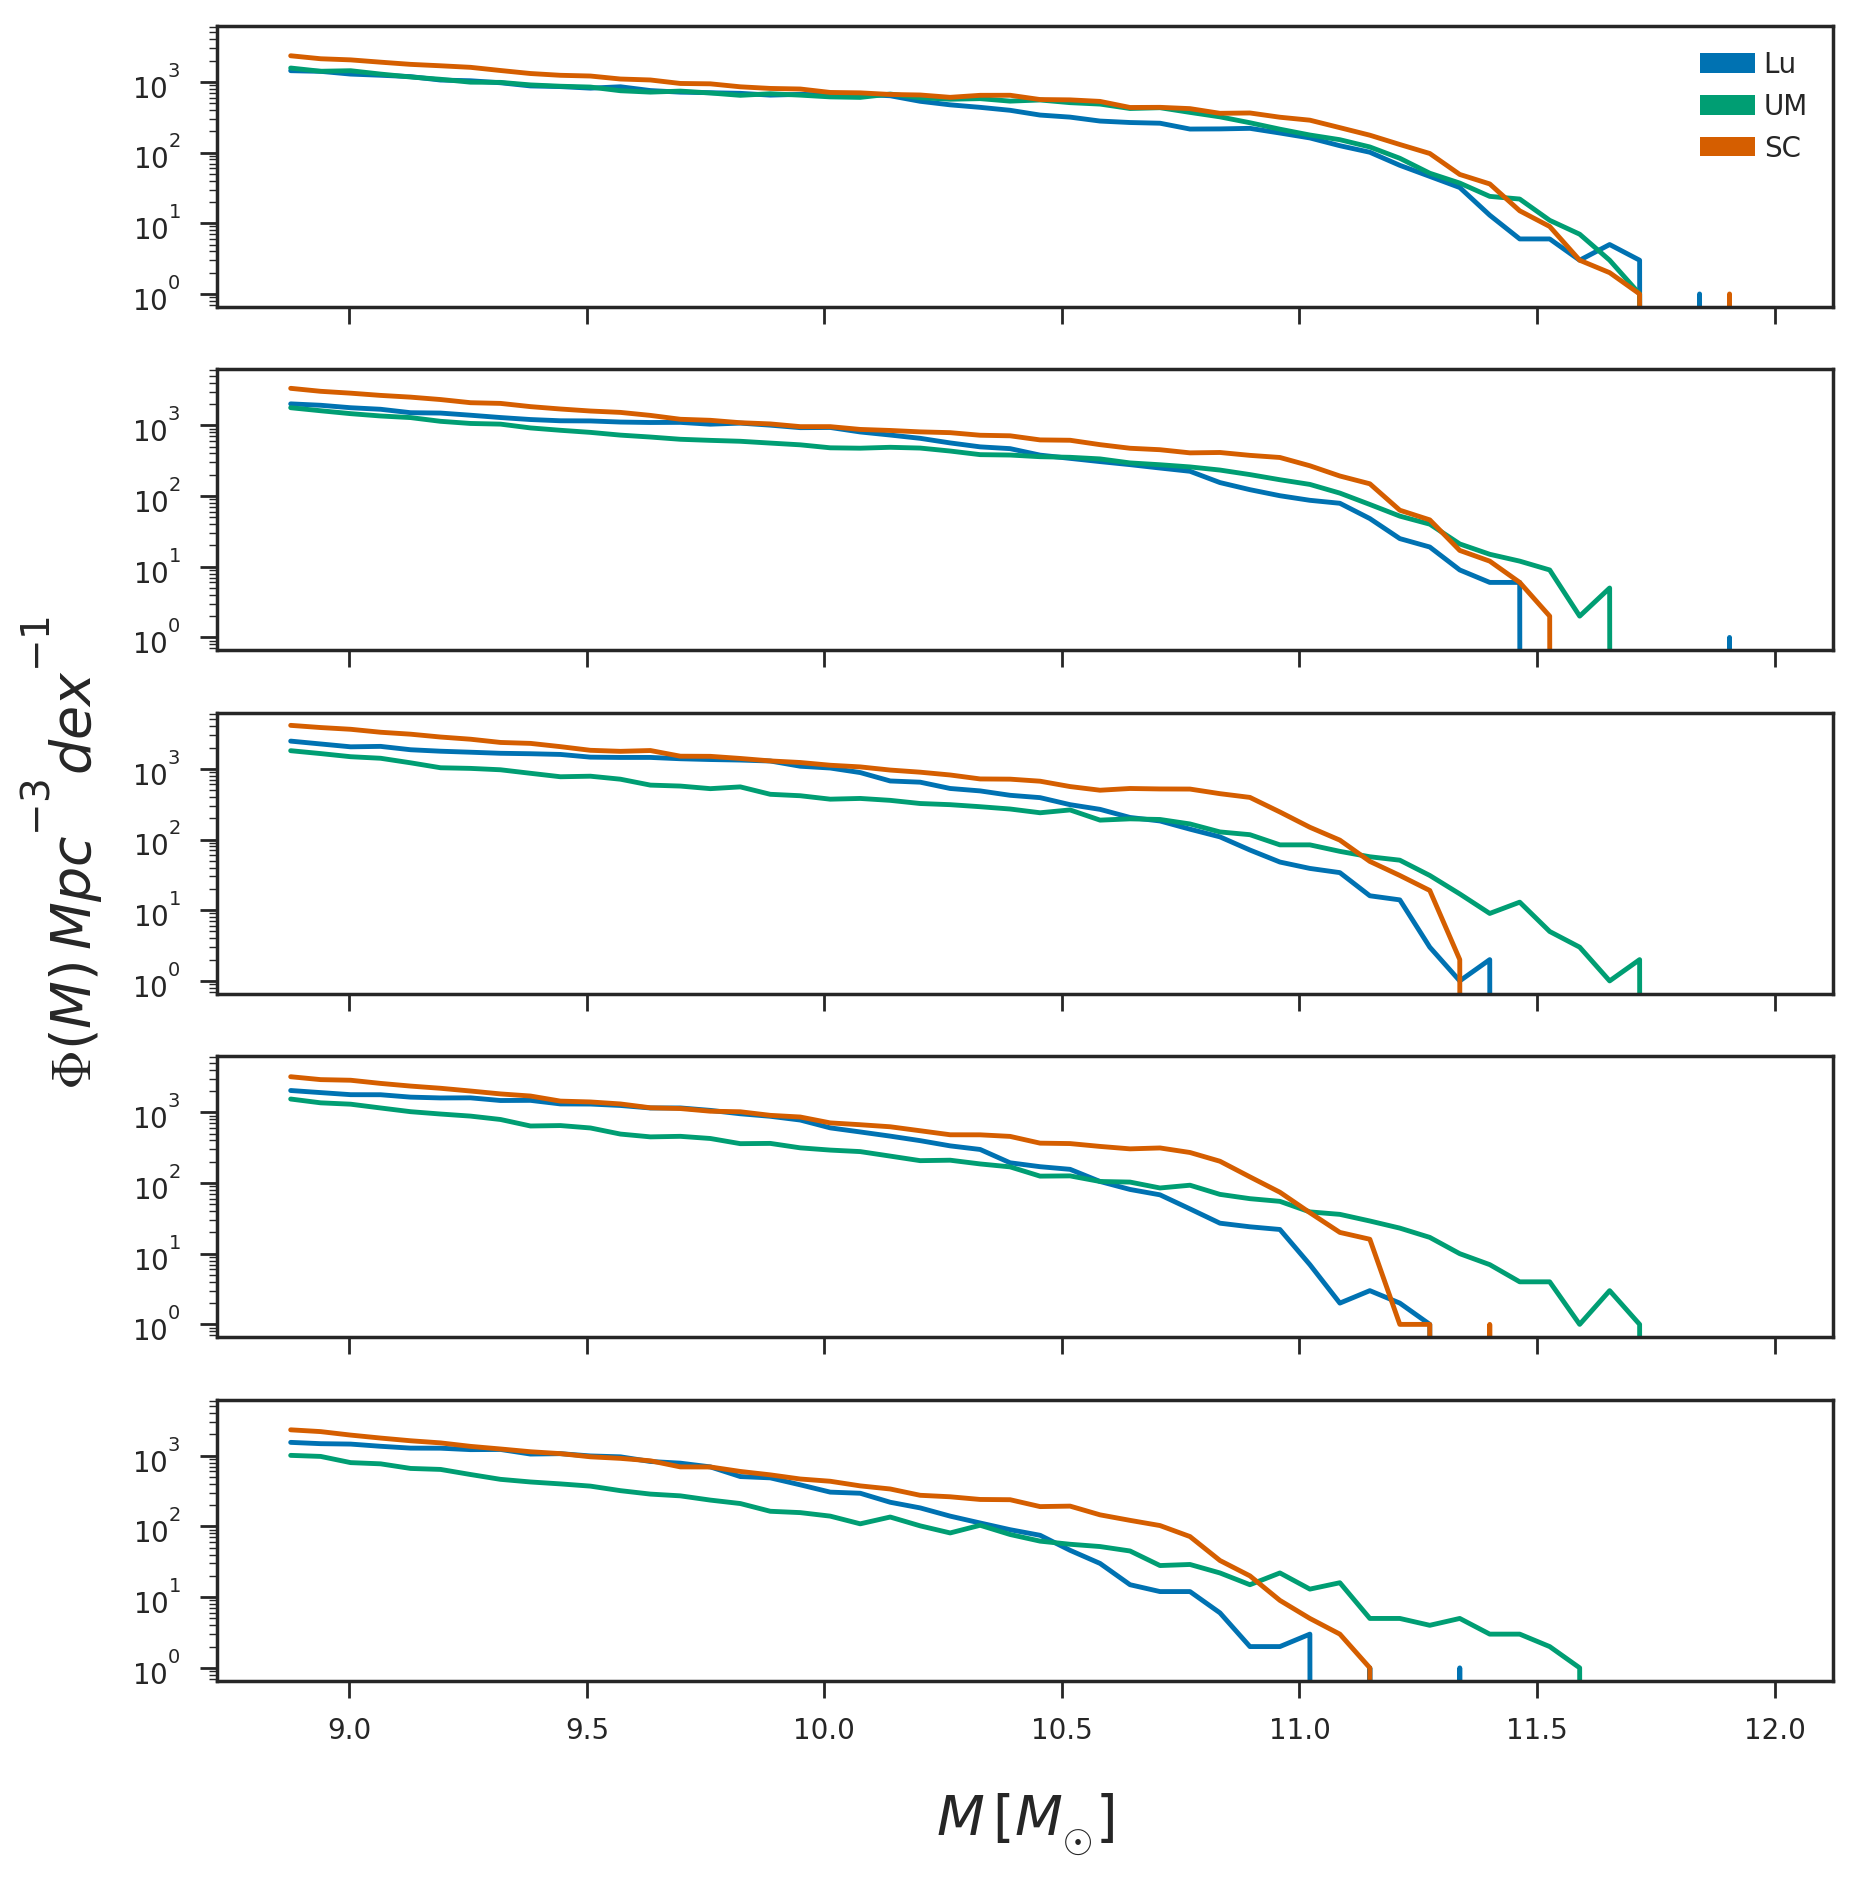

In [37]:
variables = ['redshift_true', ['stellar_mass']]
labels    = ['redshift_true', r'$M\/ [M_{\odot}]$']
operations = [None, lambda x: x*10**10]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.5, 7e8]
bin_hi   = [3.5, 1e12]
logbins  = [False, True]


test = DistributionND(variables, plot_axes, operations=operations, labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi, logbins=logbins)

c = test.run_on_single_catalog(lu_gc, 'Lu', './')
c = test.run_on_single_catalog(um_gc, 'UM', './')
c = test.run_on_single_catalog(sc_gc, 'SC', './')

test.finalize_plot(r'$\Phi(M)\/ Mpc^{-3} dex^{-1}$', yscale='log')


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:182: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:183: RuntimeWarning: invalid value encountered in true_divide


Bin all zero
Bin all zero
Bin all zero


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


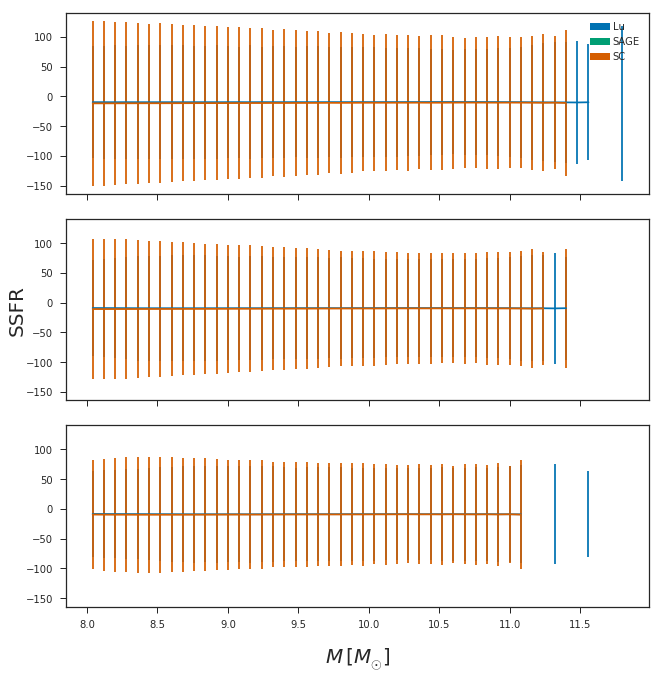

In [22]:
variables = ['redshift_true', ['sfr_ave', r'$M\/ [M_{\odot}]$'], r'$M\/ [M_{\odot}]$']
labels    = ['redshift_true', r'SSFR', r'$M\/ [M_{\odot}]$']
operations = [None, lambda x, y : x / y, None]
plot_axes = [1,2]

Nbins    = [3, 50, 50]
bin_lo   = [0.5, 1e-14, 1e8]
bin_hi   = [3.5, 1e-7, 1e12]
logbins  = [False, True, True]


test = DistributionND(variables, plot_axes, operations=operations, labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi, logbins=logbins)

c = test.run_on_single_catalog(lu_gc, 'Lu', './', mean=True)
c = test.run_on_single_catalog(sage_gc, 'SAGE', './', mean=True)
c = test.run_on_single_catalog(sc_gc, 'SC', './', mean=True)

test.finalize_plot(r'$\Phi(M)\/ Mpc^{-3} dex^{-1}$')


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:182: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:183: RuntimeWarning: invalid value encountered in true_divide


Bin all zero
Bin all zero
Bin all zero


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


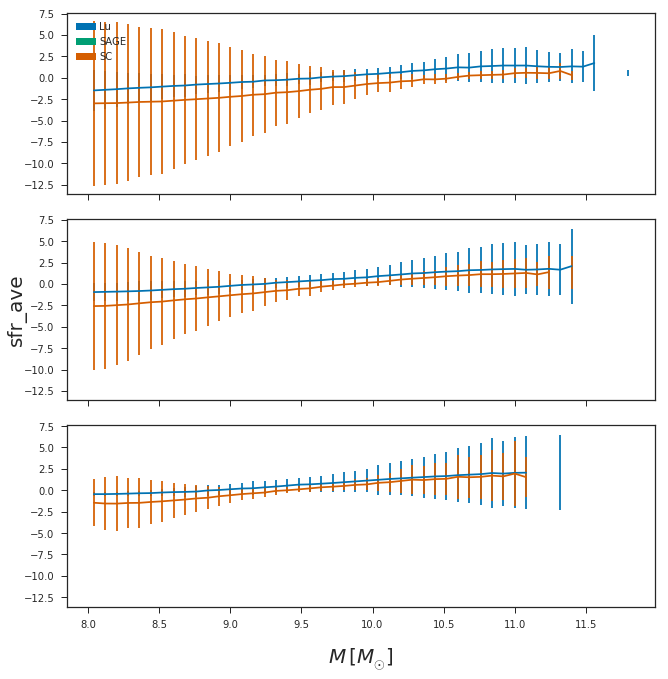

In [23]:
variables = ['redshift_true', 'sfr_ave', r'$M\/ [M_{\odot}]$']
labels    = ['redshift_true', 'sfr_ave', r'$M\/ [M_{\odot}]$']
operations = [None, None, None]
plot_axes = [1,2]

Nbins    = [3, 50, 50]
bin_lo   = [0.5, 1e-4, 1e8]
bin_hi   = [3.5, 1000, 1e12]
logbins  = [False, True, True]


test = DistributionND(variables, plot_axes, operations=operations, labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi, logbins=logbins)

c = test.run_on_single_catalog(lu_gc, 'Lu', './', mean=True)
c = test.run_on_single_catalog(sage_gc, 'SAGE', './', mean=True)
c = test.run_on_single_catalog(sc_gc, 'SC', './', mean=True)

test.finalize_plot(r'$\Phi(M)\/ Mpc^{-3} dex^{-1}$')


[array([0, 1, 2]), array([0, 1, 2, 3, 4])]
[array([0, 1, 2]), array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:216: RuntimeWarning: invalid value encountered in true_divide


[array([0, 1, 2]), array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


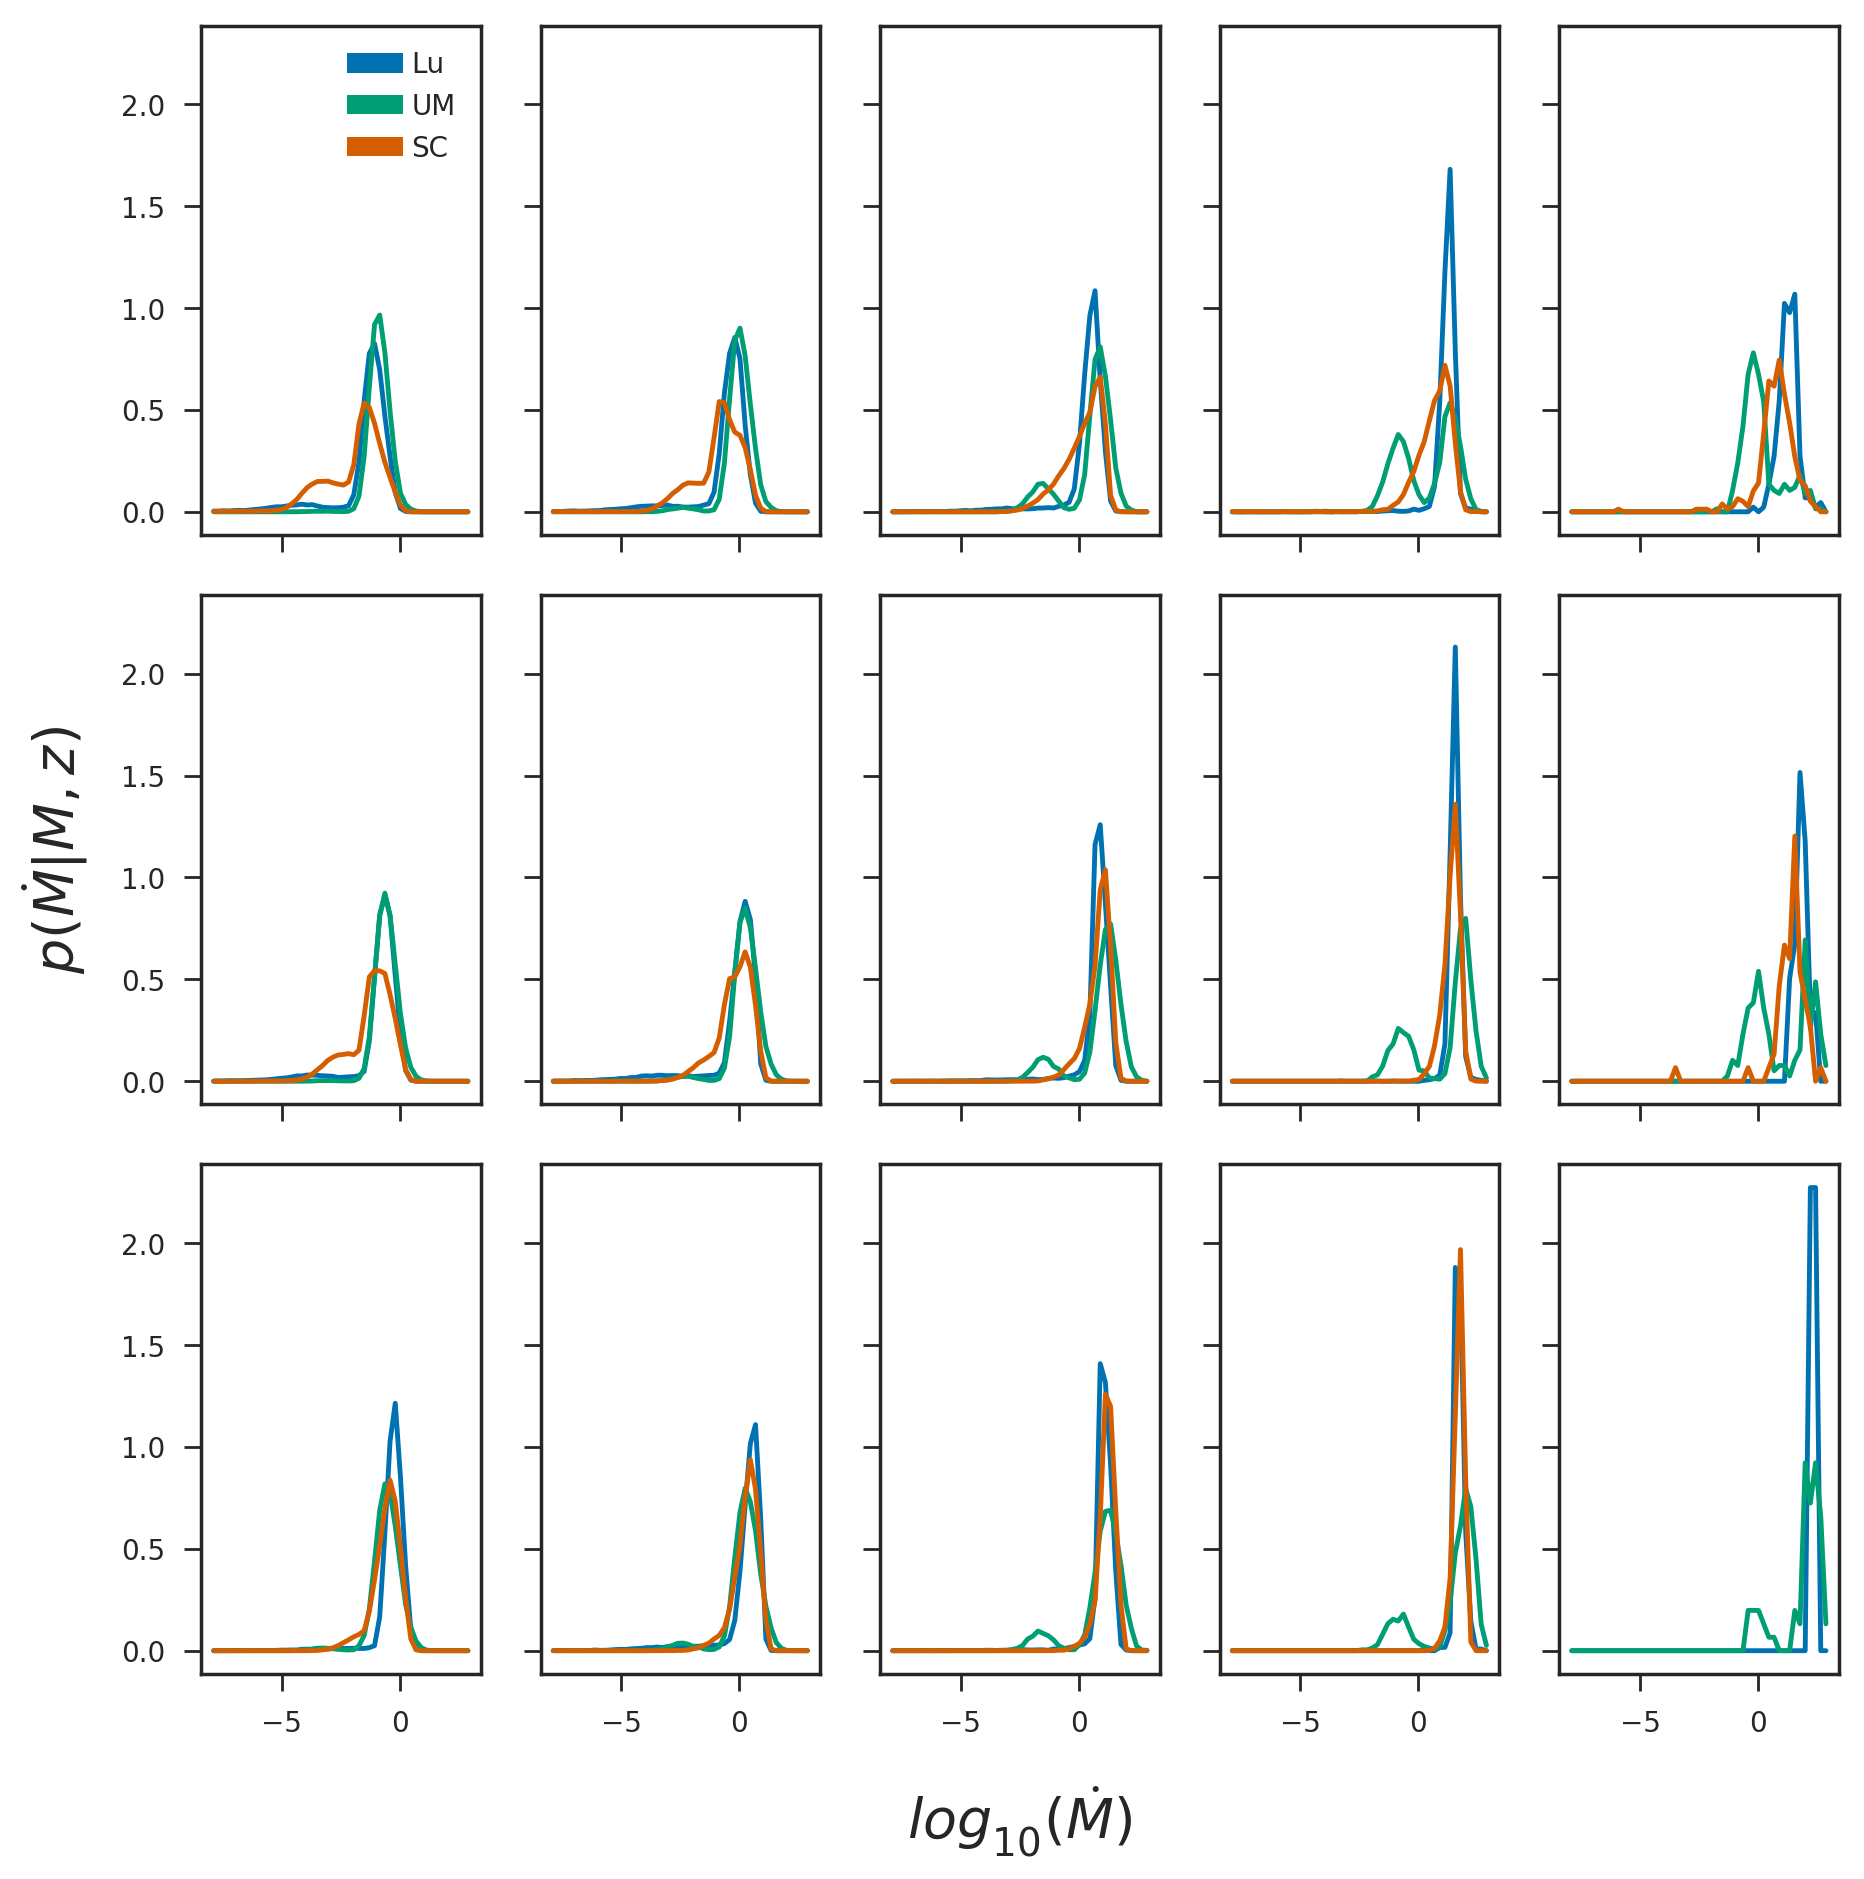

In [5]:
variables = ['redshift_true', 'star_formation_rate', ['stellar_mass']]
labels    = ['redshift_true', r'$log_{10}(\dot{M})$', r'$M\/ [M_{\odot}]$']
operations = [None, None, lambda x : 10**10 * x]
plot_axes = [1]

Nbins    = [3, 50, 5]
bin_lo   = [0.5, 1e-8, 1e8]
bin_hi   = [3.5, 1000, 1e12]
logbins  = [False, True, True]


test = DistributionND(variables, plot_axes, operations=operations, weight_quantity='sfr_ave', labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi, logbins=logbins, norm_by=[(1,), 'prob'])

c = test.run_on_single_catalog(lu_gc, 'Lu', './', mean=True)
c = test.run_on_single_catalog(um_gc, 'UM', './', mean=True)
c = test.run_on_single_catalog(sc_gc, 'SC', './', mean=True)

test.finalize_plot(r'$p(\dot{M} | M, z)$')


## Model-Data Comparisons

[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


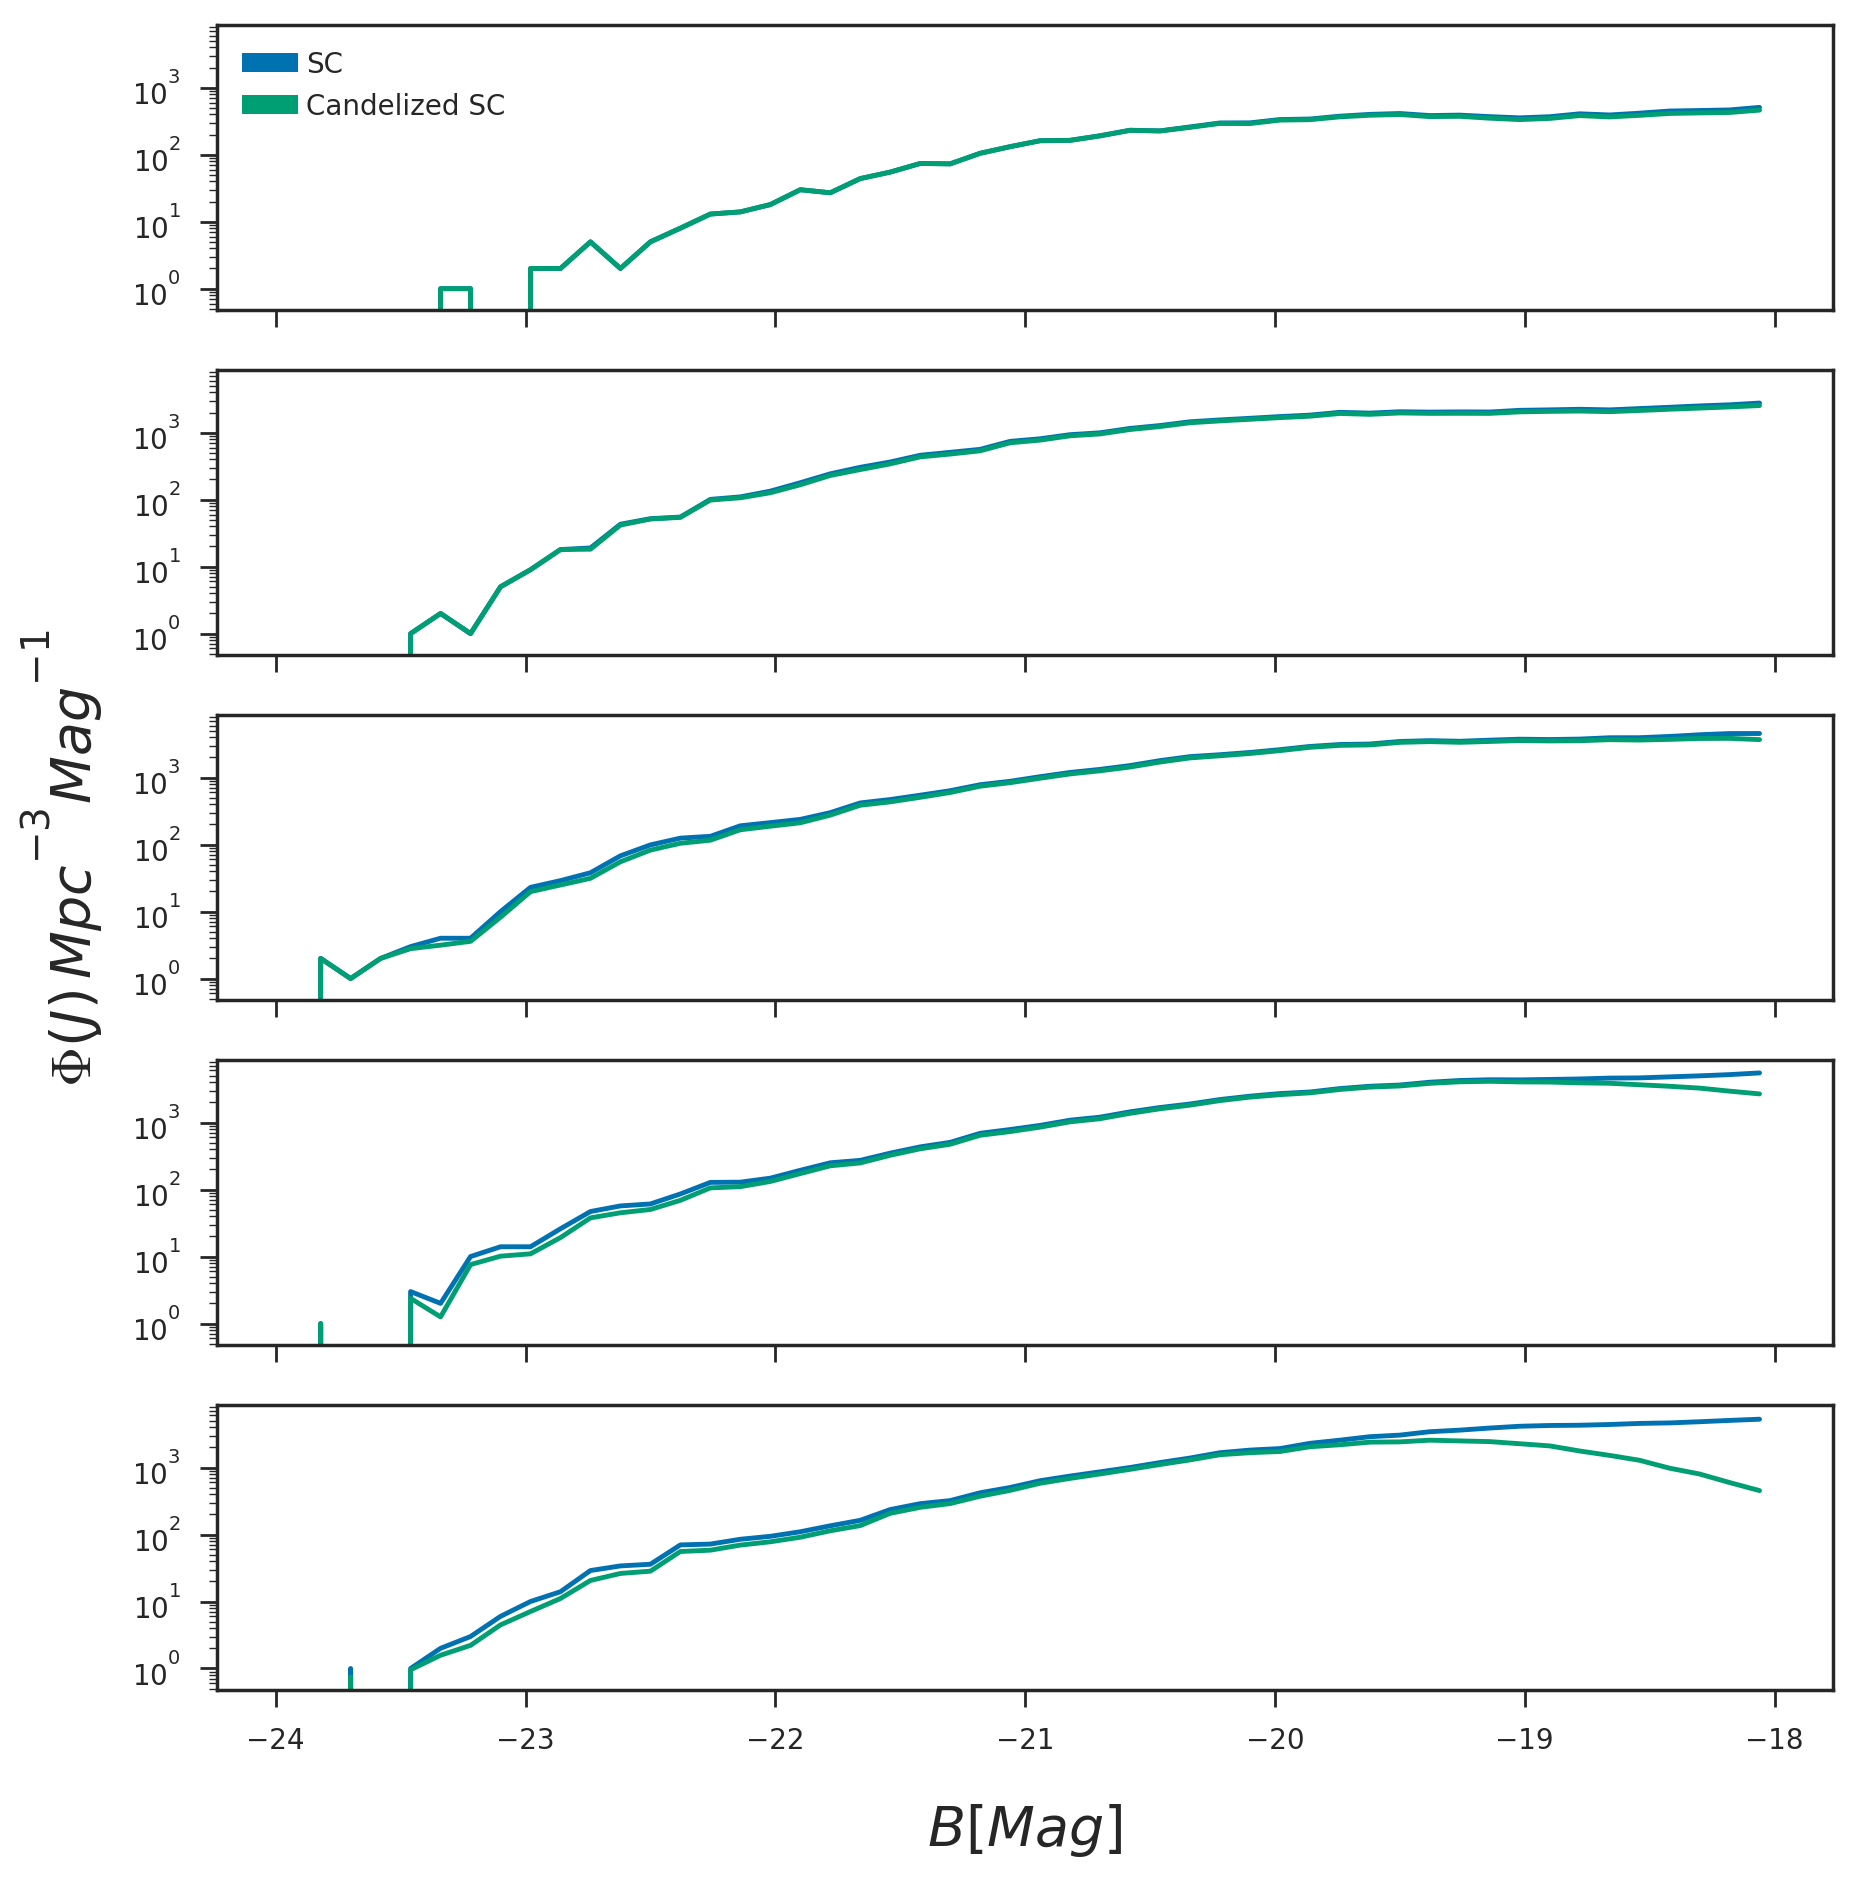

In [45]:
variables = ['redshift_true', 'Mag_true_dust_B_z0']
labels    = ['redshift_true', r'$B [Mag]$']
operations = [None, None]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.0, -24]
bin_hi   = [3.5, -18]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations, labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi, logbins=logbins, weight_quantity='p_detection')

c = test.run_on_single_catalog(scc_gc, 'SC', './', useweights=False)
cc = test.run_on_single_catalog(scc_gc, 'Candelized SC', './', useweights=True)

test.finalize_plot(r'$\Phi(J)\/ Mpc^{-3} Mag^{-1}$', yscale='log')


[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


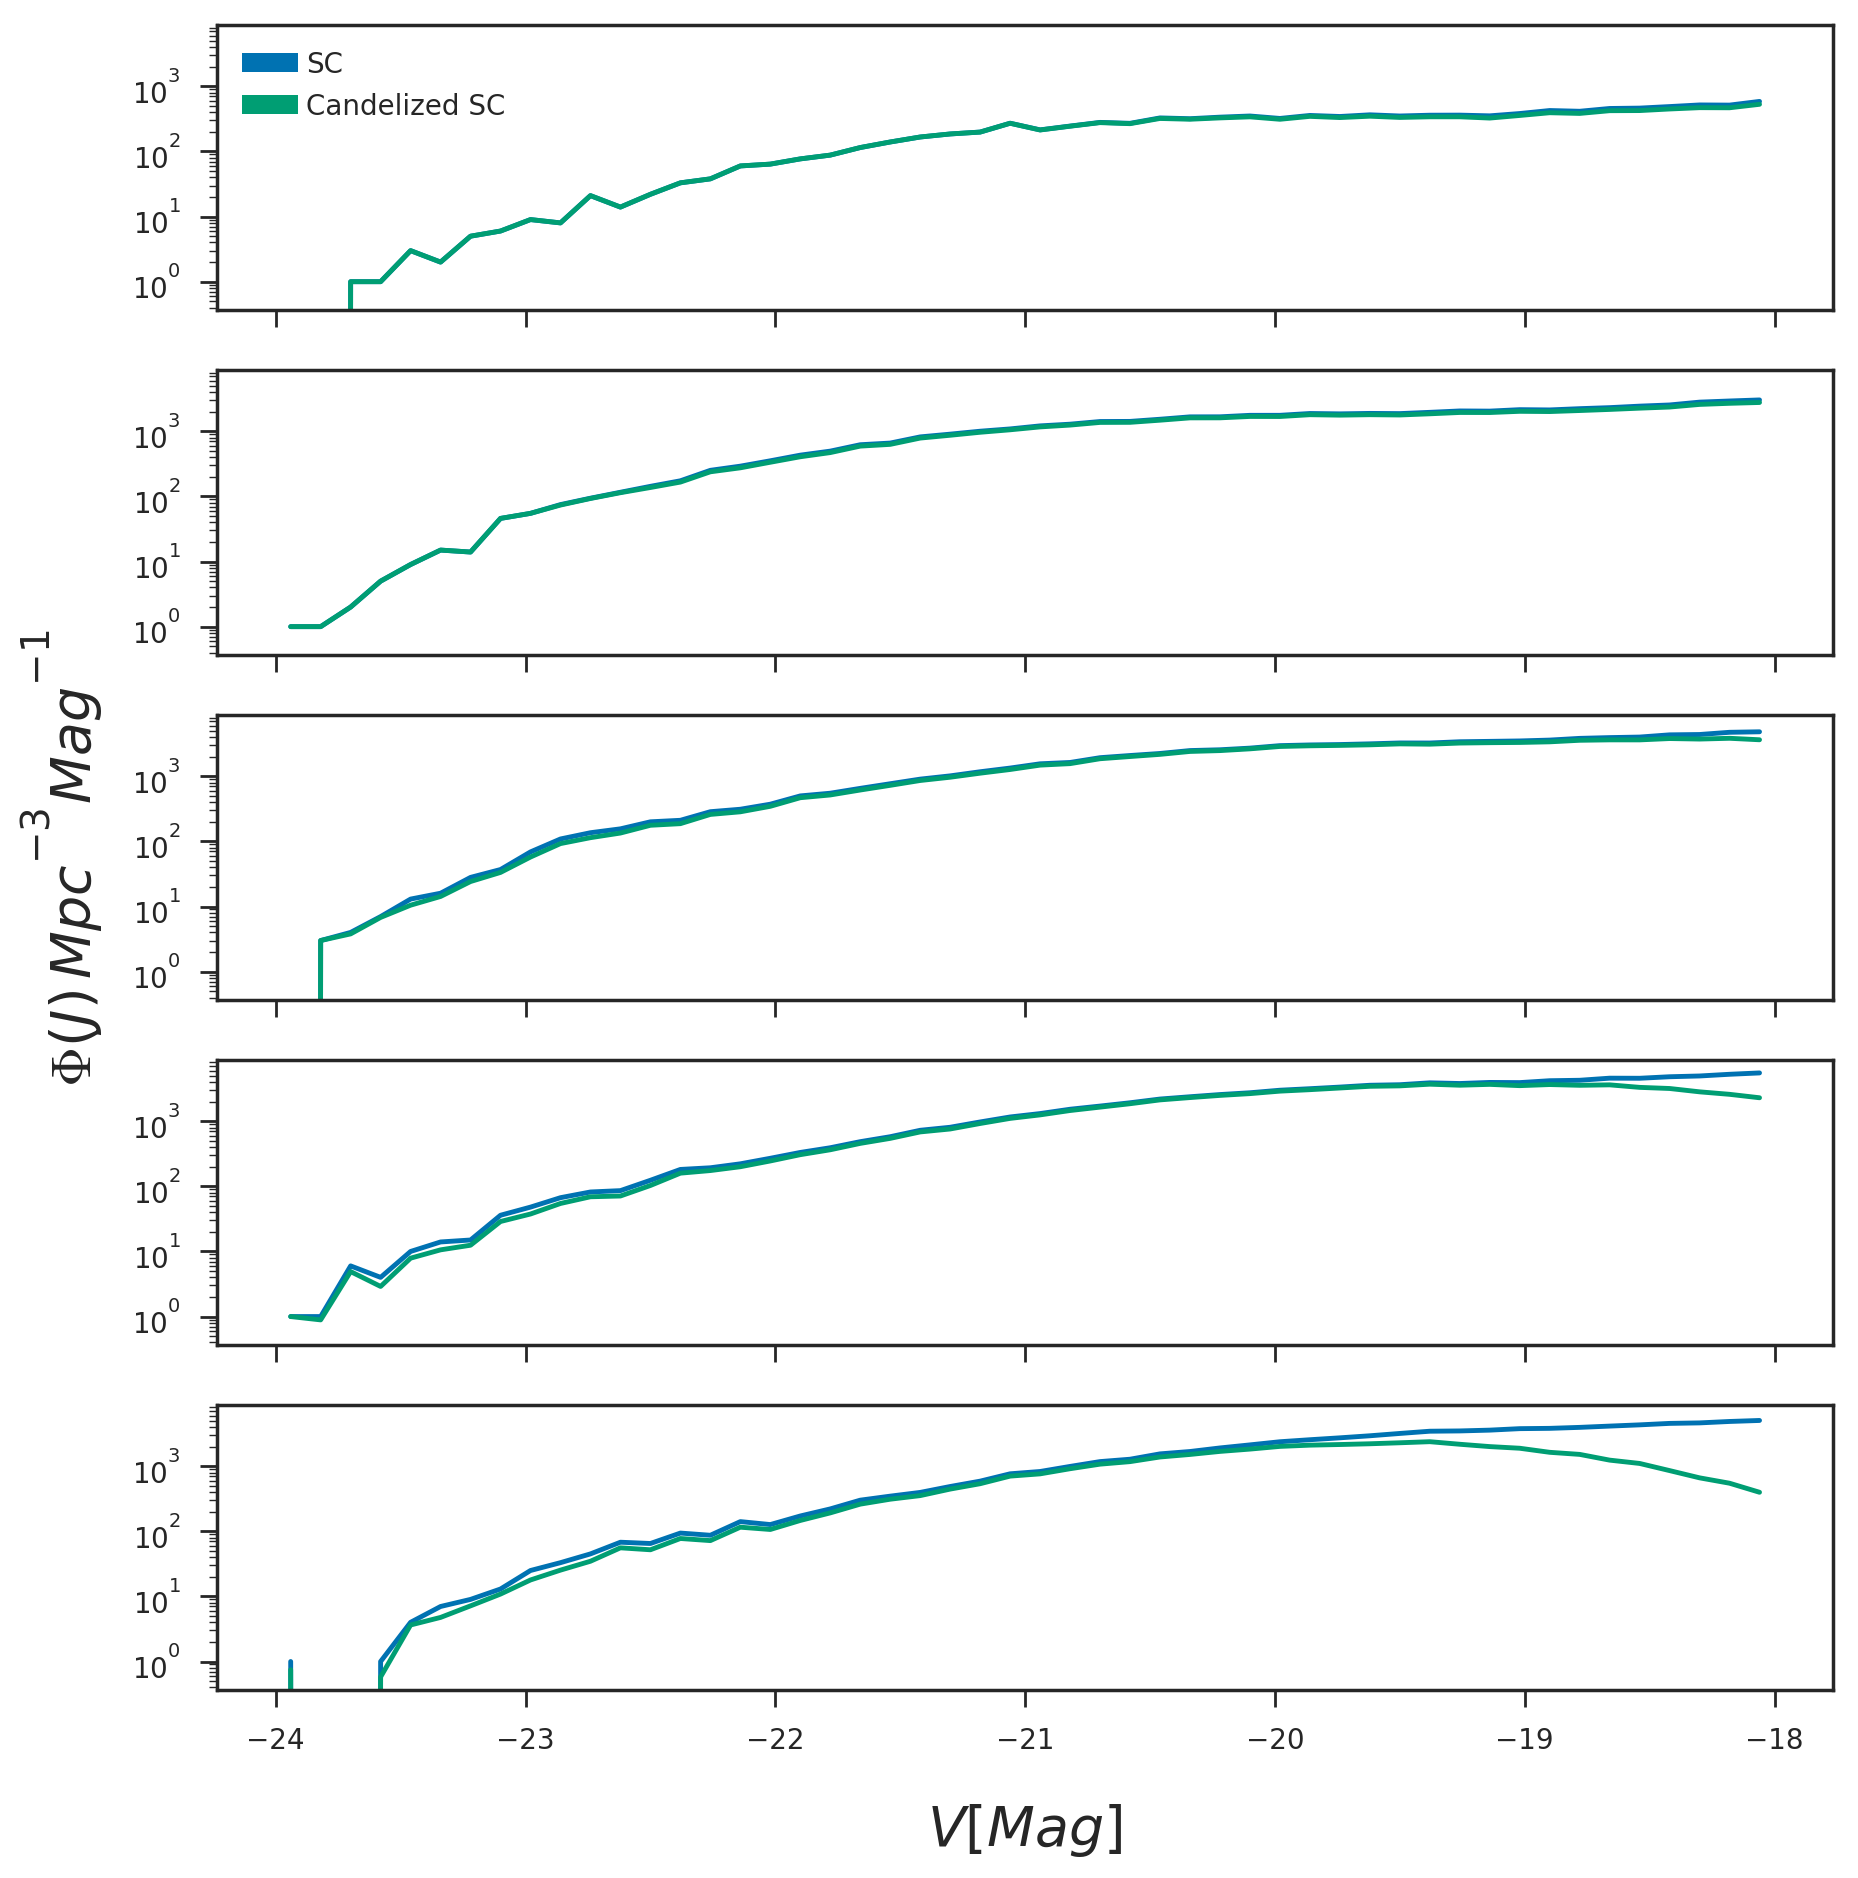

In [47]:
variables = ['redshift_true', 'Mag_true_dust_V_z0']
labels    = ['redshift_true', r'$V [Mag]$']
operations = [None, None]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.0, -24]
bin_hi   = [3.5, -18]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations, labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi, logbins=logbins, weight_quantity='p_detection')

c = test.run_on_single_catalog(scc_gc, 'SC', './', useweights=False)
cc = test.run_on_single_catalog(scc_gc, 'Candelized SC', './', useweights=True)

test.finalize_plot(r'$\Phi(J)\/ Mpc^{-3} Mag^{-1}$', yscale='log')


[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


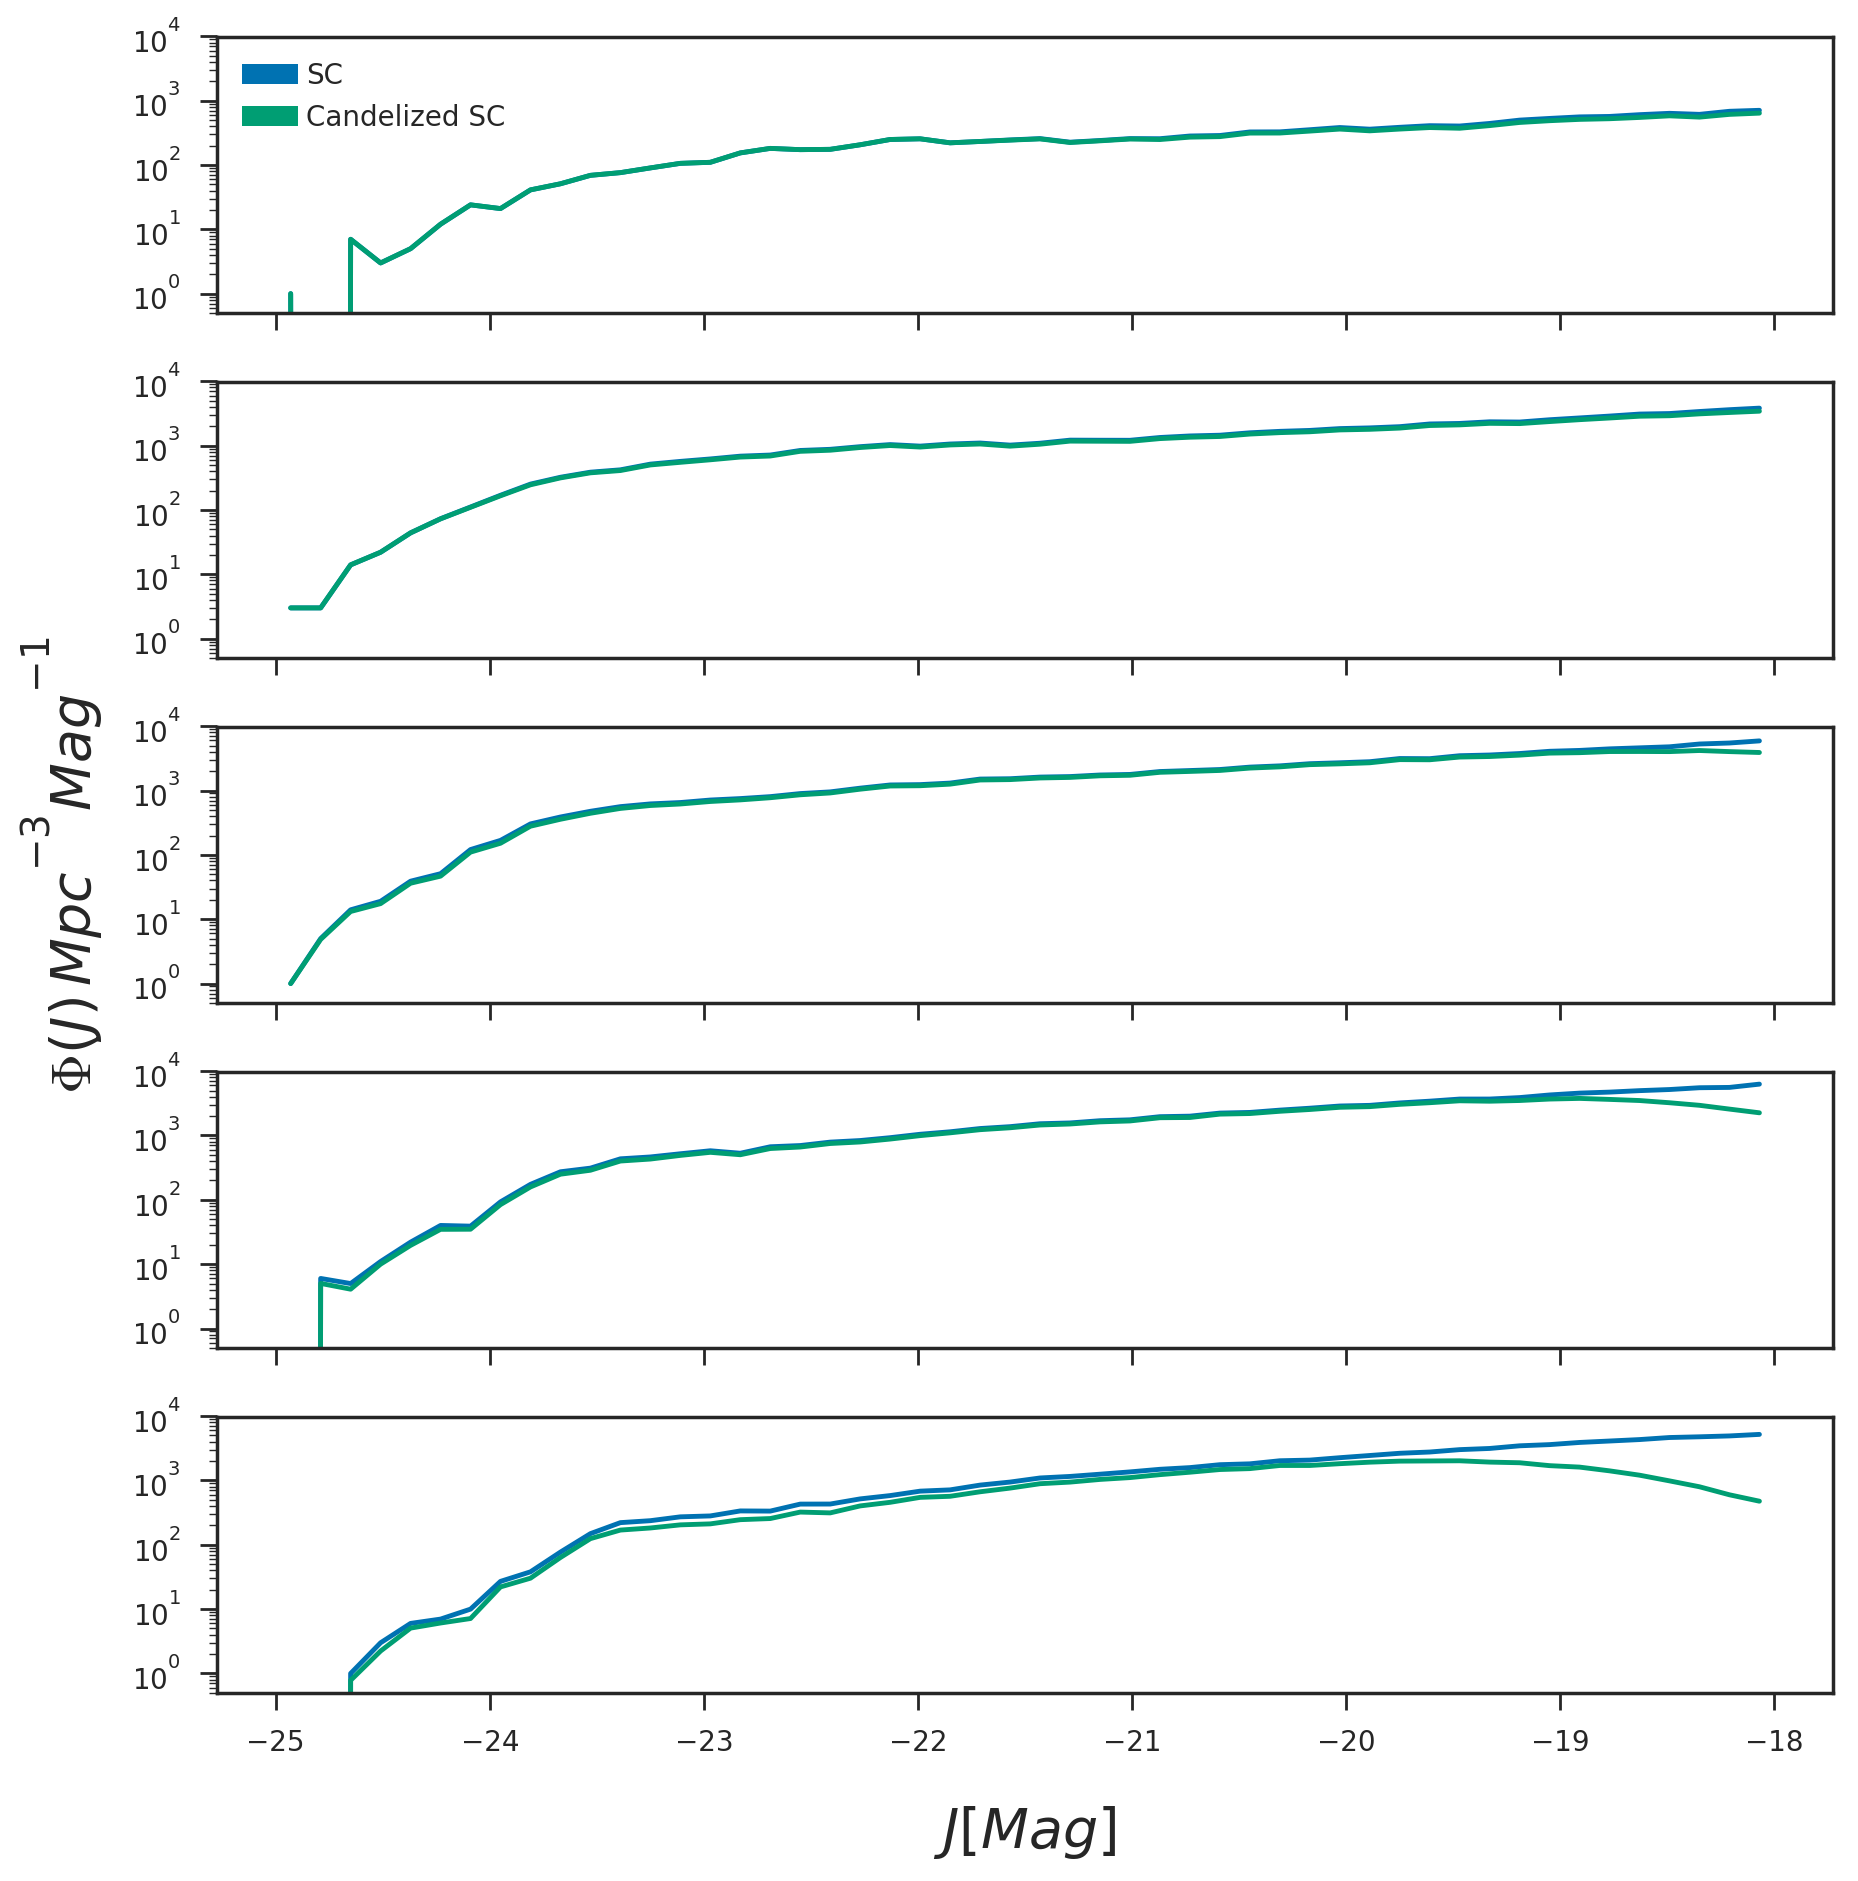

In [43]:
variables = ['redshift_true', 'Mag_true_dust_J_z0']
labels    = ['redshift_true', r'$J [Mag]$']
operations = [None, None]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.0, -25]
bin_hi   = [3.5, -18]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations, labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi, logbins=logbins, weight_quantity='p_detection')

c = test.run_on_single_catalog(scc_gc, 'SC', './', useweights=False)
cc = test.run_on_single_catalog(scc_gc, 'Candelized SC', './', useweights=True)

test.finalize_plot(r'$\Phi(J)\/ Mpc^{-3} Mag^{-1}$', yscale='log')


In [50]:
%pdb

Automatic pdb calling has been turned ON


In [78]:
lu_gc = GCRCatalogs.load_catalog('lu')
sc_gc = GCRCatalogs.load_catalog('sc')
scc_gc = GCRCatalogs.load_catalog('sc_candelized')
um_gc = GCRCatalogs.load_catalog('universemachine')

[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


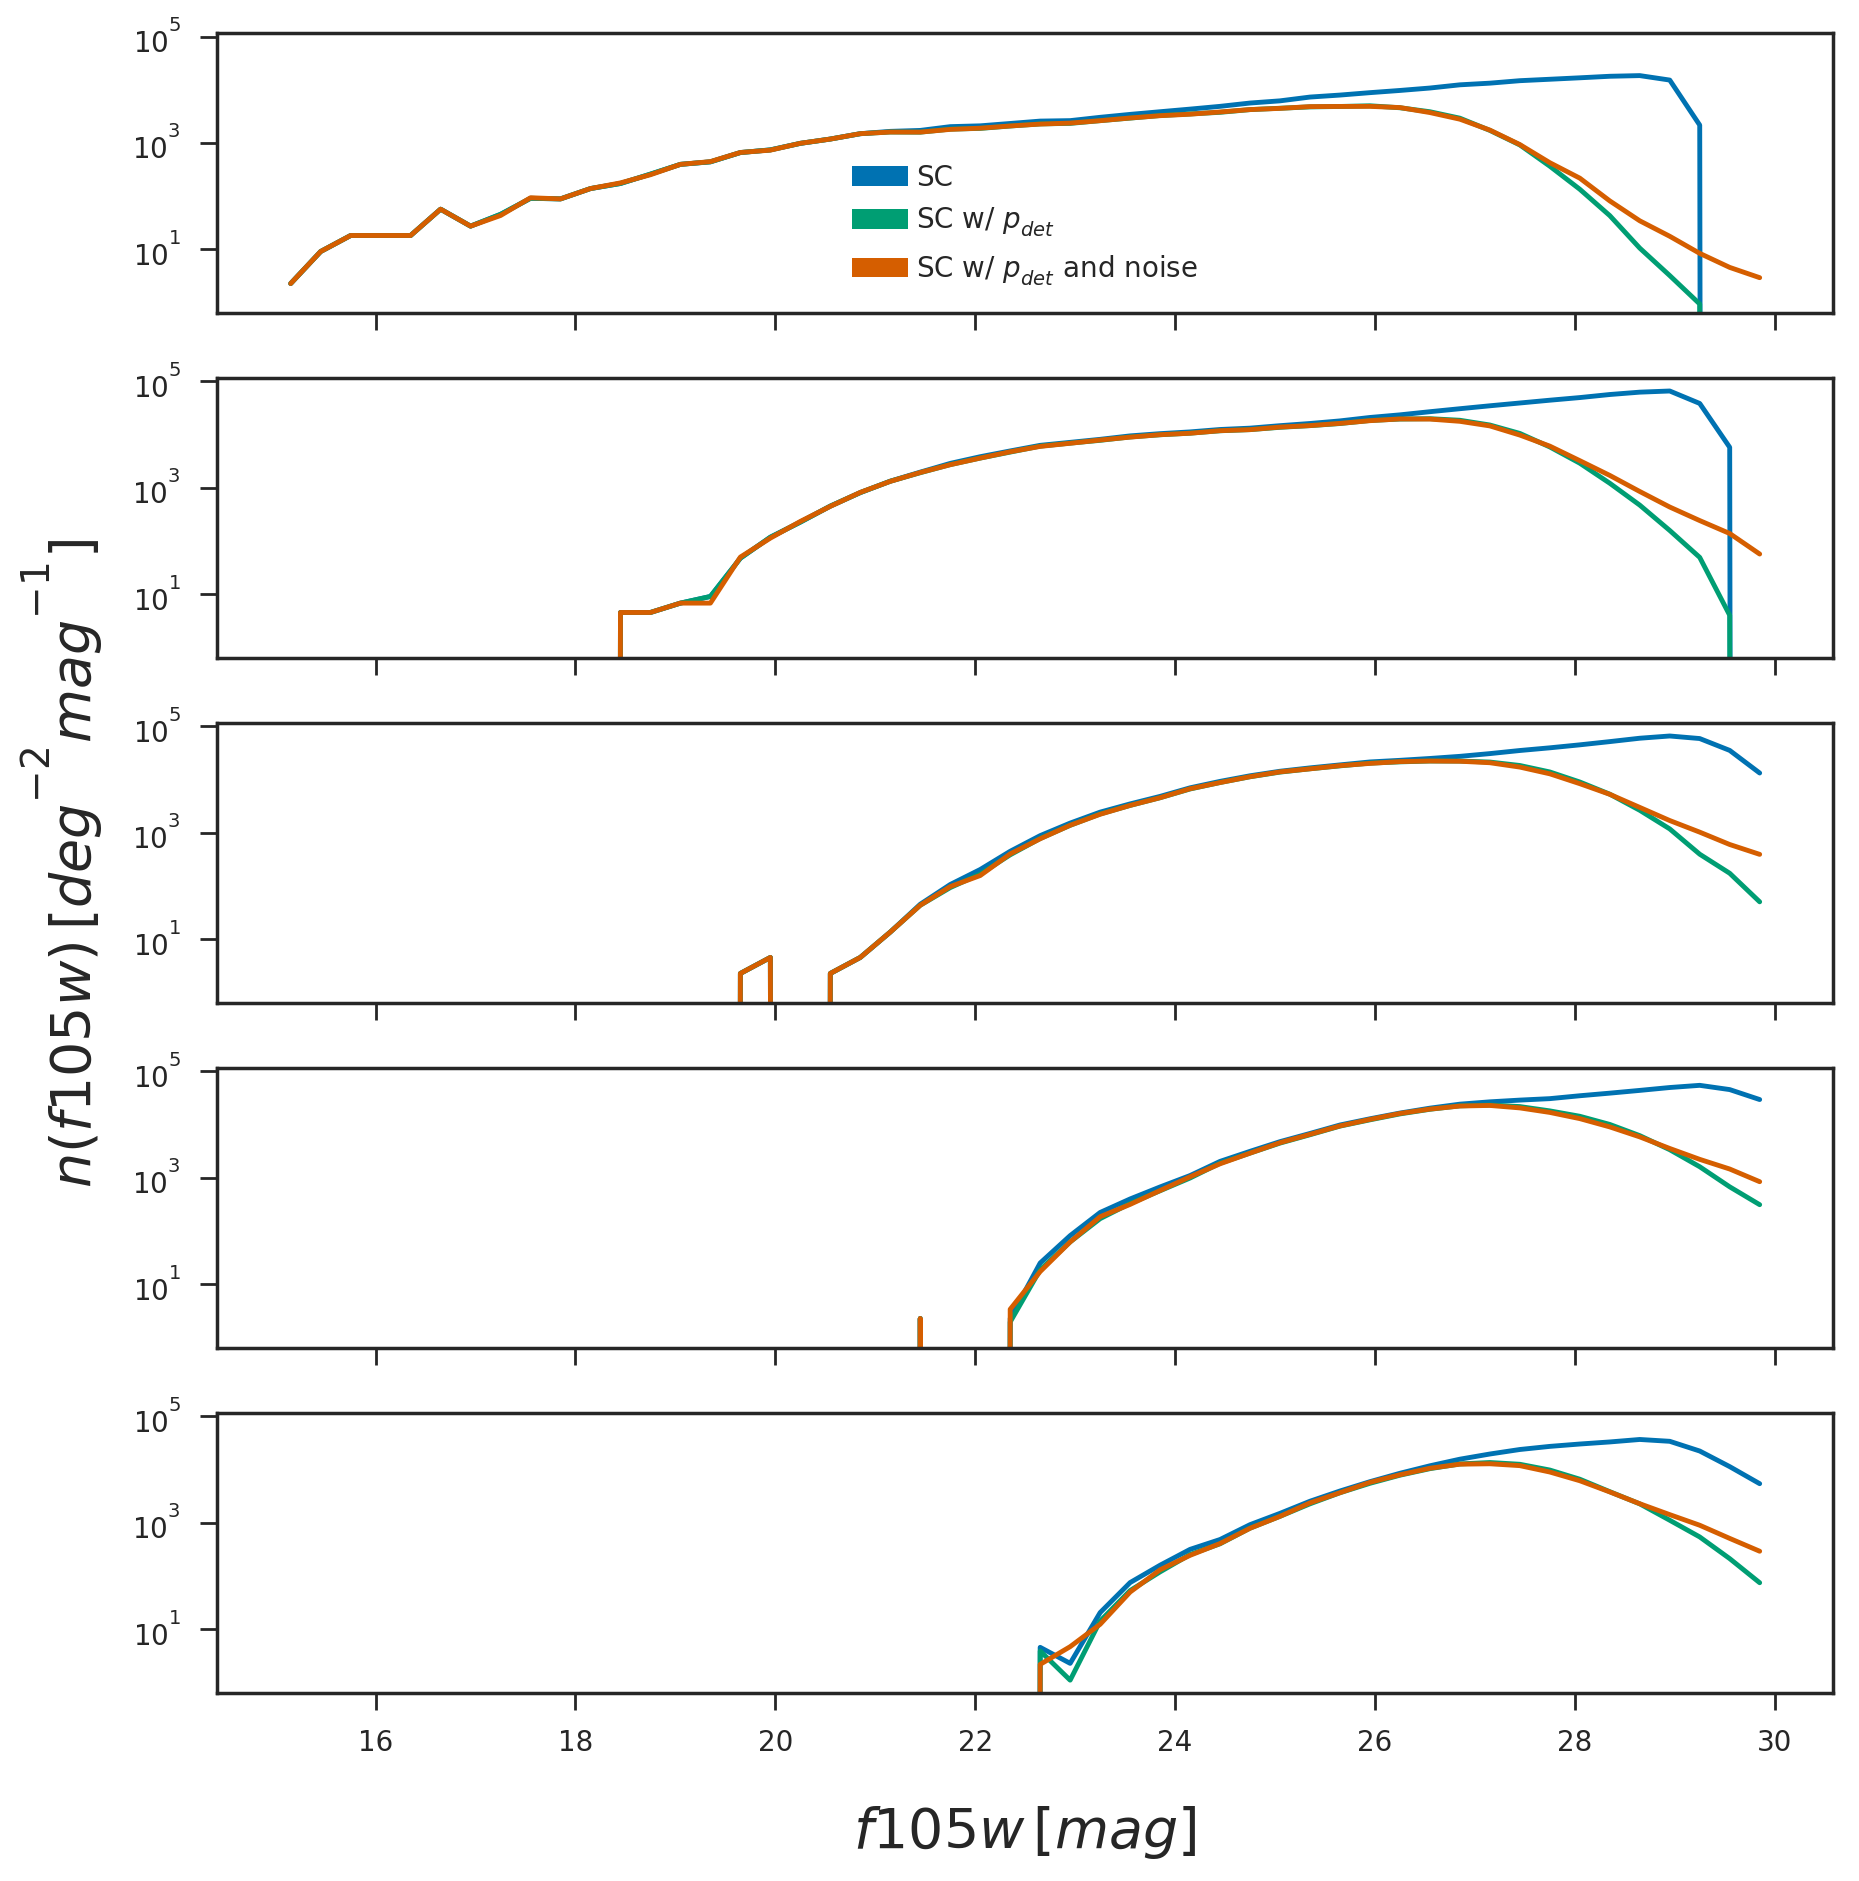

In [90]:
variables = ['redshift_true', 'mag_true_dust_f105w_wfc3']
labels    = ['redshift_true', r'$f105w \/ [mag]$']
operations = [None, None]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.0, 15]
bin_hi   = [3.5, 30]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo,
                      hi=bin_hi, logbins=logbins,
                      weight_quantity='p_detection',
                      norm_by=([0],'area'))

c = test.run_on_single_catalog(scc_gc, 'SC', './', useweights=False)
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$', './', useweights=True)
scc_gc = GCRCatalogs.load_catalog('sc_candelized')
test.new_quantities(['redshift_true', 'mag_f105w_wfc3'], labels=['redshift_true', r'$f105w\/ [mag]$'])
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$ and noise', './', useweights=True)

test.finalize_plot(r'$n(f105w)\/ [deg^{-2} mag^{-1}]$', yscale='log')


In [76]:
lu_gc = GCRCatalogs.load_catalog('lu')
sc_gc = GCRCatalogs.load_catalog('sc')
scc_gc = GCRCatalogs.load_catalog('sc_candelized')
um_gc = GCRCatalogs.load_catalog('universemachine')

[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


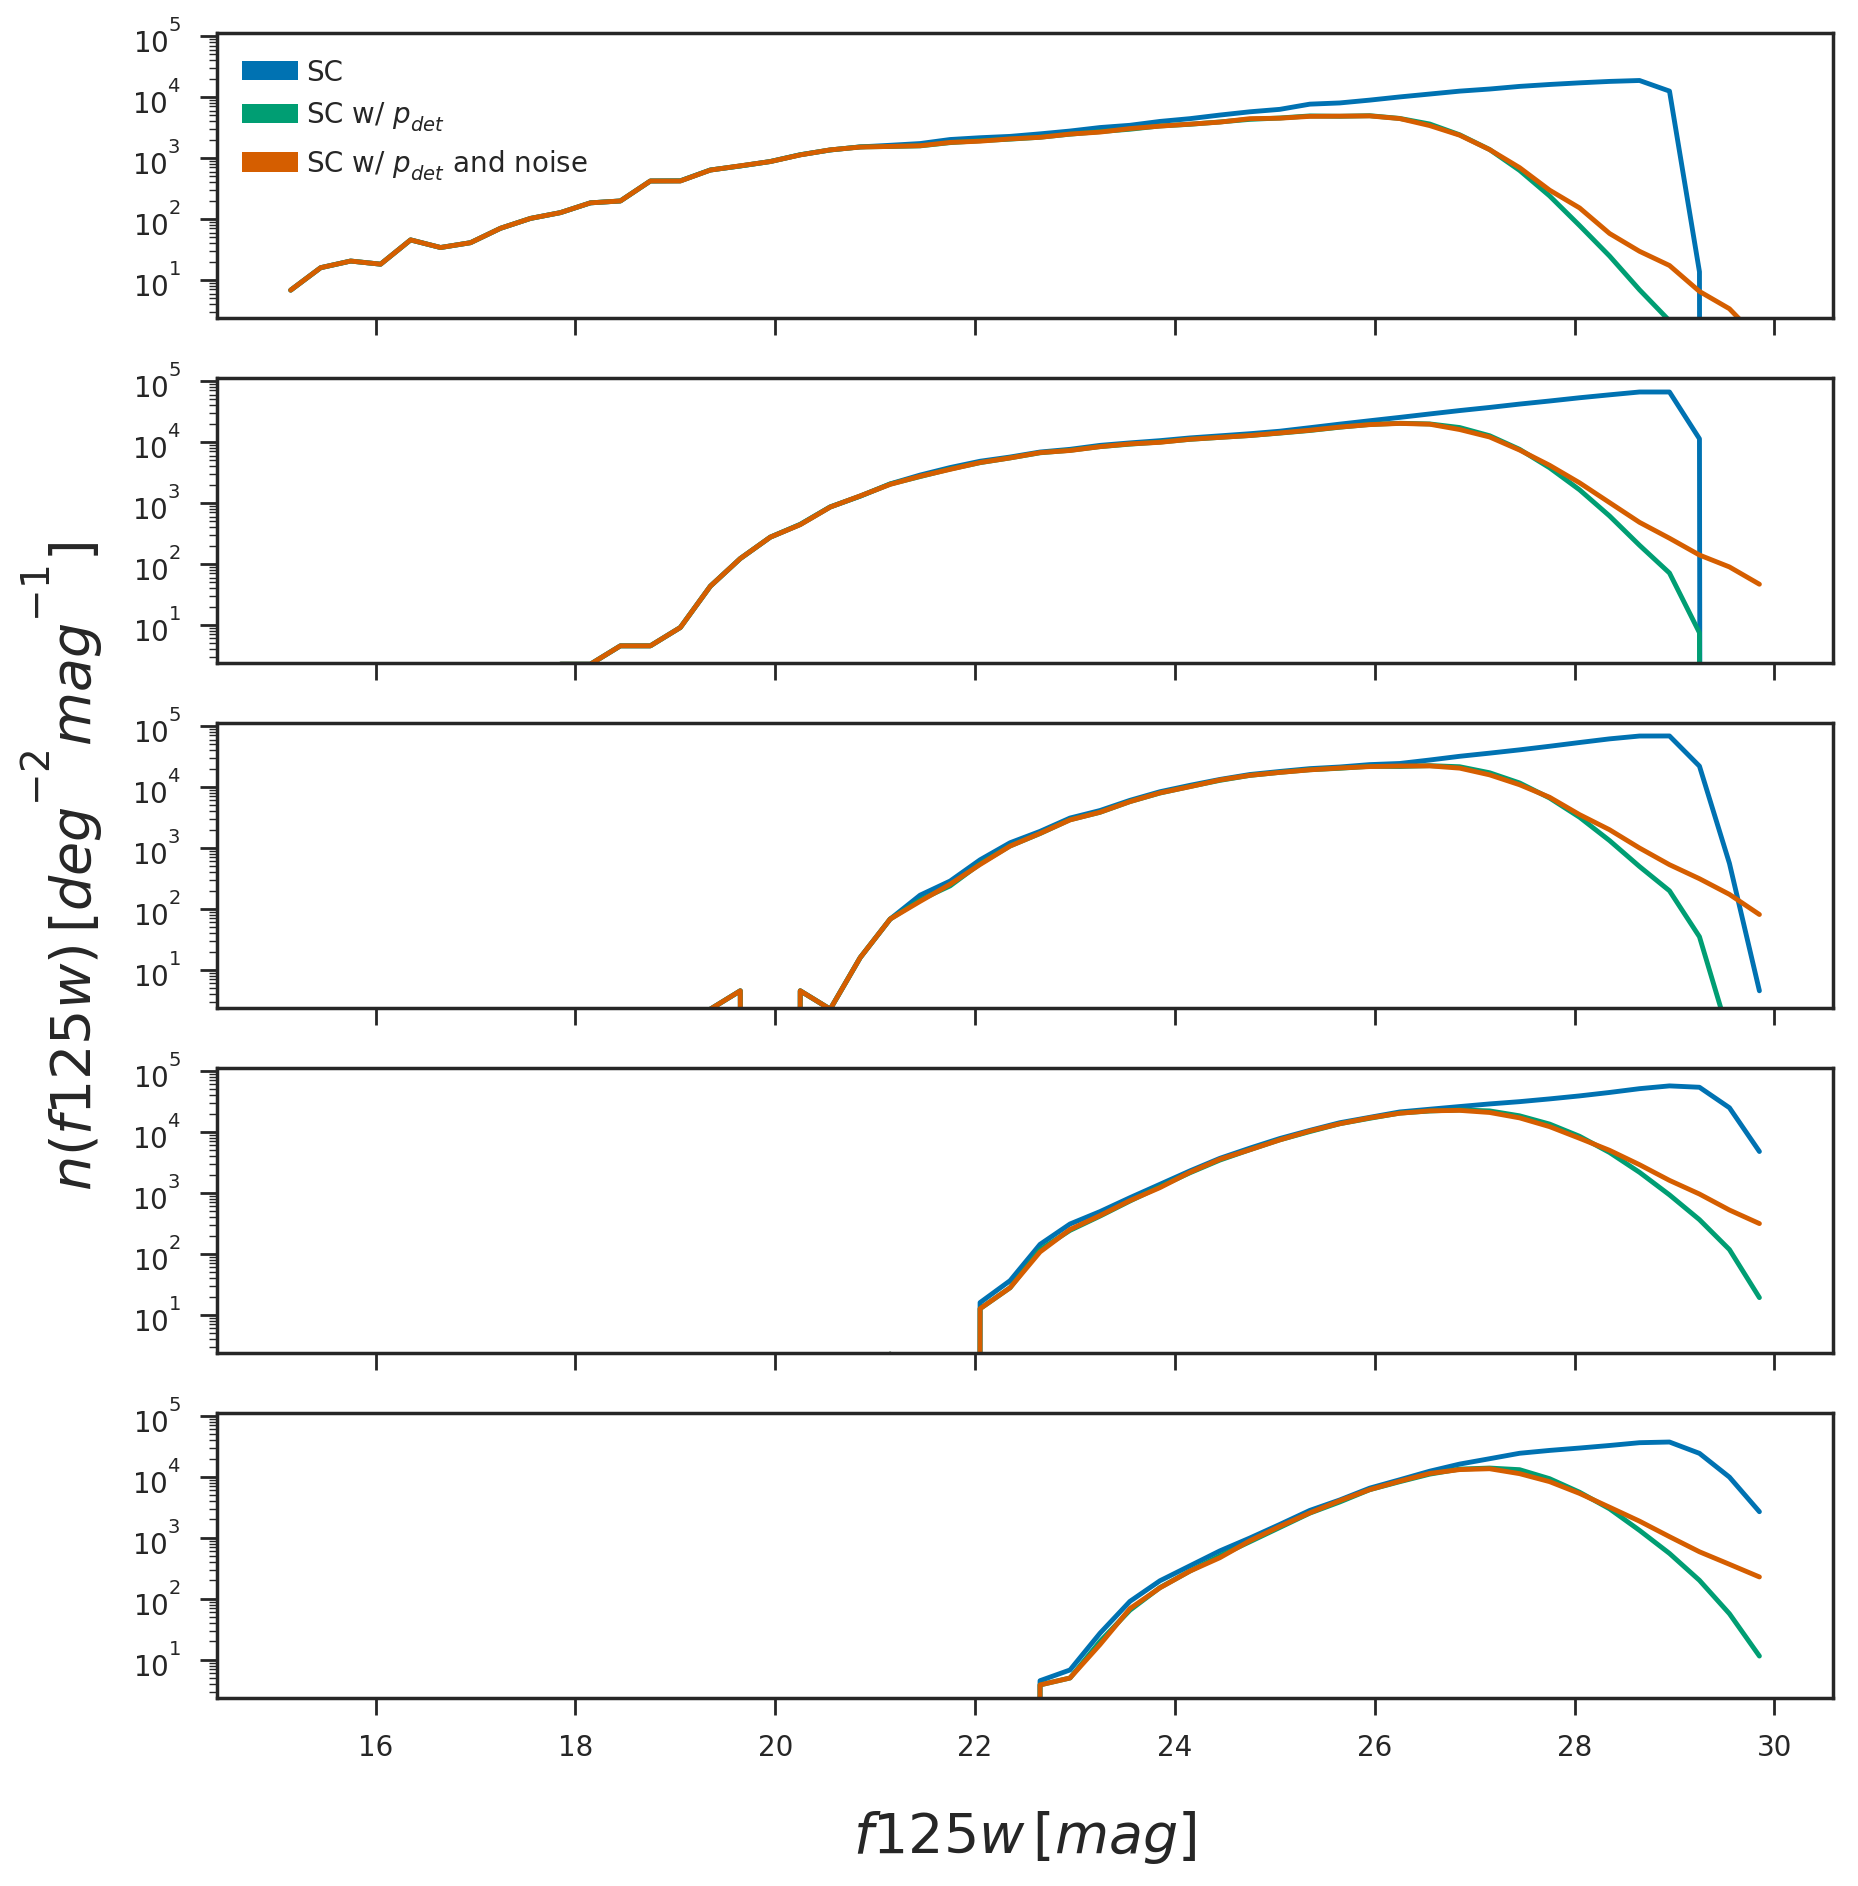

In [89]:
variables = ['redshift_true', 'mag_true_dust_f125w_wfc3']
labels    = ['redshift_true', r'$f125w \/ [mag]$']
operations = [None, None]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.0, 15]
bin_hi   = [3.5, 30]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi,
                      logbins=logbins, weight_quantity='p_detection',
                      norm_by=([0],'area'))

c = test.run_on_single_catalog(scc_gc, 'SC', './', useweights=False)
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$', './', useweights=True)
scc_gc = GCRCatalogs.load_catalog('sc_candelized')
test.new_quantities(['redshift_true', 'mag_f125w_wfc3'], labels=['redshift_true', r'$f125w\/ [mag]$'])
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$ and noise', './', useweights=True)

test.finalize_plot(r'$n(f125w)\/ [deg^{-2} mag^{-1}]$', yscale='log')


[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


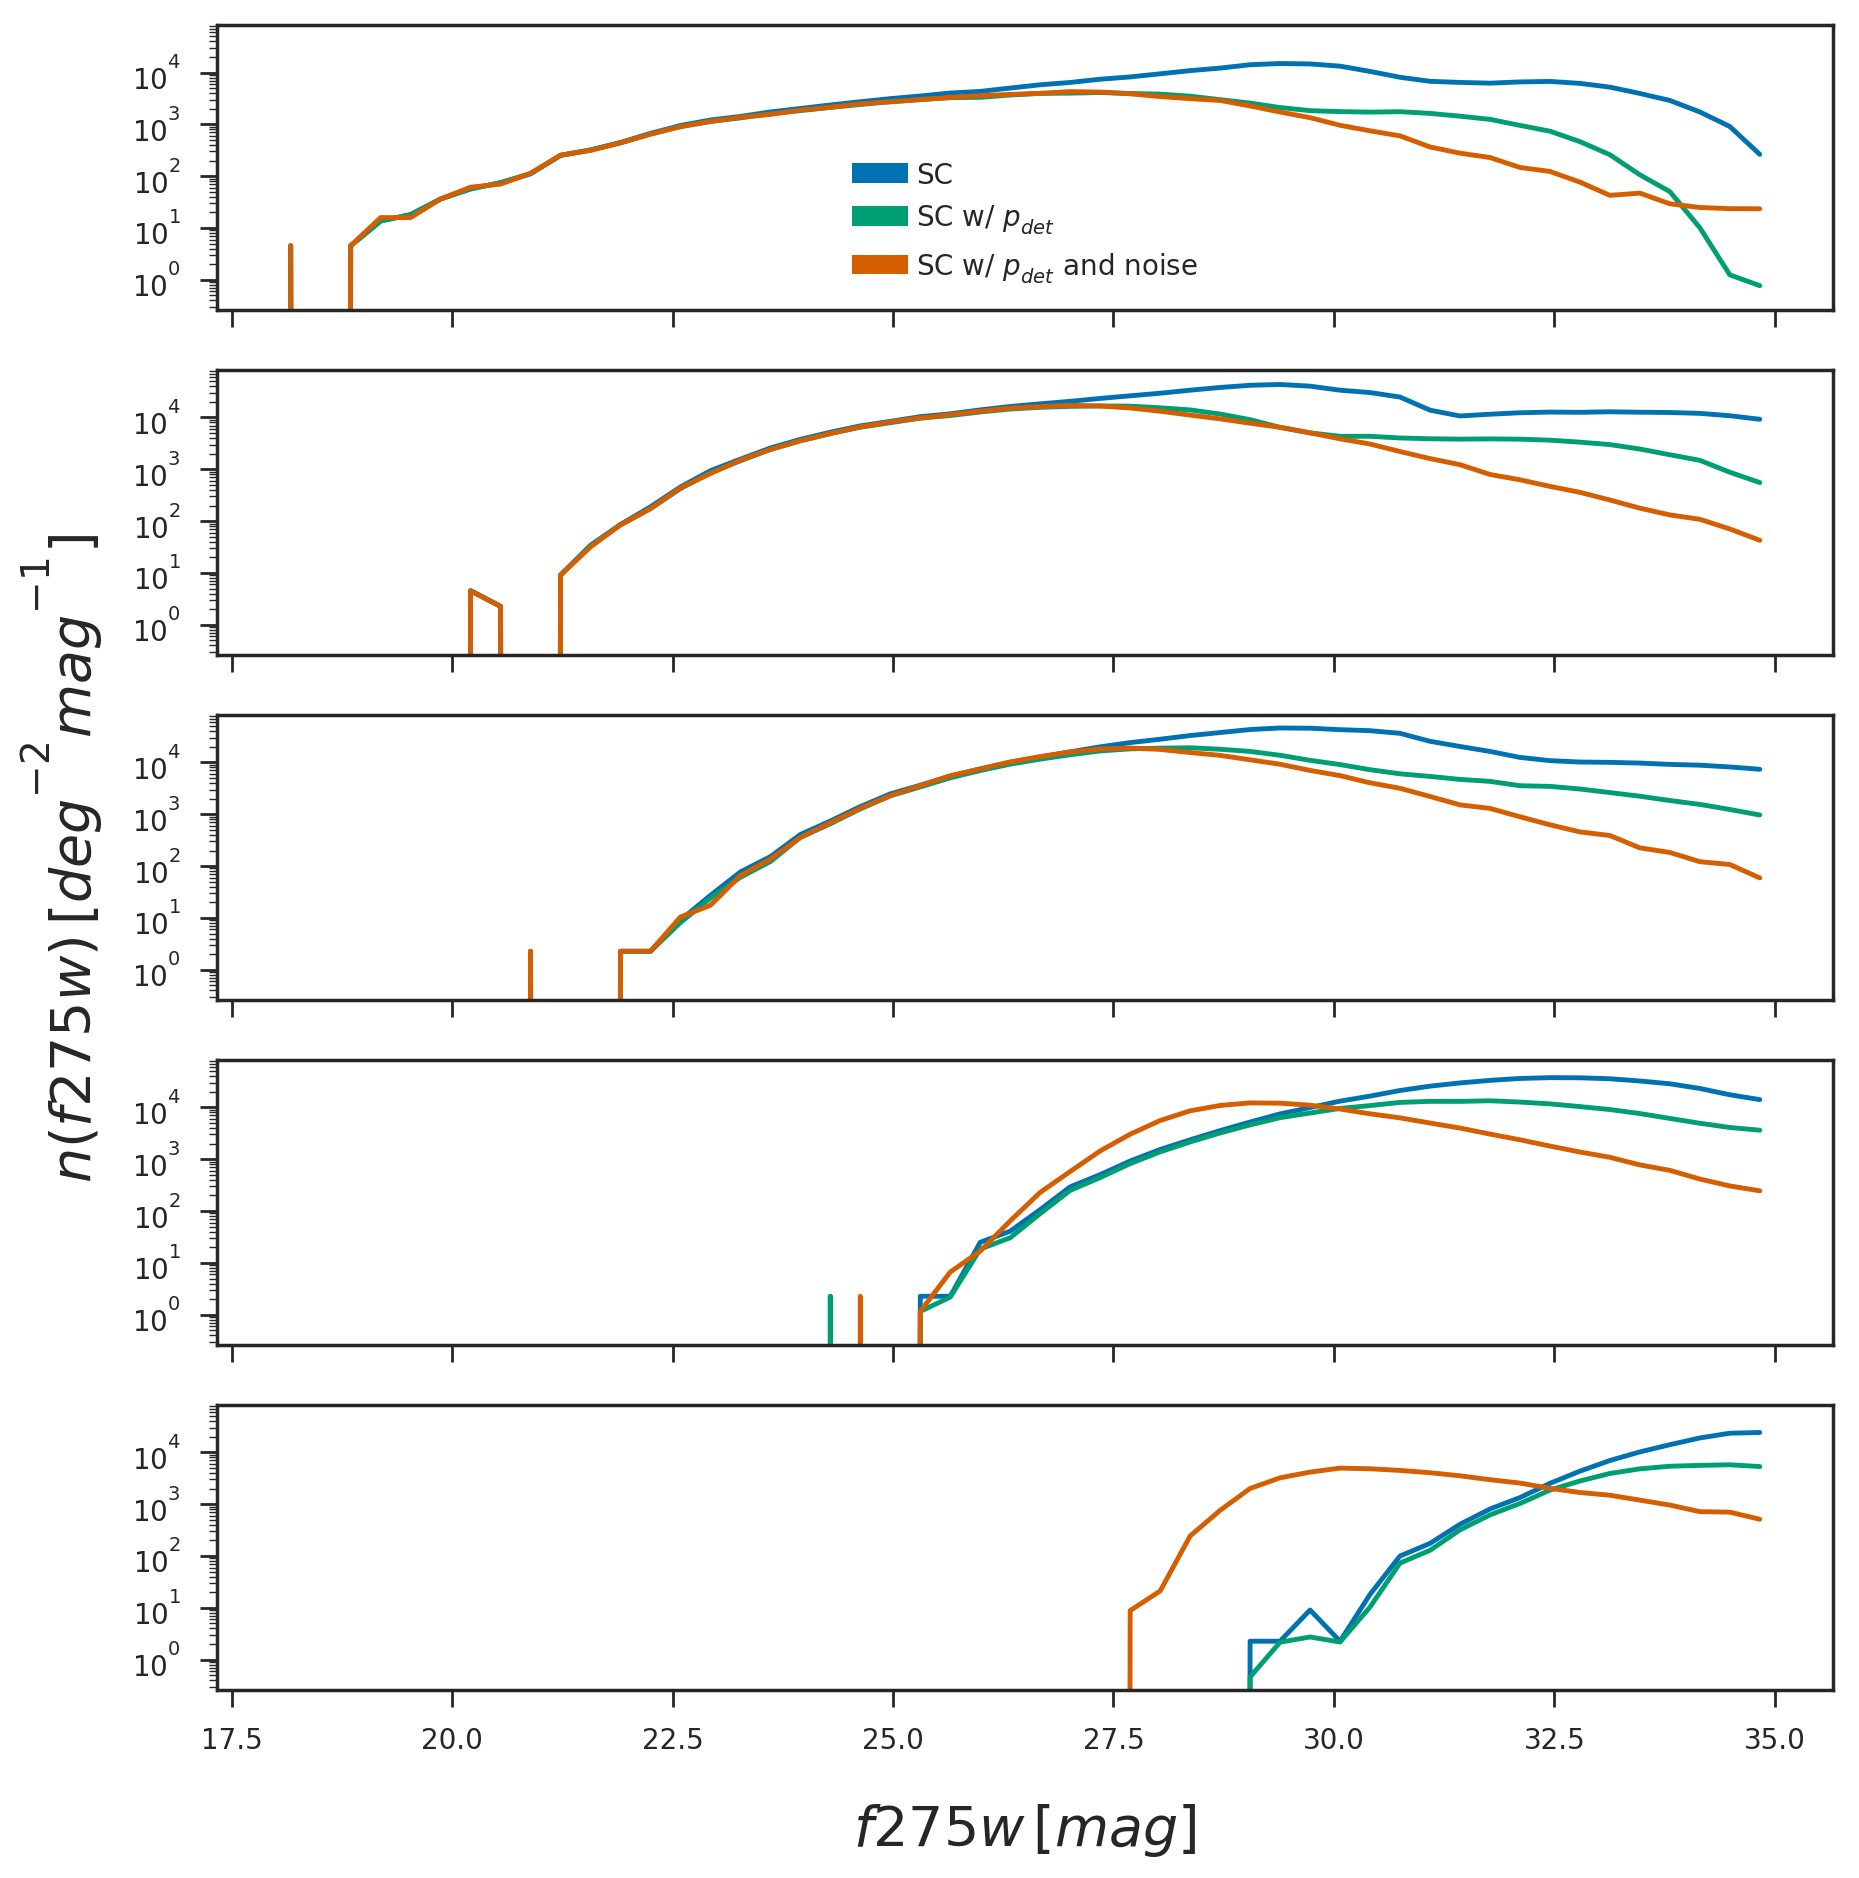

In [88]:
variables = ['redshift_true', 'mag_true_dust_f275w_wfc3']
labels    = ['redshift_true', r'$f275w \/ [mag]$']
operations = [None, None]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.0, 18]
bin_hi   = [3.5, 35]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi,
                      logbins=logbins, weight_quantity='p_detection',
                      norm_by=([0],'area'))

c = test.run_on_single_catalog(scc_gc, 'SC', './', useweights=False)
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$', './', useweights=True)
scc_gc = GCRCatalogs.load_catalog('sc_candelized')
test.new_quantities(['redshift_true', 'mag_f275w_wfc3'], labels=['redshift_true', r'$f275w\/ [mag]$'])
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$ and noise', './', useweights=True)

test.finalize_plot(r'$n(f275w)\/ [deg^{-2} mag^{-1}]$', yscale='log')


[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


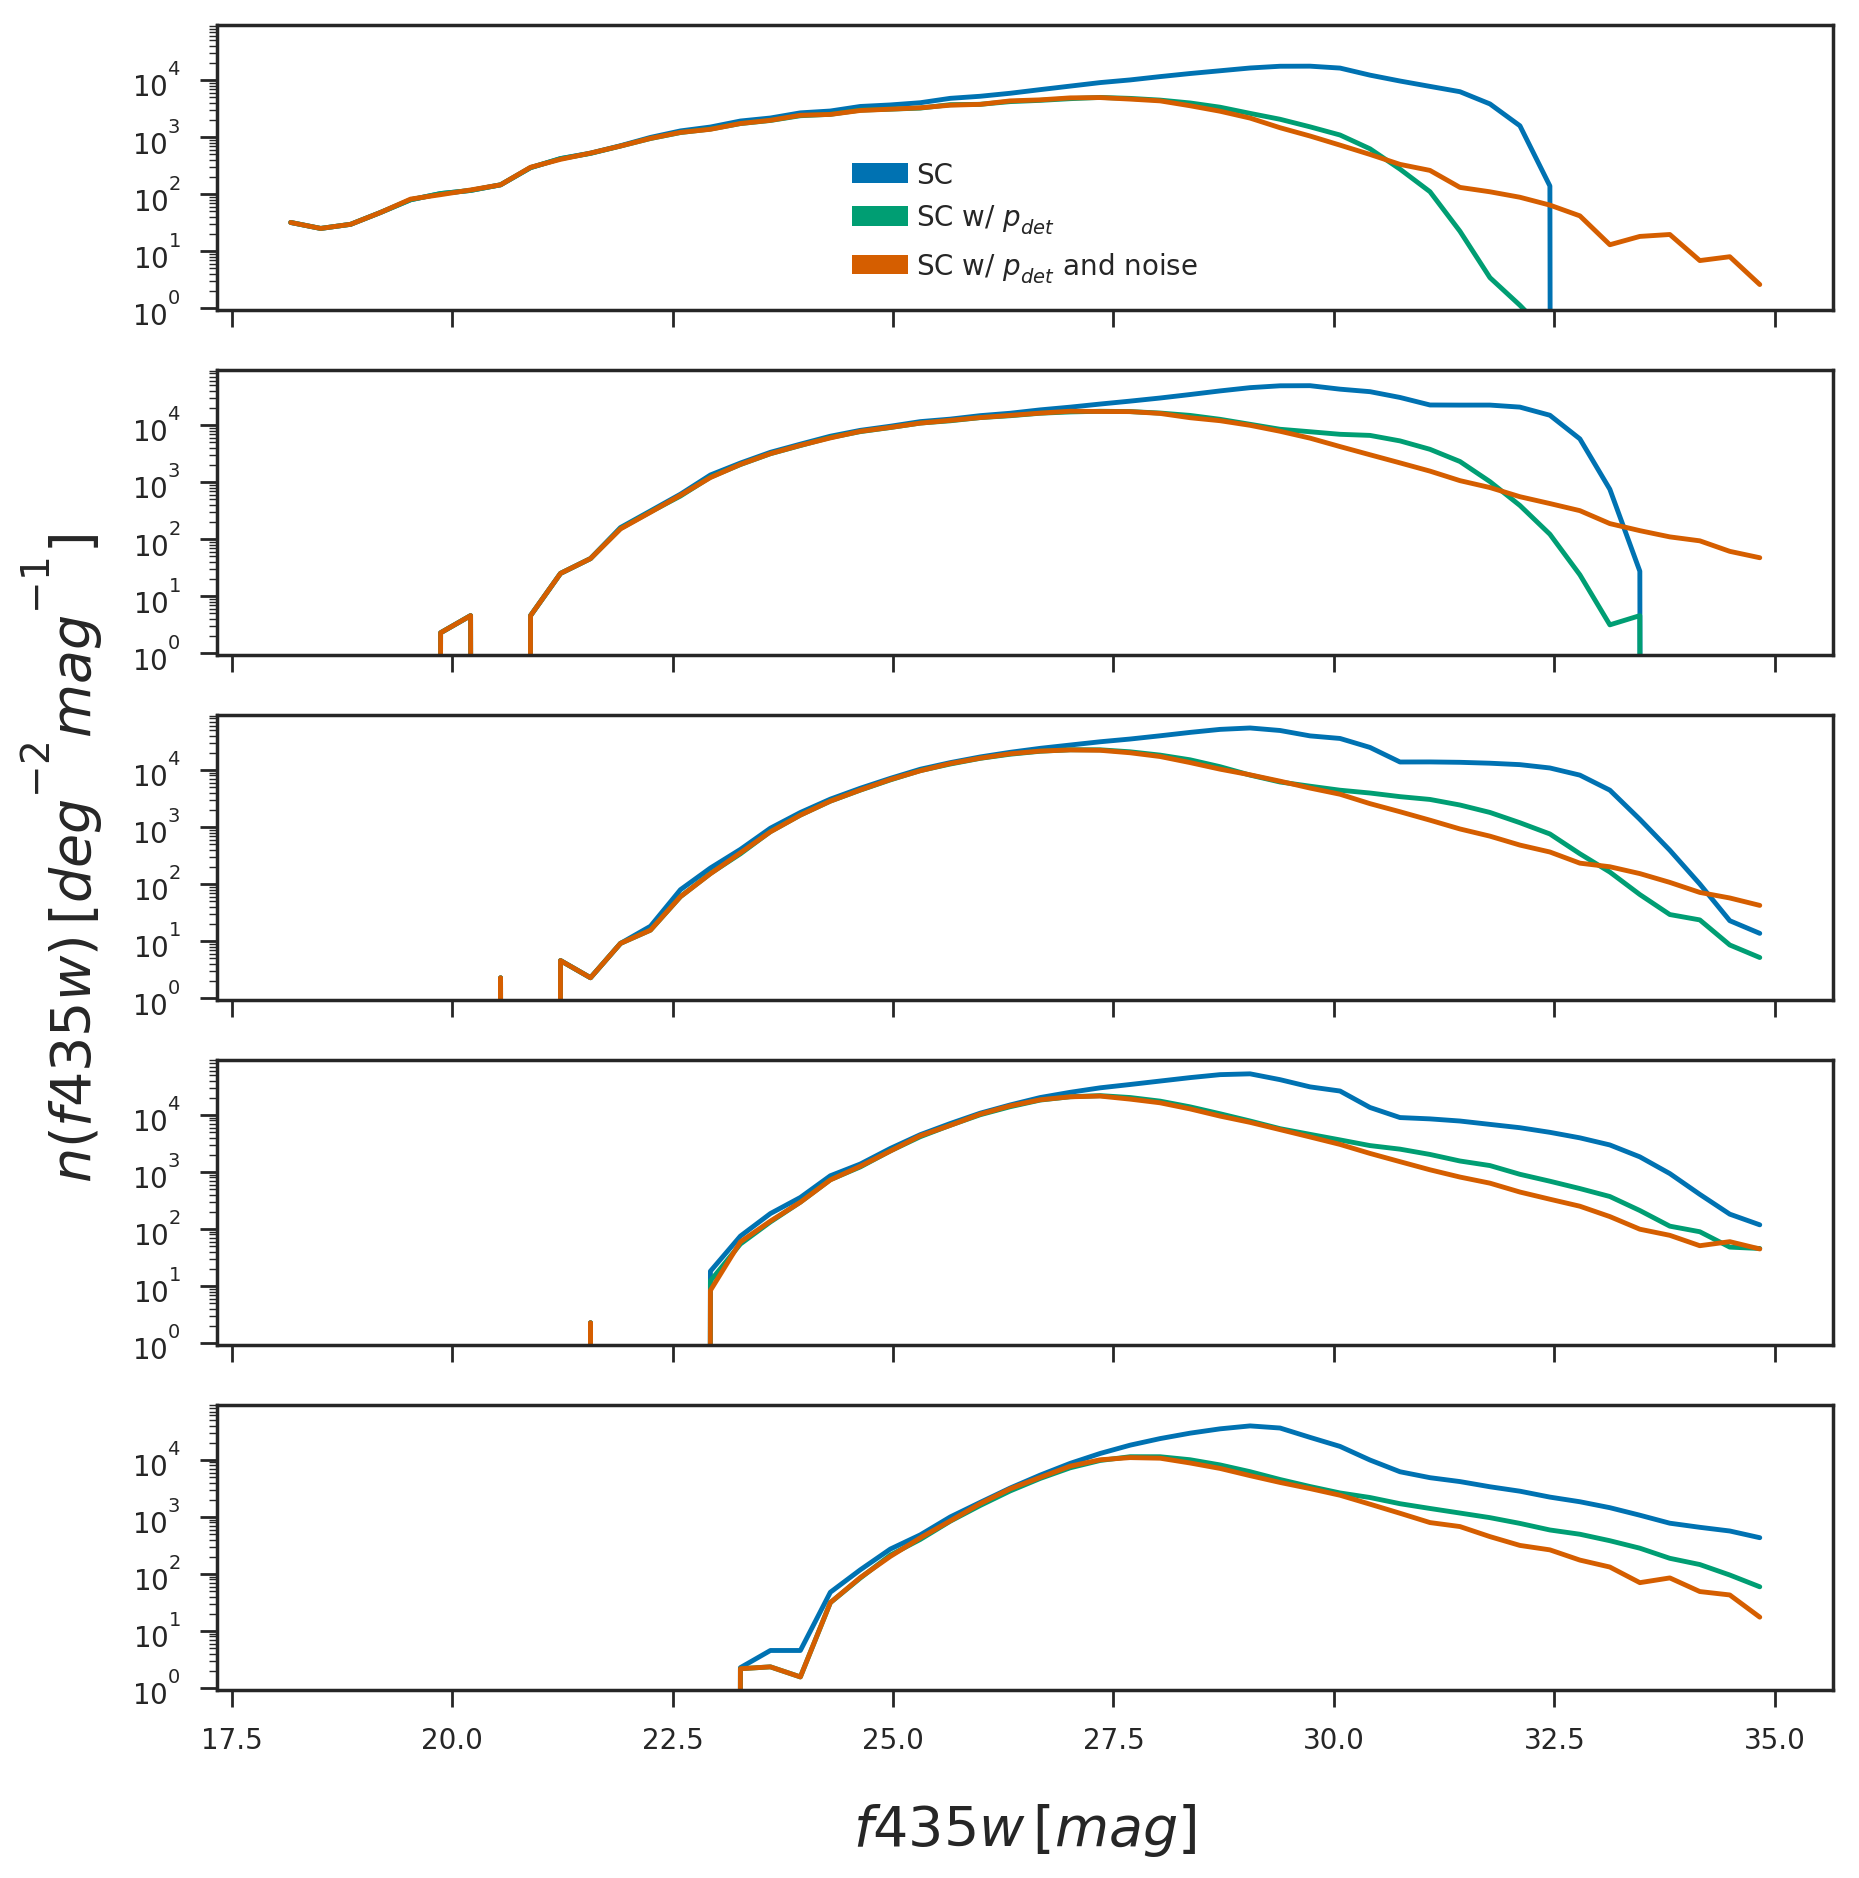

In [87]:
variables = ['redshift_true', 'mag_true_dust_f435w_acs']
labels    = ['redshift_true', r'$f435w \/ [mag]$']
operations = [None, None]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.0, 18]
bin_hi   = [3.5, 35]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi,
                      logbins=logbins, weight_quantity='p_detection',
                      norm_by=([0],'area'))

c = test.run_on_single_catalog(scc_gc, 'SC', './', useweights=False)
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$', './', useweights=True)
scc_gc = GCRCatalogs.load_catalog('sc_candelized')
test.new_quantities(['redshift_true', 'mag_f435w_acs'], labels=['redshift_true', r'$f435w\/ [mag]$'])
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$ and noise', './', useweights=True)

test.finalize_plot(r'$n(f435w)\/ [deg^{-2} mag^{-1}]$', yscale='log')


[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]
[array([0, 1, 2, 3, 4])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


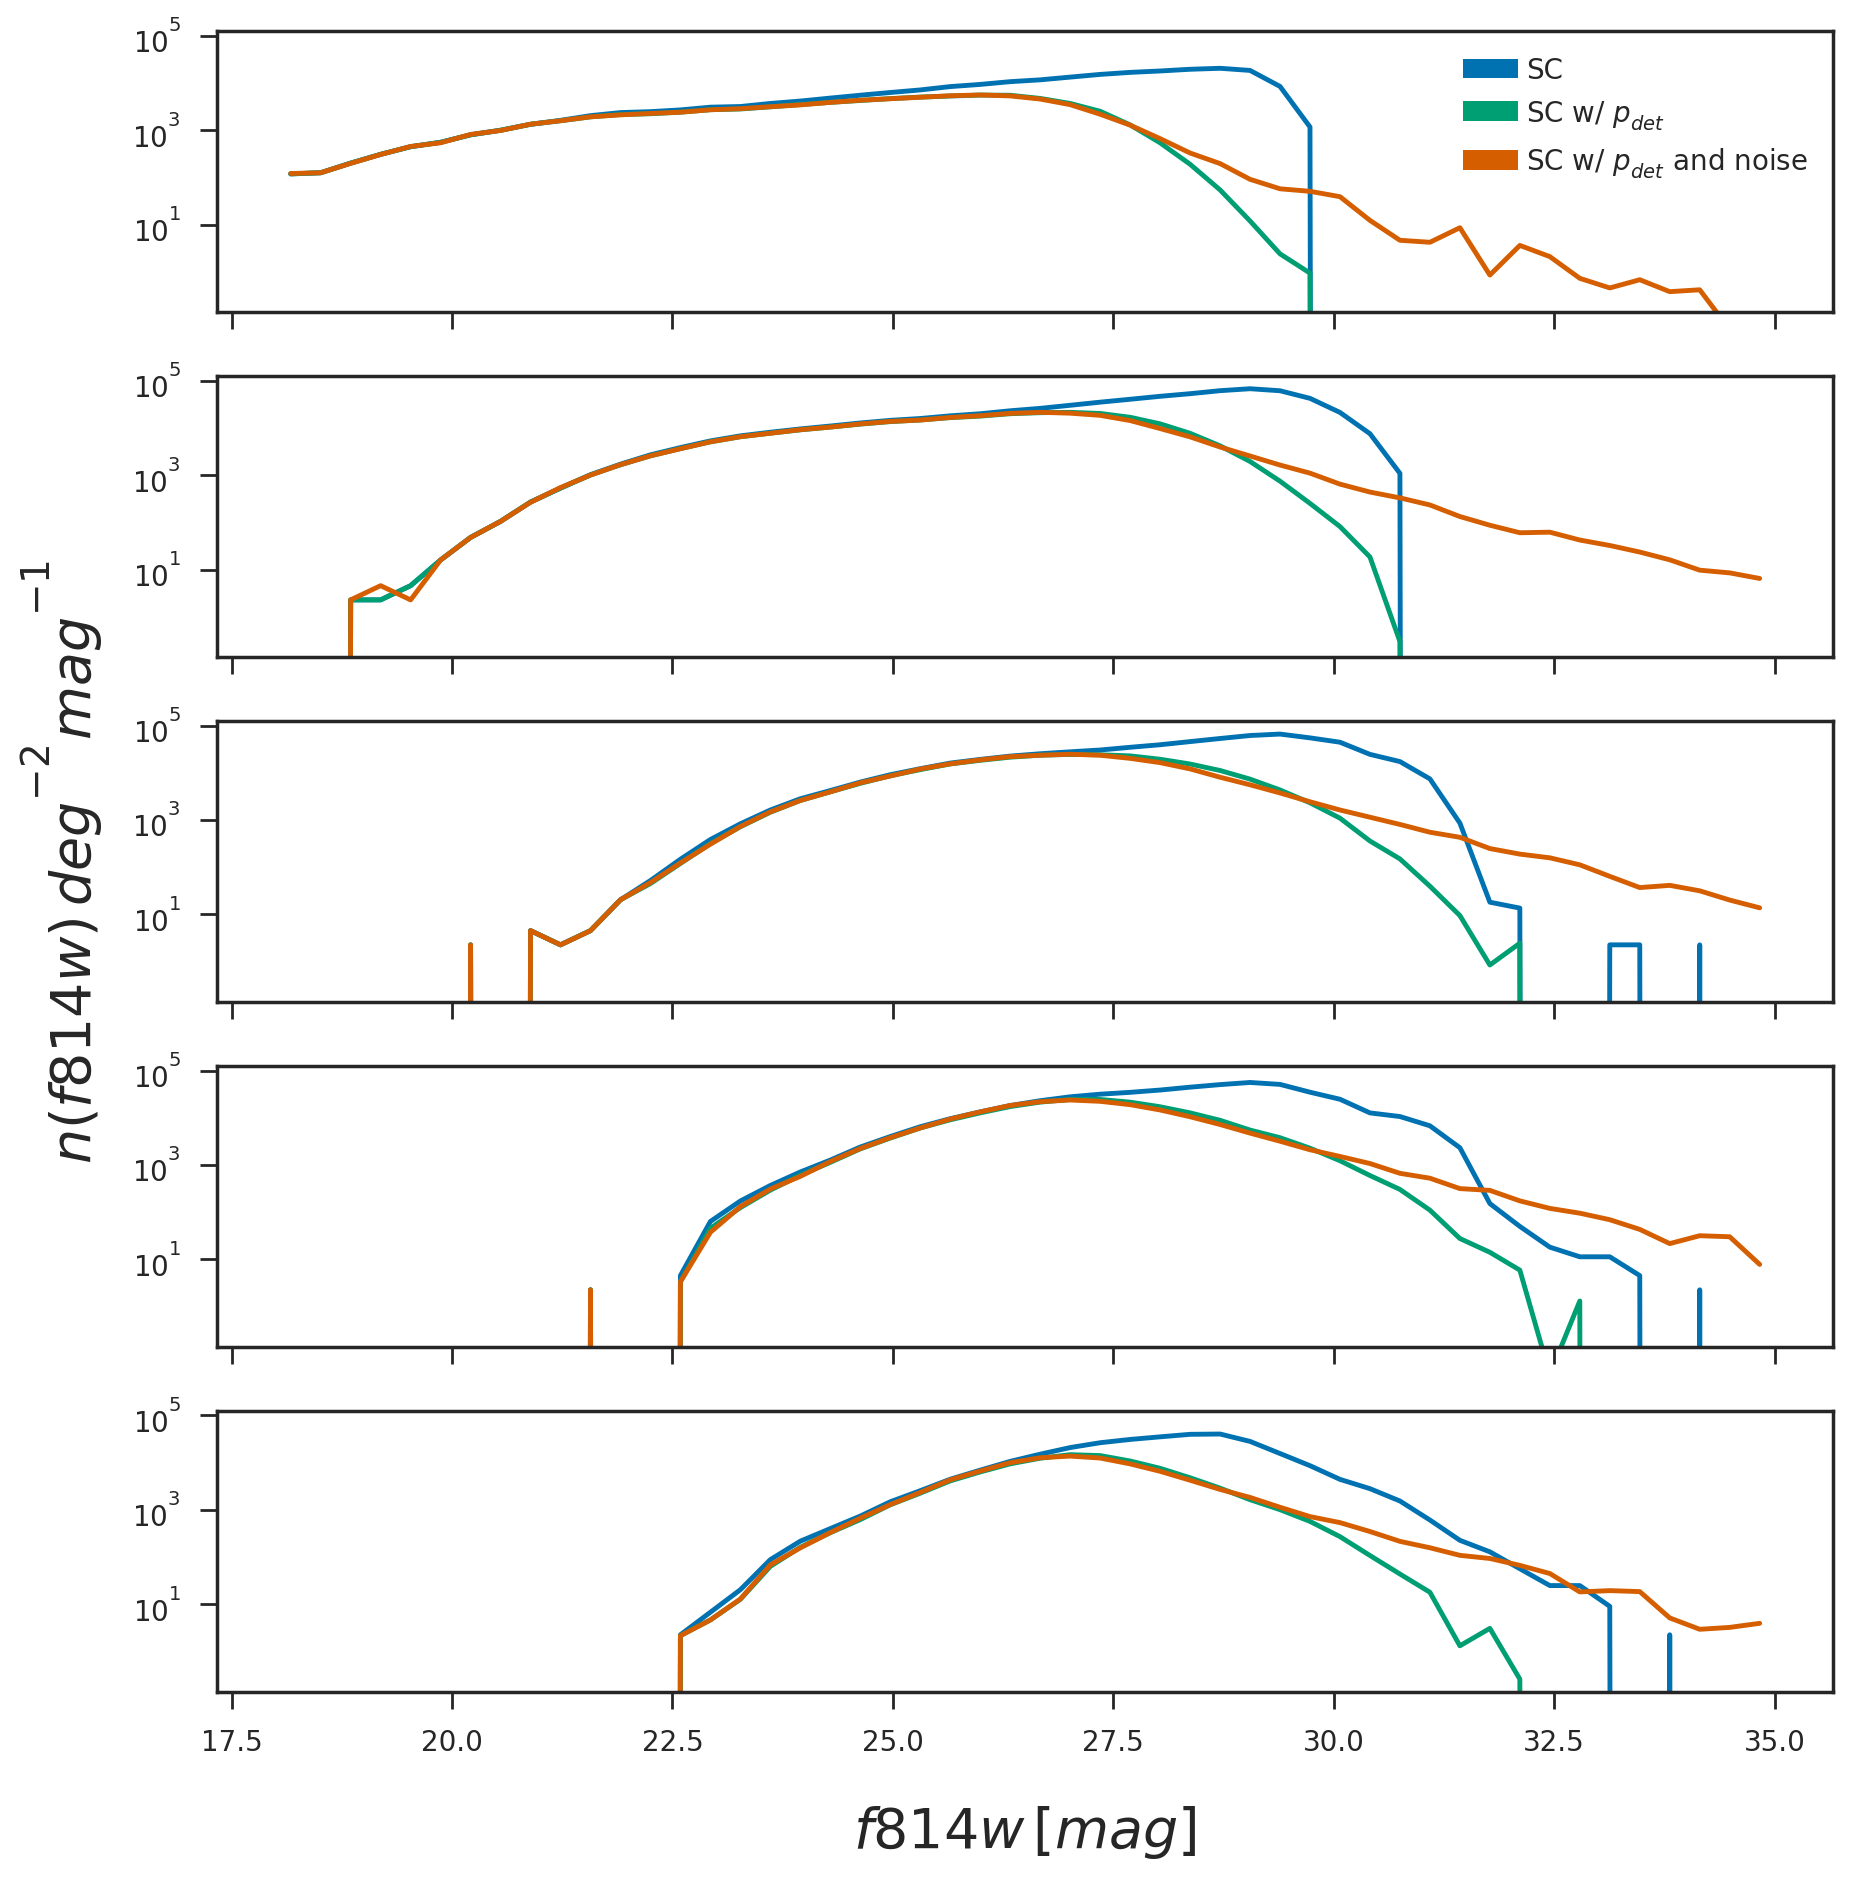

In [86]:
variables = ['redshift_true', 'mag_true_dust_f814w_acs']
labels    = ['redshift_true', r'$f814w \/ [mag]$']
operations = [None, None]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.0, 18]
bin_hi   = [3.5, 35]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi,
                      logbins=logbins, weight_quantity='p_detection',
                      norm_by=([0],'area'))

c = test.run_on_single_catalog(scc_gc, 'SC', './', useweights=False)
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$', './', useweights=True)
scc_gc = GCRCatalogs.load_catalog('sc_candelized')
test.new_quantities(['redshift_true', 'mag_f814w_acs'], labels=['redshift_true', r'$f814w\/ [mag]$'])
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$ and noise', './', useweights=True)

test.finalize_plot(r'$n(f814w)\/ [deg^{-2} mag^{-1}]$', yscale='log')


In [ ]:
variables = ['redshift_true', 'mag_true_dust_f814w_acs']
labels    = ['redshift_true', r'$f814w \/ [mag]$']
operations = [None, None]
plot_axes = [1]

Nbins    = [5, 50]
bin_lo   = [0.0, 18]
bin_hi   = [3.5, 35]
logbins  = [False, False]


test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi,
                      logbins=logbins, weight_quantity='p_detection',
                      norm_by=([0],'area'))

c = test.run_on_single_catalog(scc_gc, 'SC', './', useweights=False)
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$', './', useweights=True)
scc_gc = GCRCatalogs.load_catalog('sc_candelized')
test.new_quantities(['redshift_true', 'mag_f814w_acs'], labels=['redshift_true', r'$f814w\/ [mag]$'])
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$ and noise', './', useweights=True)

test.finalize_plot(r'$n(f814w)\/ [deg^{-2} mag^{-1}]$', yscale='log')


In [96]:
lu_gc = GCRCatalogs.load_catalog('lu')
sc_gc = GCRCatalogs.load_catalog('sc')
scc_gc = GCRCatalogs.load_catalog('sc_candelized')
um_gc = GCRCatalogs.load_catalog('universemachine')

[array([0])]
[array([0])]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


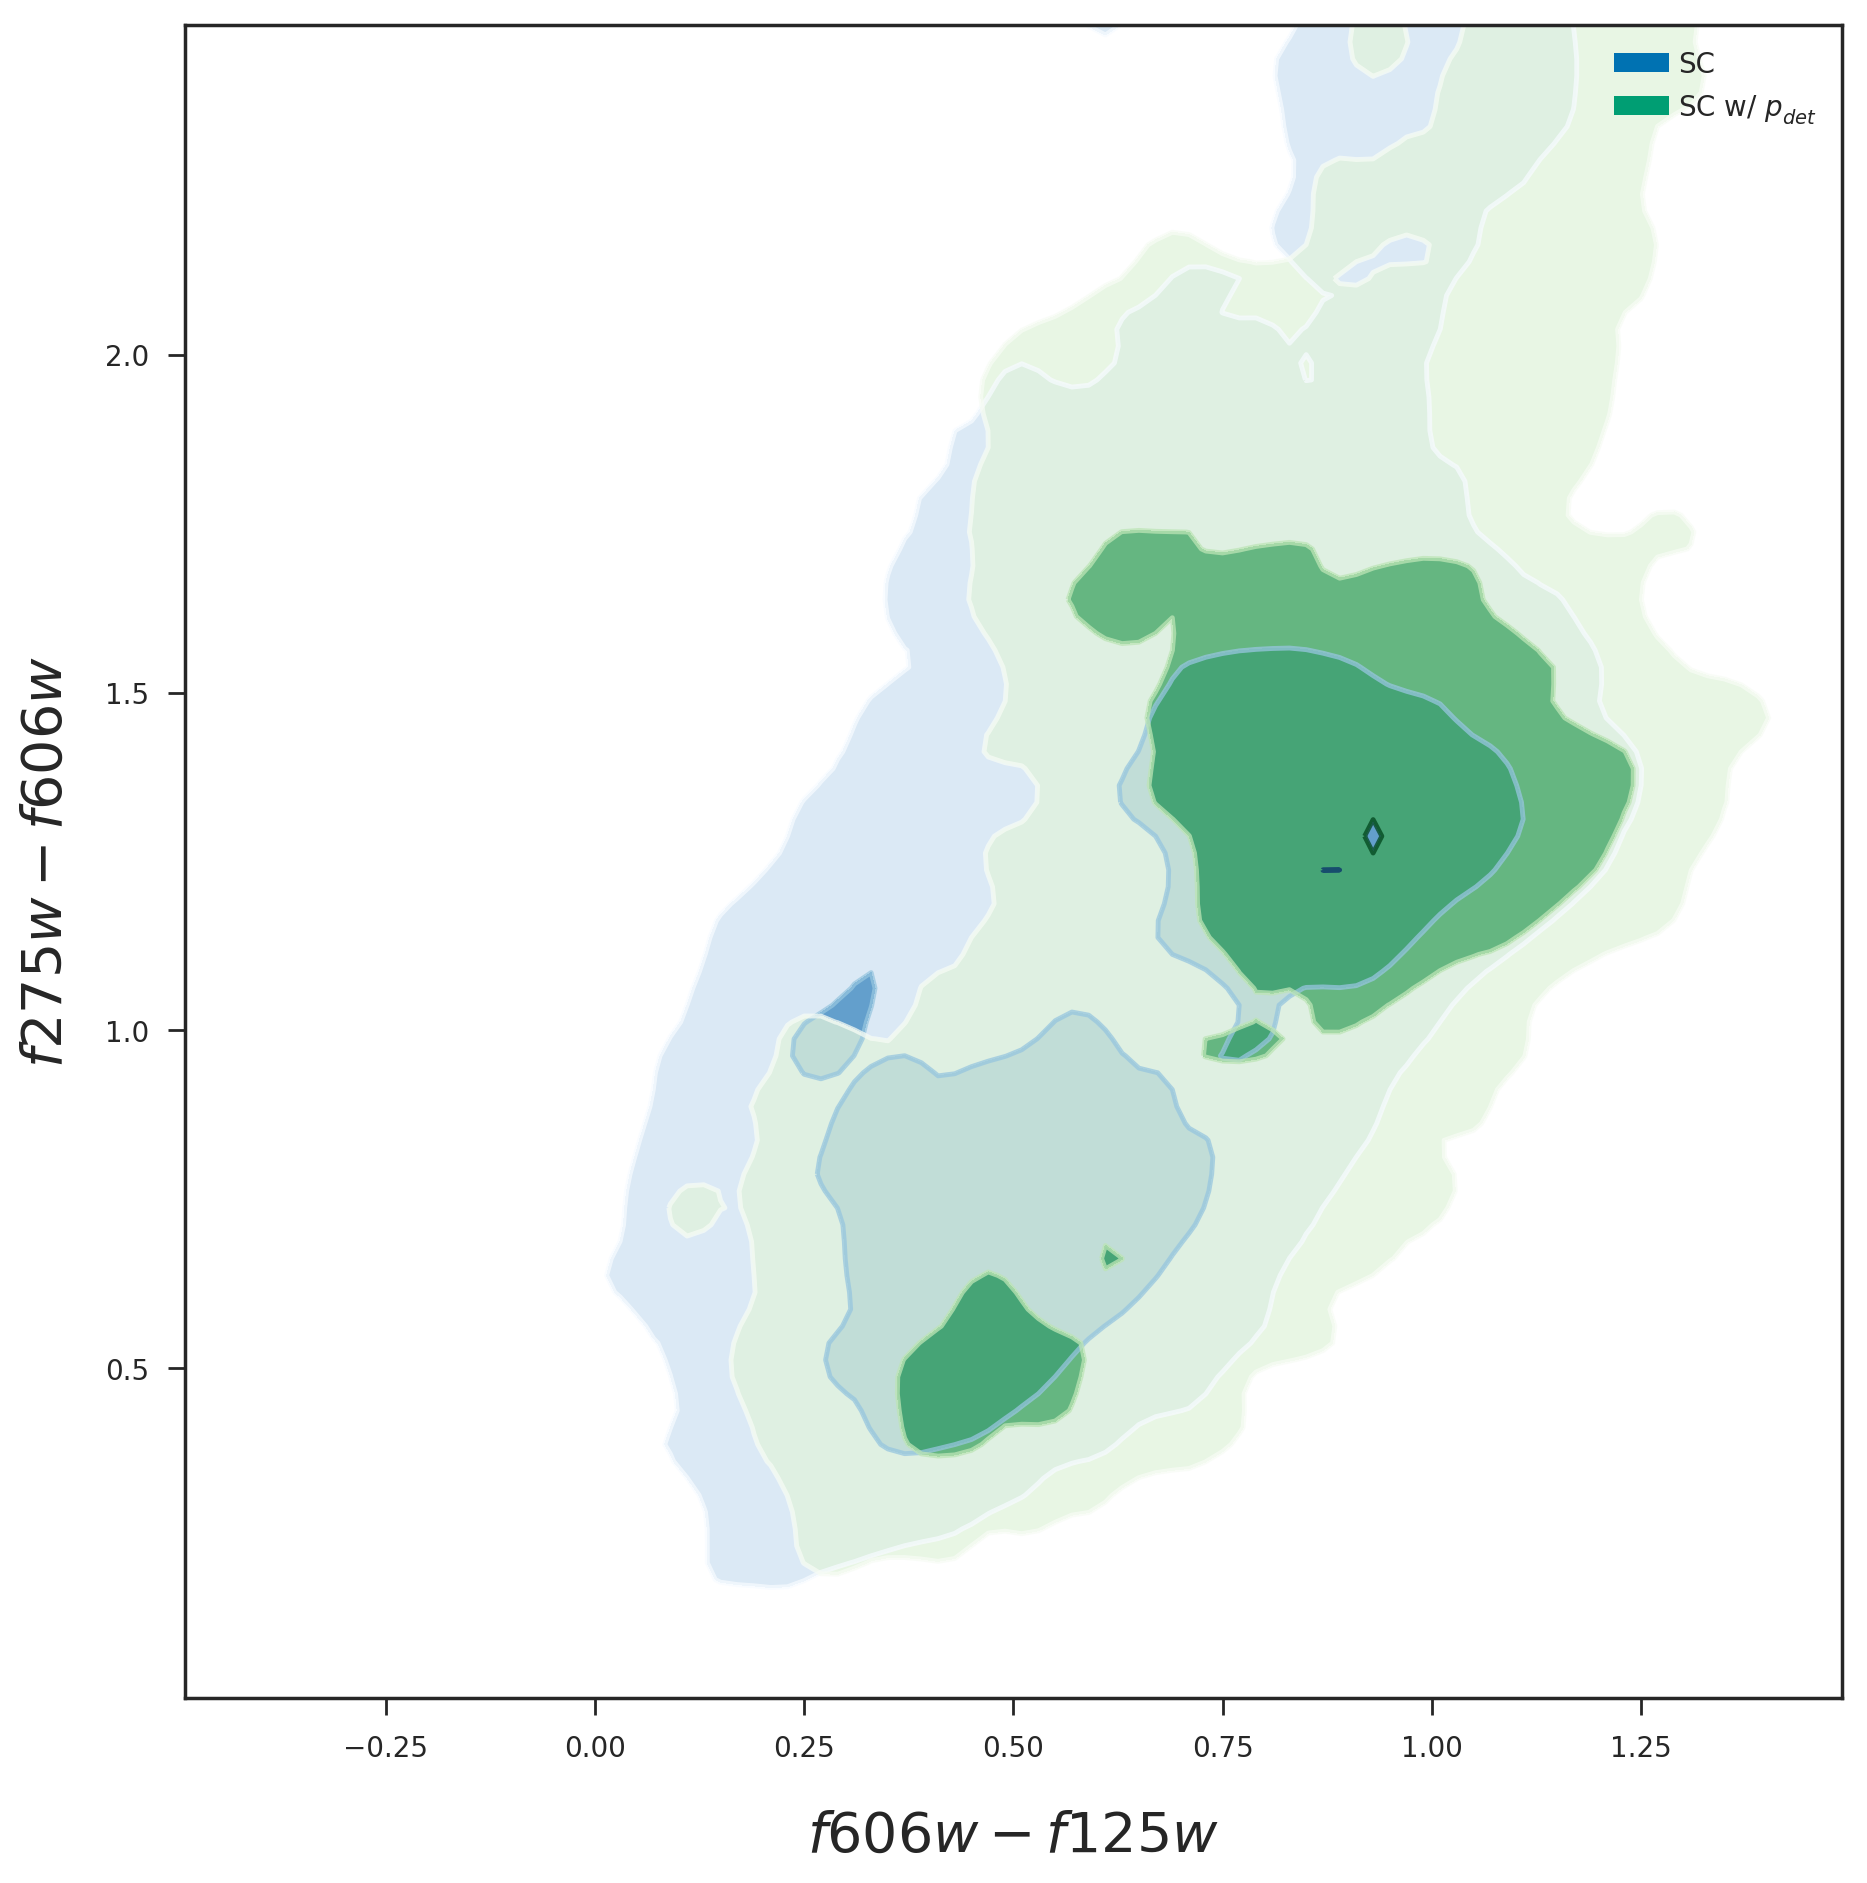

In [99]:
variables = ['redshift_true', ['mag_true_dust_f275w_wfc3', 'mag_true_dust_f606w_acs'], ['mag_true_dust_f606w_acs', 'mag_true_dust_f125w_wfc3']]
labels    = ['redshift_true',  r'$f275w-f606w$', r'$f606w-f125w$' ]
operations = [None, lambda x, y: x-y, lambda x, y: x-y]
plot_axes = [1,2]

Nbins    = [1, 100, 100]
bin_lo   = [0.0, 0, -0.5]
bin_hi   = [0.5, 2.5, 1.5]
logbins  = [False, False, False]


test = DistributionND(variables, plot_axes, operations=operations,
                      labels=labels, Nbins=Nbins, lo=bin_lo, hi=bin_hi,
                      logbins=logbins,weight_quantity='p_detection',)

c = test.run_on_single_catalog(sc_gc, 'SC', './')
cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$', './', useweights=True)
#scc_gc = GCRCatalogs.load_catalog('sc_candelized')
#test.new_quantities(['redshift_true', 'mag_f814w_acs'], labels=['redshift_true', r'$f814w\/ [mag]$'])
#cc = test.run_on_single_catalog(scc_gc, r'SC w/ $p_{det}$ and noise', './', useweights=True)

test.finalize_plot()


In [95]:
sc_gc.list_all_quantities()

['Mag_true_nodust_H_z0',
 'size_disk_true',
 'Mag_true_dust_UV1500_z0',
 'mag_true_dust_f336w_wfc3',
 'mag_true_dust_NUV_galex',
 'Mag_true_dust_K_z0',
 'mag_true_nodust_f606w_acs',
 'mag_true_dust_u_ctio',
 'Mag_true_nodust_UV2800_z0',
 'mag_true_dust_f814w_acs',
 'mag_true_dust_u38_musyc',
 'mag_true_dust_u_sdss',
 'mag_true_nodust_f435w_acs',
 'mag_true_nodust_bulge_f105w_wfc3',
 'mag_true_dust_FUV_galex',
 'mag_true_dust_K_ukirt',
 'Mag_true_nodust_R_z0',
 'mag_true_nodust_u_cfhtls',
 '$f275w-f606w$',
 'mag_true_dust_f435w_acs',
 'Mag_true_dust_J_z0',
 'mag_true_nodust_f160w_wfc3',
 'mag_dust_nodust_i_sdss',
 'Mag_true_nodust_U_z0',
 'mag_true_nodust_ch1_irac',
 'mag_true_dust_H_ukirt',
 'Mag_true_nodust_I_z0',
 'mag_true_nodust_J_ukirt',
 'mag_true_dust_f850lp_acs',
 'mag_true_nodust_u38_musyc',
 'mag_true_nodust_H_ukirt',
 'mag_true_dust_f775w_acs',
 'mag_true_nodust_ch2_irac',
 'mag_true_nodust_f336w_wfc3',
 'mag_true_dust_f606w_acs',
 'mag_true_dust_f125w_wfc3',
 'dec_true',
 '